# Pre-Equilibrium Maximazation of Yield #

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy

In [2]:
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7f02e8783550>


We'll start with the AP2 complex that we've worked with before. Pairwise $\Delta Gs$ were derived from the PDB structures via Rossetta

In [3]:
base_input = '../../input_files/trimer.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()


['default_assoc', 1.0]
['A']
100.0
['B']
100.0
['C']
100.0
Parsing rule...
SPLIT_01:  ['A(a)+B(a)', 'A(a!1).B(a!1)']
['A', 'B', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['A(b)+C(b)', 'A(b!1).C(b!1)']
['A', 'C', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['B(b)+C(a)', 'B(b!1).C(a!1)']
['B', 'C', '']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7f02112b1350>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7f02112b1350>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7f02112b1350>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (1, {'struct': <networkx.classes.graph.Graph object at 0x7f0210b288d0>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'A'}
{'B'}
{'A'}
False
Orig edges:  []
Nextn edge

In [4]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}


In [5]:
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = [1000.0,1000.0,1000.0,1000.0,1000.0,1000.0]*np.array([1e-3])  #Poor yield Simruntime = 1sec

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

# for edge in rn.network.edges:
#     print(rn.network.get_edge_data(edge[0],edge[1]))
vec_rn = VectorizedRxnNet(rn, dev='cpu',coupling=True,cid={0:4})
print(vec_rn.kon)

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 5}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 4}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 4}
{'k_on': 1

## The Equilibrium Solution ##
First we will find the equilibrium solution for this system.

In [6]:
# vec_rn.update_reaction_net(rn,1)
# poly_system = EquilibriumSolver(rn)
# solution = poly_system.solve()
# if solution == None:
#     print("No Equilibrium solution")
# else:
#     print(solution)
#     print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
# print(vec_rn.kon)

In [7]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
B
C
AB
AC
BC
ABC
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'B'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': None, 'uid': 0}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': None, 'uid': 1}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': None, 'uid': 2}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C', 'A'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': None, 'uid': 3}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'C'}, {'B', 'A'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': None, 'uid': 4}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C', 'B'}), 'kon': 1.0, 'score': tensor(

In [8]:
# uid_dict = {}
# sys.path.append("../")
# import numpy as np
# from reaction_network import gtostr
# from torch import DoubleTensor as Tensor
# import torch

# node_map = {}
# for node in rn.network.nodes():
#     node_map[gtostr(rn.network.nodes[node]['struct'])] = node

# print(node_map)

# def get_max_edge(n):
#     """
#     Calculates the max rate (k_on) for a given node
#     To find out the maximum flow path to the final complex starting from the current node.
    
#     Can also calculate the total rate of consumption of a node by summing up all rates. 
#     Can tell which component is used quickly.
#     """
#     try:
#         edges = rn.network.out_edges(n)
#         #Loop over all edges
#         #Get attributes
#         if len(edges)==0:
#             return(False)
#         kon_max = -1
#         next_node = -1
        
#         kon_sum = 0
#         for edge in edges:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']
#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]
#             kon_sum+=temp_kon
            
#             if temp_kon > kon_max:
#                 kon_max = temp_kon
#                 next_node=edge[1]
#         return(kon_max,next_node,kon_sum)
#     except Exception as err:
#         raise(err)
# def get_node_flux(n):
#     total_flux_outedges = 0
#     total_flux_inedges = 0
#     #Go over all the out edges
#     edges_out = rn.network.out_edges(n)
#     if len(edges_out)>0:

#         for edge in edges_out:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]

#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Getting conc. of reactants and products
#             #Get product
#             prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

#             #Net flux from this edge = Generation - consumption
#             edge_flux = koff*solution[edge[1]] - temp_kon*(solution[edge[0]])*(solution[node_map[react]])
#             #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

#             print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
#             print("Net flux: ",edge_flux)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Free Energy: ",vec_rn.rxn_score_vec[uid])
#             print("Reaction data OUTWARD: ")
#             print(data)

#             total_flux_outedges+=edge_flux
    
#     #Now go over all the in edges
#     edges_in = rn.network.in_edges(n)
#     react_list = []
#     if len(edges_in) > 0:
#         for edge in edges_in:
#             if edge[0] in react_list:
#                 continue
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             uid = data['uid']


#             #Get generation rates; which would be kon
#             temp_kon = vec_rn.kon[uid]

#             #Get consumption rates; which is k_off
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Get conc. of reactants and products
#             prod = gtostr(rn.network.nodes[edge[1]]['struct'])
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
#             react_list.append(node_map[react])
#             #Net flux from this edge = Generation - consumption
#             edge_flux_in = temp_kon*(solution[edge[0]])*(solution[node_map[react]])- koff*solution[edge[1]]
#             #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


#             print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
#             print("Net flux: ",edge_flux_in)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Raction data INWARD: ")
#             print(data)

#             total_flux_inedges+=edge_flux_in
#     net_node_flux = total_flux_outedges + total_flux_inedges
    
#     return(net_node_flux)
# pathway = []
# kon_sumarray = []
# total_con_rate = {}
# net_flux = {}

# if solution != None:
#     for n in rn.network.nodes():

#         n_str = gtostr(rn.network.nodes[n]['struct']) 

#         paths = [n_str]
#         kon_sum = 0
#         temp_node = n
#         max_edge = True
#         consumption_rate = 0
#         if n < len(rn.network.nodes()):#num_monomers:
#     #         print("Current node: ")
#     #         print(n_str)
#             while max_edge:
#                 max_edge = get_max_edge(temp_node)
#                 if max_edge:
#                     total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
#                     temp_node = max_edge[1]
#                     kon_sum += max_edge[0].item()


#     #                 print("Next node: ")
#     #                 print(temp_node)

#                     paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
#                 else:
#                     break
#             pathway.append(paths)
#             kon_sumarray.append(kon_sum)
#             paths=[]

#         print("-------------------------------------------------------------------------------")
#         print("-------------------------------------------------------------------------------")
#         print("|                                                                             |")
#         node_flux = get_node_flux(n)
#         net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
#         print("|                                                                             |")
#         print("-------------------------------------------------------------------------------")
#         print("-------------------------------------------------------------------------------")

#     print(pathway)
#     print(kon_sumarray)
#     #print(total_con_rate)

In [9]:
# if solution != None:
#     for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
#         print(k," : ", v.item())

In [10]:
# if solution !=None:
#     for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#         print(k," : ", v)



## Using the optimizer with a 1 second simulation runtime ##

In [11]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1,
                  optim_iterations=5000,
                  learning_rate=1e-2,
                  device='cpu',method="RMSprop")
optim.rn.update_reaction_net(rn)
optim.optimize(conc_scale=1,conc_thresh=1,mod_bool=True,mod_factor=10,max_thresh=1e8,max_yield=0,yield_species=-1)

Using CPU
Reaction Parameters before optimization: 
[Parameter containing:
tensor([1., 1., 1., 1., 1., 1.], dtype=torch.float64, requires_grad=True)]
Optimizer State: <bound method Optimizer.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)>
Using CPU
Start of simulation: memory Used:  31.5
Next time:  tensor(5.6156, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 0 was 67.3%
current params: tensor([1., 1., 1., 1., 1., 1.], dtype=torch.float64)
Grad:  tensor([ 0.4364,  0.4364, -0.3809, -0.3896, -0.3896,  0.2256],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.5
Next time:  tensor(1.0853, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1 was 68.9%
current params: tensor([0.9000, 0.9000, 1.1000, 1.1000, 1.1000, 0.9000], dtype=torch.float64)
Grad:  tensor([-3.0858,  5.6413, -5.4754, -3.3599,  2.0325,  5.6927],
       dtype=torch

Next time:  tensor(1.0366, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 23 was 68.3%
current params: tensor([0.9232, 0.8436, 1.1946, 1.1634, 1.0851, 0.8157], dtype=torch.float64)
Grad:  tensor([-1.8149,  2.4179, -0.1827, -1.2796,  1.0945,  0.1152],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.7
Next time:  tensor(1.0444, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 24 was 68.3%
current params: tensor([0.9260, 0.8407, 1.1953, 1.1673, 1.0831, 0.8154], dtype=torch.float64)
Grad:  tensor([-6.7052,  7.4166, -0.3473, -3.8163,  4.2178,  0.2641],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.7
Next time:  tensor(1.0391, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 25 was 68.3%
current params: tensor([0.9364, 0.8316, 1.1966, 1.1790, 1.0751, 0.8145], dtype=torch.float64)
Grad:  tensor([ 18.1356, -18.0498,   0.5950,   8.9156, -11.8895,  -0.5827],
       dtype=torch.flo

Next time:  tensor(1.5271, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 47 was 68.6%
current params: tensor([0.8611, 0.8813, 1.1962, 1.1240, 1.1390, 0.8200], dtype=torch.float64)
Grad:  tensor([-8.1732, 12.2189, -8.3301, -6.8716,  4.6557, 10.4814],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.4
Next time:  tensor(3.5665, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 48 was 68.4%
current params: tensor([0.8720, 0.8674, 1.2291, 1.1414, 1.1306, 0.7851], dtype=torch.float64)
Grad:  tensor([-0.0464,  0.7957, -0.5483, -0.4957, -0.0575,  0.7562],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.5
Next time:  tensor(5.8683, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 49 was 68.7%
current params: tensor([0.8720, 0.8665, 1.2313, 1.1427, 1.1307, 0.7826], dtype=torch.float64)
Grad:  tensor([ 0.3386,  0.1690, -0.0577, -0.1354, -0.2375, -0.0110],
       dtype=torch.float64)


Next time:  tensor(6.0112, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 72 was 69.0%
current params: tensor([0.8605, 0.8625, 1.2352, 1.1503, 1.1415, 0.7854], dtype=torch.float64)
Grad:  tensor([ 0.3697,  0.1189, -0.0224, -0.1073, -0.2497, -0.0578],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.6
Next time:  tensor(6.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 73 was 69.0%
current params: tensor([0.8599, 0.8623, 1.2353, 1.1506, 1.1420, 0.7856], dtype=torch.float64)
Grad:  tensor([ 0.3710,  0.1168, -0.0209, -0.1062, -0.2502, -0.0598],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.6
Next time:  tensor(6.0409, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 74 was 69.0%
current params: tensor([0.8594, 0.8622, 1.2354, 1.1509, 1.1426, 0.7858], dtype=torch.float64)
Grad:  tensor([ 0.3723,  0.1147, -0.0195, -0.1050, -0.2507, -0.0617],
       dtype=torch.float64)


Next time:  tensor(1.0364, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 96 was 67.7%
current params: tensor([0.8899, 0.8089, 1.3240, 1.2117, 1.1206, 0.6931], dtype=torch.float64)
Grad:  tensor([-0.1248,  0.8000, -0.4193, -0.3915,  0.0295,  0.5743],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.9
Next time:  tensor(1.0477, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 97 was 67.7%
current params: tensor([0.8901, 0.8079, 1.3256, 1.2128, 1.1205, 0.6914], dtype=torch.float64)
Grad:  tensor([ 2.4895, -2.2383,  0.2274,  0.9625, -1.4677, -0.4252],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.9
Next time:  tensor(1.0417, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 98 was 67.7%
current params: tensor([0.8861, 0.8109, 1.3247, 1.2100, 1.1238, 0.6927], dtype=torch.float64)
Grad:  tensor([-0.1009,  0.7644, -0.3991, -0.3783,  0.0153,  0.5436],
       dtype=torch.float64)


Next time:  tensor(1.2354, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 120 was 67.8%
current params: tensor([0.8519, 0.8226, 1.3440, 1.2009, 1.1519, 0.6737], dtype=torch.float64)
Grad:  tensor([-0.1484,  0.8136, -0.4276, -0.4134,  0.0403,  0.6227],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.9
Next time:  tensor(1.2329, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 121 was 67.8%
current params: tensor([0.8522, 0.8213, 1.3457, 1.2022, 1.1518, 0.6716], dtype=torch.float64)
Grad:  tensor([ 2.9866, -2.5586, -0.0416,  1.1562, -1.5922, -0.0090],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  31.9
Next time:  tensor(1.2515, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 122 was 67.8%
current params: tensor([0.8468, 0.8252, 1.3459, 1.1984, 1.1558, 0.6716], dtype=torch.float64)
Grad:  tensor([-0.1467,  0.8083, -0.4250, -0.4140,  0.0391,  0.6222],
       dtype=torch.float6

Next time:  tensor(6.6056, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 144 was 67.4%
current params: tensor([0.7962, 0.8409, 1.4168, 1.1839, 1.1920, 0.5813], dtype=torch.float64)
Grad:  tensor([ 0.3751,  0.0538,  0.0226, -0.0748, -0.2091, -0.1739],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  32.1
Next time:  tensor(6.6324, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 145 was 67.4%
current params: tensor([0.7954, 0.8408, 1.4167, 1.1841, 1.1926, 0.5818], dtype=torch.float64)
Grad:  tensor([ 0.3772,  0.0513,  0.0241, -0.0736, -0.2098, -0.1768],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  32.1
Next time:  tensor(6.6314, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 146 was 67.4%
current params: tensor([0.7947, 0.8408, 1.4166, 1.1844, 1.1932, 0.5824], dtype=torch.float64)
Grad:  tensor([-1.1264,  1.4785,  0.0951, -0.7660,  0.4492, -0.2992],
       dtype=torch.float6

Next time:  tensor(6.0149, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 168 was 67.8%
current params: tensor([0.8009, 0.8168, 1.4289, 1.2134, 1.1919, 0.5764], dtype=torch.float64)
Grad:  tensor([ 0.4031,  0.0133,  0.0466, -0.0528, -0.2267, -0.2233],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  32.3
Next time:  tensor(6.0167, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 169 was 67.8%
current params: tensor([0.8001, 0.8167, 1.4286, 1.2136, 1.1926, 0.5771], dtype=torch.float64)
Grad:  tensor([ 0.4047,  0.0116,  0.0476, -0.0521, -0.2271, -0.2252],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  32.3
Next time:  tensor(6.0197, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 170 was 67.8%
current params: tensor([0.7992, 0.8167, 1.4284, 1.2138, 1.1933, 0.5778], dtype=torch.float64)
Grad:  tensor([ 0.4061,  0.0100,  0.0486, -0.0514, -0.2274, -0.2270],
       dtype=torch.float6

Next time:  tensor(2.4469, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 192 was 67.6%
current params: tensor([0.7835, 0.8066, 1.4551, 1.2275, 1.2064, 0.5489], dtype=torch.float64)
Grad:  tensor([-0.1339,  0.7539, -0.3651, -0.3704,  0.0226,  0.7152],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  32.6
Next time:  tensor(2.3380, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 193 was 67.6%
current params: tensor([0.7838, 0.8051, 1.4570, 1.2291, 1.2063, 0.5465], dtype=torch.float64)
Grad:  tensor([-0.1309,  0.7522, -0.3620, -0.3670,  0.0222,  0.7062],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  32.6
Next time:  tensor(2.2509, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 194 was 67.6%
current params: tensor([0.7841, 0.8036, 1.4588, 1.2307, 1.2062, 0.5441], dtype=torch.float64)
Grad:  tensor([-0.1327,  0.7565, -0.3623, -0.3664,  0.0237,  0.7060],
       dtype=torch.float6

Next time:  tensor(6.1024, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 216 was 67.6%
current params: tensor([0.7412, 0.8104, 1.5054, 1.2285, 1.2350, 0.4812], dtype=torch.float64)
Grad:  tensor([ 0.7807, -0.4606,  0.2850,  0.1362, -0.3557, -0.8841],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  32.8
Next time:  tensor(5.5154, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 217 was 67.7%
current params: tensor([0.7392, 0.8114, 1.5039, 1.2278, 1.2363, 0.4842], dtype=torch.float64)
Grad:  tensor([ 0.4304, -0.0384, -0.0029, -0.0855, -0.2502,  0.1418],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  32.8
Next time:  tensor(4.7923, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 218 was 67.6%
current params: tensor([0.7381, 0.8115, 1.5039, 1.2282, 1.2373, 0.4837], dtype=torch.float64)
Grad:  tensor([ 0.4469, -0.0278,  0.0082, -0.0779, -0.2453,  0.0344],
       dtype=torch.float6

Next time:  tensor(7.6222, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 240 was 68.3%
current params: tensor([0.7136, 0.7978, 1.5194, 1.2485, 1.2555, 0.4703], dtype=torch.float64)
Grad:  tensor([ 0.6044,  1.6766, -0.9905, -0.8075, -0.2779,  2.1916],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  33.1
Next time:  tensor(7.6020, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 241 was 68.3%
current params: tensor([0.7119, 0.7936, 1.5254, 1.2529, 1.2567, 0.4620], dtype=torch.float64)
Grad:  tensor([ 0.6605,  1.9267, -1.1400, -0.9106, -0.3002,  2.5870],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  33.1
Next time:  tensor(7.6024, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 242 was 68.3%
current params: tensor([0.7100, 0.7888, 1.5324, 1.2579, 1.2580, 0.4523], dtype=torch.float64)
Grad:  tensor([ 0.9947,  2.7318, -1.6525, -1.2649, -0.4365,  3.8670],
       dtype=torch.float6

Next time:  tensor(5.6448, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 264 was 68.9%
current params: tensor([0.6719, 0.7515, 1.5797, 1.2988, 1.2829, 0.3954], dtype=torch.float64)
Grad:  tensor([ 0.2786,  0.2563, -0.0732, -0.1414, -0.1248,  0.0448],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  33.4
Next time:  tensor(5.6396, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 265 was 69.0%
current params: tensor([0.6710, 0.7508, 1.5802, 1.2997, 1.2836, 0.3952], dtype=torch.float64)
Grad:  tensor([ 0.2781,  0.2557, -0.0727, -0.1409, -0.1243,  0.0435],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  33.4
Next time:  tensor(5.6317, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 266 was 69.0%
current params: tensor([0.6701, 0.7500, 1.5807, 1.3005, 1.2842, 0.3951], dtype=torch.float64)
Grad:  tensor([ 0.2776,  0.2552, -0.0722, -0.1405, -0.1239,  0.0422],
       dtype=torch.float6

Next time:  tensor(4.9310, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 288 was 69.8%
current params: tensor([0.6495, 0.7336, 1.5912, 1.3199, 1.2979, 0.3920], dtype=torch.float64)
Grad:  tensor([ 0.2747,  0.2508, -0.0655, -0.1344, -0.1176,  0.0269],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  33.7
Next time:  tensor(4.8851, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 289 was 69.8%
current params: tensor([0.6485, 0.7328, 1.5917, 1.3208, 1.2985, 0.3919], dtype=torch.float64)
Grad:  tensor([ 0.2747,  0.2508, -0.0653, -0.1342, -0.1174,  0.0265],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  33.7
Next time:  tensor(4.8387, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 290 was 69.8%
current params: tensor([0.6476, 0.7320, 1.5922, 1.3217, 1.2991, 0.3918], dtype=torch.float64)
Grad:  tensor([ 0.2748,  0.2507, -0.0651, -0.1340, -0.1172,  0.0261],
       dtype=torch.float6

Next time:  tensor(5.1060, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 312 was 70.8%
current params: tensor([0.6141, 0.7177, 1.6023, 1.3414, 1.3198, 0.3884], dtype=torch.float64)
Grad:  tensor([ 0.3061,  0.2736, -0.0764, -0.1417, -0.1190,  0.0637],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  33.9
Next time:  tensor(5.1578, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 313 was 70.8%
current params: tensor([0.6128, 0.7167, 1.6029, 1.3425, 1.3205, 0.3881], dtype=torch.float64)
Grad:  tensor([ 0.3042,  0.2717, -0.0749, -0.1406, -0.1180,  0.0597],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  33.9
Next time:  tensor(5.2066, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 314 was 70.9%
current params: tensor([0.6116, 0.7157, 1.6035, 1.3436, 1.3212, 0.3878], dtype=torch.float64)
Grad:  tensor([ 0.3026,  0.2701, -0.0737, -0.1396, -0.1172,  0.0563],
       dtype=torch.float6

Next time:  tensor(5.2770, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 336 was 71.8%
current params: tensor([0.5835, 0.6939, 1.6167, 1.3677, 1.3374, 0.3833], dtype=torch.float64)
Grad:  tensor([ 0.2959,  0.2611, -0.0628, -0.1305, -0.1080,  0.0287],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  34.1
Next time:  tensor(5.2377, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 337 was 71.8%
current params: tensor([0.5822, 0.6929, 1.6172, 1.3688, 1.3381, 0.3831], dtype=torch.float64)
Grad:  tensor([ 0.2961,  0.2611, -0.0626, -0.1302, -0.1078,  0.0282],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  34.2
Next time:  tensor(3.4736, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 338 was 71.6%
current params: tensor([0.5808, 0.6918, 1.6178, 1.3699, 1.3389, 0.3830], dtype=torch.float64)
Grad:  tensor([ 0.3455,  0.3023, -0.1181, -0.1660, -0.1371,  0.3462],
       dtype=torch.float6

Next time:  tensor(5.6781, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 360 was 73.3%
current params: tensor([0.5327, 0.6700, 1.6323, 1.3957, 1.3632, 0.3790], dtype=torch.float64)
Grad:  tensor([ 0.3195,  0.2720, -0.0636, -0.1311, -0.1019,  0.0395],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  34.4
Next time:  tensor(5.7052, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 361 was 73.3%
current params: tensor([0.5311, 0.6688, 1.6330, 1.3970, 1.3640, 0.3787], dtype=torch.float64)
Grad:  tensor([ 0.3194,  0.2717, -0.0632, -0.1307, -0.1015,  0.0382],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  34.4
Next time:  tensor(5.7253, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 362 was 73.4%
current params: tensor([0.5294, 0.6675, 1.6337, 1.3982, 1.3648, 0.3785], dtype=torch.float64)
Grad:  tensor([ 0.3194,  0.2715, -0.0627, -0.1303, -0.1011,  0.0371],
       dtype=torch.float6

Next time:  tensor(6.0713, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 384 was 75.1%
current params: tensor([0.4788, 0.6444, 1.6452, 1.4245, 1.3874, 0.3822], dtype=torch.float64)
Grad:  tensor([ 0.3462,  0.2832, -0.0637, -0.1317, -0.0950,  0.0495],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  34.7
Next time:  tensor(6.1611, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 385 was 75.1%
current params: tensor([0.4768, 0.6430, 1.6459, 1.4259, 1.3883, 0.3819], dtype=torch.float64)
Grad:  tensor([ 0.3456,  0.2824, -0.0629, -0.1310, -0.0944,  0.0471],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  34.7
Next time:  tensor(6.2389, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 386 was 75.2%
current params: tensor([0.4748, 0.6415, 1.6467, 1.4274, 1.3891, 0.3816], dtype=torch.float64)
Grad:  tensor([ 0.3453,  0.2818, -0.0622, -0.1304, -0.0938,  0.0450],
       dtype=torch.float6

Next time:  tensor(7.0943, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 408 was 77.3%
current params: tensor([0.4137, 0.6121, 1.6616, 1.4583, 1.4123, 0.3810], dtype=torch.float64)
Grad:  tensor([ 0.3744,  0.2904, -0.0593, -0.1292, -0.0845,  0.0475],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  34.9
Next time:  tensor(7.1845, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 409 was 77.4%
current params: tensor([0.4114, 0.6105, 1.6624, 1.4599, 1.4132, 0.3806], dtype=torch.float64)
Grad:  tensor([ 0.3745,  0.2900, -0.0586, -0.1286, -0.0839,  0.0455],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  34.9
Next time:  tensor(7.2447, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 410 was 77.4%
current params: tensor([0.4090, 0.6088, 1.6631, 1.4615, 1.4140, 0.3802], dtype=torch.float64)
Grad:  tensor([ 0.3747,  0.2896, -0.0580, -0.1281, -0.0833,  0.0438],
       dtype=torch.float6

Next time:  tensor(1.0104, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 432 was 82.1%
current params: tensor([0.2630, 0.5795, 1.6857, 1.4996, 1.4602, 0.3820], dtype=torch.float64)
Grad:  tensor([ 0.5058,  0.3231, -0.0651, -0.1455, -0.0605,  0.1152],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  35.2
Next time:  tensor(10.8599, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 433 was 82.8%
current params: tensor([0.2604, 0.5775, 1.6866, 1.5016, 1.4608, 0.3811], dtype=torch.float64)
Grad:  tensor([ 0.4993,  0.3177, -0.0601, -0.1426, -0.0601,  0.0995],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  35.2
Next time:  tensor(1.3320, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 434 was 82.4%
current params: tensor([0.2578, 0.5755, 1.6875, 1.5036, 1.4615, 0.3804], dtype=torch.float64)
Grad:  tensor([-12.2126,  12.0880,  -5.0046,  -4.2811,   1.2423,  24.2063],
       dtype=torch

Next time:  tensor(1.3243, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 456 was 82.1%
current params: tensor([0.2687, 0.4799, 1.7594, 1.5831, 1.4632, 0.2897], dtype=torch.float64)
Grad:  tensor([ 0.5058,  0.3627, -0.0634, -0.1204, -0.0662,  0.1288],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  35.4
Next time:  tensor(1.3038, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 457 was 82.2%
current params: tensor([0.2663, 0.4779, 1.7602, 1.5847, 1.4640, 0.2892], dtype=torch.float64)
Grad:  tensor([ 0.4964,  0.3544, -0.0591, -0.1174, -0.0643,  0.1076],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  35.5
Next time:  tensor(1.2851, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 458 was 82.3%
current params: tensor([0.2639, 0.4759, 1.7610, 1.5863, 1.4648, 0.2887], dtype=torch.float64)
Grad:  tensor([ 0.4913,  0.3494, -0.0564, -0.1155, -0.0629,  0.0945],
       dtype=torch.float6

Grad:  tensor([ 0.5229,  0.3564, -0.0490, -0.1100, -0.0537,  0.0787],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  35.7
Next time:  tensor(1.2992, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 480 was 84.9%
current params: tensor([0.2148, 0.4373, 1.7697, 1.6160, 1.4790, 0.2934], dtype=torch.float64)
Grad:  tensor([ 0.5240,  0.3560, -0.0481, -0.1094, -0.0530,  0.0757],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  35.7
Next time:  tensor(1.2814, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 481 was 85.0%
current params: tensor([0.2119, 0.4350, 1.7704, 1.6176, 1.4797, 0.2930], dtype=torch.float64)
Grad:  tensor([ 0.5256,  0.3559, -0.0474, -0.1089, -0.0523,  0.0735],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  35.7
Next time:  tensor(1.2647, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 482 was 85.1%
current params: tensor([0.2091, 0.4328, 1

Grad:  tensor([ 0.2699,  0.1416,  0.0534, -0.0410, -0.0172, -0.4775],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.0
Next time:  tensor(1.1162, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 504 was 88.0%
current params: tensor([0.1582, 0.3962, 1.7700, 1.6453, 1.4912, 0.3142], dtype=torch.float64)
Grad:  tensor([ 0.2715,  0.1423,  0.0536, -0.0409, -0.0170, -0.4756],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.0
Next time:  tensor(1.0819, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 505 was 88.0%
current params: tensor([0.1566, 0.3952, 1.7691, 1.6460, 1.4915, 0.3167], dtype=torch.float64)
Grad:  tensor([ 0.2732,  0.1431,  0.0538, -0.0409, -0.0169, -0.4737],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.0
Next time:  tensor(1.0497, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 506 was 88.1%
current params: tensor([0.1549, 0.3942, 1

Grad:  tensor([ 1.0000,  0.1043,  0.0666, -0.0517, -0.0396, -0.3634],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.3
Next time:  tensor(1.0319, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 528 was 91.4%
current params: tensor([0.1064, 0.5358, 1.5933, 1.4919, 1.5453, 0.4921], dtype=torch.float64)
Grad:  tensor([ 1.0017,  0.1074,  0.0657, -0.0528, -0.0387, -0.3580],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.3
Next time:  tensor(1.0298, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 529 was 91.5%
current params: tensor([0.1040, 0.5354, 1.5927, 1.4925, 1.5460, 0.4927], dtype=torch.float64)
Grad:  tensor([ 1.0042,  0.1101,  0.0649, -0.0538, -0.0378, -0.3534],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.3
Next time:  tensor(1.0286, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 530 was 91.7%
current params: tensor([0.1016, 0.5351, 1

Grad:  tensor([ 0.3346,  0.1349,  0.0680, -0.0554, -0.0103, -0.3145],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.5
Next time:  tensor(1.4886, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 552 was 91.9%
current params: tensor([0.1013, 0.5259, 1.5798, 1.5072, 1.5608, 0.5047], dtype=torch.float64)
Grad:  tensor([-4.4017,  2.7609,  1.5768, -0.8952,  0.2497, -5.1178],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.6
Next time:  tensor(1.2514, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 553 was 91.4%
current params: tensor([0.1124, 0.5159, 1.5648, 1.5179, 1.5561, 0.5132], dtype=torch.float64)
Grad:  tensor([ 0.9265,  0.1582,  0.0461, -0.0702, -0.0401, -0.2613],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.6
Next time:  tensor(1.2591, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 554 was 91.6%
current params: tensor([0.1101, 0.5153, 1

Grad:  tensor([ 1.0183,  0.1185,  0.0778, -0.0462, -0.0420, -0.3474],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.9
Next time:  tensor(1.1342, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 576 was 92.6%
current params: tensor([0.1014, 0.4898, 1.5176, 1.5462, 1.5648, 0.5438], dtype=torch.float64)
Grad:  tensor([ 1.0208,  0.1218,  0.0770, -0.0473, -0.0409, -0.3427],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.9
Next time:  tensor(1.1312, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 577 was 92.7%
current params: tensor([0.0986, 0.4893, 1.5167, 1.5469, 1.5657, 0.5444], dtype=torch.float64)
Grad:  tensor([-8.9758,  0.1247,  0.0763, -0.0482, -0.0397, -0.3387],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  36.9
Next time:  tensor(1.2156, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 578 was 91.5%
current params: tensor([0.1225, 0.4888, 1

Grad:  tensor([ 1.0042,  0.1210,  0.0893, -0.0395, -0.0510, -0.3481],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  37.2
Next time:  tensor(1.0722, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 600 was 92.6%
current params: tensor([0.1145, 0.4522, 1.4547, 1.5828, 1.5748, 0.5806], dtype=torch.float64)
Grad:  tensor([ 1.0071,  0.1241,  0.0886, -0.0404, -0.0497, -0.3442],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  37.2
Next time:  tensor(1.0707, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 601 was 92.8%
current params: tensor([0.1117, 0.4517, 1.4537, 1.5834, 1.5760, 0.5813], dtype=torch.float64)
Grad:  tensor([ 1.0108,  0.1269,  0.0881, -0.0412, -0.0485, -0.3410],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  37.2
Next time:  tensor(1.0704, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 602 was 92.9%
current params: tensor([0.1088, 0.4511, 1

Grad:  tensor([ 1.0186,  0.1346,  0.0919, -0.0397, -0.0481, -0.3369],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  37.4
Next time:  tensor(1.4652, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 624 was 93.5%
current params: tensor([0.1051, 0.4330, 1.4335, 1.6033, 1.6032, 0.5955], dtype=torch.float64)
Grad:  tensor([ 41.8111, -27.1815,  21.0878,  10.9638,  -1.4038, -64.1828],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  37.4
Next time:  tensor(1.4156, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 625 was 97.7%
current params: tensor([0.0270, 0.5142, 1.3393, 1.5155, 1.6382, 0.6790], dtype=torch.float64)
Grad:  tensor([-7.9130, -0.6575,  0.6069,  0.3767, -0.0189, -1.6346],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  37.5
Next time:  tensor(1.3891, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 626 was 96.8%
current params: tensor([0.0417, 0.5

Next time:  tensor(1.1297, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 647 was 94.8%
current params: tensor([0.0623, 0.6109, 1.3994, 1.4068, 1.7367, 0.6289], dtype=torch.float64)
Grad:  tensor([-0.3523, -4.7344,  3.0224,  2.9506, -0.1885, -9.2300],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  37.6
Next time:  tensor(1.1139, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 648 was 94.8%
current params: tensor([0.0625, 0.6144, 1.3945, 1.4001, 1.7380, 0.6358], dtype=torch.float64)
Grad:  tensor([-1.9769, -3.8724,  2.5189,  2.4430, -0.1572, -7.5881],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  37.6
Next time:  tensor(1.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 649 was 94.8%
current params: tensor([0.0634, 0.6173, 1.3904, 1.3946, 1.7390, 0.6415], dtype=torch.float64)
Grad:  tensor([-0.4412, -4.6813,  3.0260,  2.9730, -0.1909, -9.0106],
       dtype=torch.float6

Next time:  tensor(1.2090, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 671 was 92.8%
current params: tensor([0.1000, 0.6660, 1.3168, 1.2952, 1.7596, 0.7343], dtype=torch.float64)
Grad:  tensor([ 0.8325,  0.2214,  0.0109, -0.1508, -0.0297, -0.0550],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  37.9
Next time:  tensor(1.2057, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 672 was 92.9%
current params: tensor([0.0996, 0.6658, 1.3168, 1.2955, 1.7598, 0.7343], dtype=torch.float64)
Grad:  tensor([-9.1462,  0.2091,  0.0191, -0.1422, -0.0302, -0.0749],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  37.9
Next time:  tensor(1.2626, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 673 was 92.6%
current params: tensor([0.1045, 0.6656, 1.3168, 1.2959, 1.7600, 0.7344], dtype=torch.float64)
Grad:  tensor([-0.3113,  0.8389,  0.3256, -0.4655,  0.0287, -0.6057],
       dtype=torch.float6

Next time:  tensor(1.1670, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 695 was 93.0%
current params: tensor([0.1003, 0.6617, 1.2927, 1.2990, 1.7627, 0.7583], dtype=torch.float64)
Grad:  tensor([ 0.9104,  0.1761,  0.0447, -0.1170, -0.0330, -0.1290],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  38.2
Next time:  tensor(1.1656, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 696 was 93.0%
current params: tensor([0.0997, 0.6616, 1.2926, 1.2993, 1.7630, 0.7584], dtype=torch.float64)
Grad:  tensor([-9.0831,  0.1727,  0.0472, -0.1145, -0.0330, -0.1345],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  38.2
Next time:  tensor(1.1866, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 697 was 92.7%
current params: tensor([0.1052, 0.6614, 1.2925, 1.2996, 1.7633, 0.7585], dtype=torch.float64)
Grad:  tensor([ 0.7690,  0.2575, -0.0108, -0.1736, -0.0298, -0.0021],
       dtype=torch.float6

Next time:  tensor(1.1584, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 719 was 93.1%
current params: tensor([0.0994, 0.6571, 1.2911, 1.3080, 1.7695, 0.7605], dtype=torch.float64)
Grad:  tensor([-9.0729,  0.1664,  0.0527, -0.1083, -0.0334, -0.1460],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  38.5
Next time:  tensor(1.1748, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 720 was 92.8%
current params: tensor([0.1055, 0.6569, 1.2910, 1.3083, 1.7698, 0.7606], dtype=torch.float64)
Grad:  tensor([ 0.8202,  0.2260,  0.0115, -0.1494, -0.0319, -0.0531],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  38.5
Next time:  tensor(1.1715, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 721 was 92.8%
current params: tensor([0.1050, 0.6567, 1.2910, 1.3088, 1.7701, 0.7607], dtype=torch.float64)
Grad:  tensor([ 0.8427,  0.2127,  0.0206, -0.1402, -0.0325, -0.0737],
       dtype=torch.float6

Next time:  tensor(1.1590, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 743 was 92.9%
current params: tensor([0.1066, 0.6512, 1.2873, 1.3186, 1.7765, 0.7647], dtype=torch.float64)
Grad:  tensor([-0.5153,  0.9794,  0.5822, -0.4881,  0.0464, -1.0636],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  38.8
Next time:  tensor(1.1563, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 744 was 92.9%
current params: tensor([0.1069, 0.6500, 1.2859, 1.3203, 1.7760, 0.7660], dtype=torch.float64)
Grad:  tensor([-0.4447,  0.9408,  0.5567, -0.4685,  0.0426, -1.0171],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  38.8
Next time:  tensor(1.1538, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 745 was 92.9%
current params: tensor([0.1073, 0.6489, 1.2844, 1.3219, 1.7756, 0.7672], dtype=torch.float64)
Grad:  tensor([-0.3739,  0.9018,  0.5312, -0.4489,  0.0387, -0.9708],
       dtype=torch.float6

Next time:  tensor(1.1278, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 767 was 93.5%
current params: tensor([0.0994, 0.6367, 1.2706, 1.3404, 1.7777, 0.7794], dtype=torch.float64)
Grad:  tensor([-9.0513,  0.1545,  0.0680, -0.0927, -0.0352, -0.1714],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  39.2
Next time:  tensor(1.1313, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 768 was 93.1%
current params: tensor([0.1071, 0.6365, 1.2704, 1.3407, 1.7781, 0.7796], dtype=torch.float64)
Grad:  tensor([ 0.8997,  0.1771,  0.0512, -0.1079, -0.0365, -0.1361],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  39.2
Next time:  tensor(1.1299, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 769 was 93.1%
current params: tensor([0.1063, 0.6363, 1.2703, 1.3412, 1.7785, 0.7798], dtype=torch.float64)
Grad:  tensor([ 0.9073,  0.1730,  0.0541, -0.1051, -0.0365, -0.1424],
       dtype=torch.float6

Next time:  tensor(1.1208, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 791 was 93.2%
current params: tensor([0.1062, 0.6312, 1.2661, 1.3500, 1.7885, 0.7846], dtype=torch.float64)
Grad:  tensor([ 0.9178,  0.1663,  0.0605, -0.0987, -0.0370, -0.1541],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  39.4
Next time:  tensor(1.1200, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 792 was 93.3%
current params: tensor([0.1053, 0.6310, 1.2659, 1.3505, 1.7890, 0.7849], dtype=torch.float64)
Grad:  tensor([ 0.9236,  0.1635,  0.0627, -0.0968, -0.0369, -0.1585],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  39.4
Next time:  tensor(1.1193, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 793 was 93.3%
current params: tensor([0.1045, 0.6307, 1.2657, 1.3509, 1.7895, 0.7851], dtype=torch.float64)
Grad:  tensor([ 0.9289,  0.1611,  0.0646, -0.0951, -0.0367, -0.1624],
       dtype=torch.float6

Next time:  tensor(1.1113, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 815 was 93.5%
current params: tensor([0.1039, 0.6251, 1.2607, 1.3605, 1.8009, 0.7908], dtype=torch.float64)
Grad:  tensor([ 0.9371,  0.1563,  0.0701, -0.0899, -0.0370, -0.1713],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  39.6
Next time:  tensor(1.1112, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 816 was 93.5%
current params: tensor([0.1029, 0.6248, 1.2605, 1.3609, 1.8015, 0.7911], dtype=torch.float64)
Grad:  tensor([ 0.9417,  0.1544,  0.0717, -0.0886, -0.0368, -0.1743],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  39.6
Next time:  tensor(1.1114, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 817 was 93.6%
current params: tensor([0.1019, 0.6246, 1.2602, 1.3614, 1.8020, 0.7914], dtype=torch.float64)
Grad:  tensor([ 0.9461,  0.1528,  0.0731, -0.0874, -0.0365, -0.1771],
       dtype=torch.float6

Next time:  tensor(1.1052, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 839 was 93.8%
current params: tensor([0.1009, 0.6183, 1.2541, 1.3716, 1.8151, 0.7981], dtype=torch.float64)
Grad:  tensor([ 0.9537,  0.1489,  0.0785, -0.0827, -0.0366, -0.1848],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  39.9
Next time:  tensor(1.1061, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 840 was 93.8%
current params: tensor([0.0997, 0.6181, 1.2538, 1.3721, 1.8157, 0.7985], dtype=torch.float64)
Grad:  tensor([-9.0422,  0.1476,  0.0798, -0.0816, -0.0363, -0.1871],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  39.9
Next time:  tensor(1.1005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 841 was 93.3%
current params: tensor([0.1105, 0.6178, 1.2535, 1.3725, 1.8163, 0.7988], dtype=torch.float64)
Grad:  tensor([ 0.9124,  0.1649,  0.0656, -0.0930, -0.0389, -0.1595],
       dtype=torch.float6

Next time:  tensor(1.0904, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 863 was 93.5%
current params: tensor([0.1101, 0.6109, 1.2461, 1.3836, 1.8313, 0.8067], dtype=torch.float64)
Grad:  tensor([ 0.9231,  0.1582,  0.0731, -0.0864, -0.0394, -0.1712],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  40.2
Next time:  tensor(1.0905, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 864 was 93.6%
current params: tensor([0.1089, 0.6106, 1.2458, 1.3841, 1.8321, 0.8070], dtype=torch.float64)
Grad:  tensor([ 0.9287,  0.1558,  0.0751, -0.0848, -0.0392, -0.1750],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  40.2
Next time:  tensor(1.0907, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 865 was 93.6%
current params: tensor([0.1076, 0.6102, 1.2455, 1.3846, 1.8328, 0.8074], dtype=torch.float64)
Grad:  tensor([ 0.9339,  0.1537,  0.0769, -0.0833, -0.0389, -0.1784],
       dtype=torch.float6

Next time:  tensor(1.0200, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 887 was 94.8%
current params: tensor([0.0674, 0.6916, 1.3157, 1.3011, 1.9233, 0.7414], dtype=torch.float64)
Grad:  tensor([-7.6433, -0.8886,  0.7787,  0.6941, -0.0476, -1.9195],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  40.5
Next time:  tensor(1.0472, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 888 was 94.6%
current params: tensor([0.0720, 0.6925, 1.3144, 1.2994, 1.9237, 0.7433], dtype=torch.float64)
Grad:  tensor([-6.3991, -1.5451,  1.2249,  1.1885, -0.0790, -3.0062],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  40.5
Next time:  tensor(1.2018, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 889 was 94.5%
current params: tensor([0.0758, 0.6940, 1.3124, 1.2965, 1.9245, 0.7463], dtype=torch.float64)
Grad:  tensor([-9.3137,  0.3024, -0.0430, -0.2194, -0.0168,  0.0918],
       dtype=torch.float6

Next time:  tensor(1.1703, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 911 was 93.2%
current params: tensor([0.0999, 0.6900, 1.3110, 1.3036, 1.9310, 0.7490], dtype=torch.float64)
Grad:  tensor([-9.0903,  0.1603,  0.0497, -0.1116, -0.0303, -0.1414],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  40.8
Next time:  tensor(1.1859, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 912 was 92.8%
current params: tensor([0.1059, 0.6898, 1.3109, 1.3039, 1.9313, 0.7491], dtype=torch.float64)
Grad:  tensor([ 0.8255,  0.2052,  0.0182, -0.1443, -0.0295, -0.0683],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  40.8
Next time:  tensor(1.1828, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 913 was 92.9%
current params: tensor([0.1054, 0.6896, 1.3108, 1.3043, 1.9316, 0.7492], dtype=torch.float64)
Grad:  tensor([ 0.8423,  0.1955,  0.0249, -0.1372, -0.0299, -0.0840],
       dtype=torch.float6

Next time:  tensor(1.1741, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 935 was 92.9%
current params: tensor([0.1061, 0.6851, 1.3091, 1.3120, 1.9393, 0.7524], dtype=torch.float64)
Grad:  tensor([ 0.8521,  0.1887,  0.0306, -0.1303, -0.0306, -0.0966],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  41.1
Next time:  tensor(1.1716, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 936 was 93.0%
current params: tensor([0.1054, 0.6849, 1.3090, 1.3124, 1.9397, 0.7525], dtype=torch.float64)
Grad:  tensor([ 0.8638,  0.1822,  0.0352, -0.1256, -0.0308, -0.1072],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  41.1
Next time:  tensor(1.1694, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 937 was 93.0%
current params: tensor([0.1048, 0.6847, 1.3089, 1.3128, 1.9401, 0.7526], dtype=torch.float64)
Grad:  tensor([ 0.8735,  0.1769,  0.0389, -0.1217, -0.0309, -0.1158],
       dtype=torch.float6

Next time:  tensor(1.1603, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 959 was 93.1%
current params: tensor([0.1053, 0.6798, 1.3067, 1.3211, 1.9489, 0.7566], dtype=torch.float64)
Grad:  tensor([ 0.8803,  0.1721,  0.0435, -0.1163, -0.0314, -0.1253],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  41.4
Next time:  tensor(1.1586, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 960 was 93.1%
current params: tensor([0.1045, 0.6796, 1.3066, 1.3215, 1.9493, 0.7567], dtype=torch.float64)
Grad:  tensor([ 0.8875,  0.1685,  0.0462, -0.1136, -0.0314, -0.1313],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  41.4
Next time:  tensor(1.1571, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 961 was 93.1%
current params: tensor([0.1038, 0.6793, 1.3065, 1.3219, 1.9497, 0.7569], dtype=torch.float64)
Grad:  tensor([ 0.8938,  0.1653,  0.0485, -0.1112, -0.0314, -0.1365],
       dtype=torch.float6

Next time:  tensor(1.1481, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 983 was 93.2%
current params: tensor([0.1041, 0.6739, 1.3038, 1.3310, 1.9598, 0.7615], dtype=torch.float64)
Grad:  tensor([ 0.8981,  0.1622,  0.0522, -0.1069, -0.0318, -0.1434],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  41.7
Next time:  tensor(1.1471, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 984 was 93.3%
current params: tensor([0.1032, 0.6736, 1.3037, 1.3314, 1.9603, 0.7617], dtype=torch.float64)
Grad:  tensor([ 0.9034,  0.1599,  0.0540, -0.1052, -0.0317, -0.1473],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  41.7
Next time:  tensor(1.1463, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 985 was 93.3%
current params: tensor([0.1024, 0.6734, 1.3035, 1.3318, 1.9608, 0.7619], dtype=torch.float64)
Grad:  tensor([ 0.9082,  0.1578,  0.0557, -0.1036, -0.0315, -0.1507],
       dtype=torch.float6

Next time:  tensor(1.1376, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1007 was 93.4%
current params: tensor([0.1024, 0.6674, 1.3003, 1.3416, 1.9723, 0.7674], dtype=torch.float64)
Grad:  tensor([ 0.9115,  0.1555,  0.0590, -0.0998, -0.0318, -0.1563],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  41.9
Next time:  tensor(1.1372, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1008 was 93.5%
current params: tensor([0.1015, 0.6671, 1.3001, 1.3420, 1.9729, 0.7677], dtype=torch.float64)
Grad:  tensor([ 0.9159,  0.1539,  0.0604, -0.0985, -0.0316, -0.1591],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  41.9
Next time:  tensor(1.1371, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1009 was 93.5%
current params: tensor([0.1005, 0.6668, 1.2999, 1.3424, 1.9734, 0.7679], dtype=torch.float64)
Grad:  tensor([ 0.9200,  0.1525,  0.0617, -0.0974, -0.0315, -0.1617],
       dtype=torch.flo

Next time:  tensor(1.1292, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1031 was 93.7%
current params: tensor([0.1002, 0.6602, 1.2959, 1.3530, 1.9866, 0.7744], dtype=torch.float64)
Grad:  tensor([ 0.9231,  0.1506,  0.0651, -0.0937, -0.0316, -0.1668],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  42.2
Next time:  tensor(1.1297, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1032 was 93.7%
current params: tensor([0.0991, 0.6599, 1.2957, 1.3534, 1.9872, 0.7747], dtype=torch.float64)
Grad:  tensor([-9.0729,  0.1494,  0.0663, -0.0927, -0.0314, -0.1690],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  42.2
Next time:  tensor(1.1281, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1033 was 93.2%
current params: tensor([0.1097, 0.6596, 1.2955, 1.3539, 1.9879, 0.7751], dtype=torch.float64)
Grad:  tensor([ 0.8792,  0.1679,  0.0517, -0.1056, -0.0334, -0.1385],
       dtype=torch.flo

Next time:  tensor(1.1163, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1055 was 93.3%
current params: tensor([0.1102, 0.6522, 1.2907, 1.3653, 2.0029, 0.7826], dtype=torch.float64)
Grad:  tensor([ 0.8845,  0.1639,  0.0567, -0.1002, -0.0340, -0.1469],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  42.5
Next time:  tensor(1.1155, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1056 was 93.4%
current params: tensor([0.1091, 0.6518, 1.2905, 1.3658, 2.0037, 0.7829], dtype=torch.float64)
Grad:  tensor([ 0.8905,  0.1612,  0.0589, -0.0982, -0.0339, -0.1513],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  42.5
Next time:  tensor(1.1150, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1057 was 93.5%
current params: tensor([0.1079, 0.6515, 1.2903, 1.3664, 2.0044, 0.7833], dtype=torch.float64)
Grad:  tensor([ 0.8961,  0.1589,  0.0608, -0.0965, -0.0337, -0.1551],
       dtype=torch.flo

Next time:  tensor(1.1043, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1079 was 93.6%
current params: tensor([0.1081, 0.6432, 1.2845, 1.3787, 2.0217, 0.7921], dtype=torch.float64)
Grad:  tensor([ 0.9000,  0.1560,  0.0655, -0.0918, -0.0341, -0.1620],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  42.8
Next time:  tensor(1.1047, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1080 was 93.7%
current params: tensor([0.1068, 0.6428, 1.2842, 1.3792, 2.0225, 0.7925], dtype=torch.float64)
Grad:  tensor([ 0.9051,  0.1542,  0.0671, -0.0904, -0.0338, -0.1651],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  42.8
Next time:  tensor(1.1053, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1081 was 93.7%
current params: tensor([0.1055, 0.6424, 1.2839, 1.3798, 2.0234, 0.7929], dtype=torch.float64)
Grad:  tensor([ 0.9099,  0.1525,  0.0687, -0.0891, -0.0336, -0.1681],
       dtype=torch.flo

Next time:  tensor(1.0966, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1103 was 93.9%
current params: tensor([0.1054, 0.6333, 1.2770, 1.3929, 2.0432, 0.8032], dtype=torch.float64)
Grad:  tensor([ 0.9139,  0.1497,  0.0738, -0.0842, -0.0339, -0.1749],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  43.1
Next time:  tensor(1.0982, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1104 was 94.0%
current params: tensor([0.1039, 0.6329, 1.2766, 1.3935, 2.0441, 0.8037], dtype=torch.float64)
Grad:  tensor([ 0.9187,  0.1482,  0.0753, -0.0830, -0.0335, -0.1776],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  43.1
Next time:  tensor(1.1000, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1105 was 94.1%
current params: tensor([0.1025, 0.6324, 1.2763, 1.3942, 2.0451, 0.8042], dtype=torch.float64)
Grad:  tensor([ 0.9233,  0.1468,  0.0768, -0.0819, -0.0332, -0.1802],
       dtype=torch.flo

Next time:  tensor(1.4671, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1127 was 96.5%
current params: tensor([0.0438, 0.7241, 1.3644, 1.3023, 2.1533, 0.7203], dtype=torch.float64)
Grad:  tensor([-6.1690, -1.5053,  1.1972,  1.2612, -0.0440, -3.1976],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  43.4
Next time:  tensor(1.0056, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1128 was 96.1%
current params: tensor([0.0473, 0.7255, 1.3628, 1.2996, 2.1537, 0.7230], dtype=torch.float64)
Grad:  tensor([-8.4081, -0.4551,  0.4774,  0.3942, -0.0192, -1.2594],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  43.4
Next time:  tensor(1.0035, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1129 was 95.8%
current params: tensor([0.0521, 0.7259, 1.3621, 1.2988, 2.1539, 0.7241], dtype=torch.float64)
Grad:  tensor([-8.3571, -0.4914,  0.5009,  0.4206, -0.0221, -1.3174],
       dtype=torch.flo

Next time:  tensor(1.1902, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1151 was 93.0%
current params: tensor([0.1041, 0.7297, 1.3531, 1.2912, 2.1618, 0.7385], dtype=torch.float64)
Grad:  tensor([ 0.8716,  0.1575,  0.0414, -0.1191, -0.0272, -0.1275],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  43.6
Next time:  tensor(1.1885, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1152 was 93.0%
current params: tensor([0.1035, 0.7295, 1.3531, 1.2915, 2.1621, 0.7386], dtype=torch.float64)
Grad:  tensor([ 0.8763,  0.1552,  0.0431, -0.1173, -0.0271, -0.1315],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  43.6
Next time:  tensor(1.1870, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1153 was 93.1%
current params: tensor([0.1030, 0.7293, 1.3530, 1.2918, 2.1624, 0.7388], dtype=torch.float64)
Grad:  tensor([ 0.8806,  0.1533,  0.0445, -0.1157, -0.0271, -0.1350],
       dtype=torch.flo

Next time:  tensor(1.1802, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1175 was 93.1%
current params: tensor([0.1034, 0.7256, 1.3513, 1.2983, 2.1698, 0.7419], dtype=torch.float64)
Grad:  tensor([ 0.8809,  0.1524,  0.0461, -0.1135, -0.0273, -0.1377],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  43.9
Next time:  tensor(1.1790, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1176 was 93.1%
current params: tensor([0.1028, 0.7255, 1.3512, 1.2986, 2.1702, 0.7420], dtype=torch.float64)
Grad:  tensor([ 0.8847,  0.1508,  0.0473, -0.1122, -0.0273, -0.1405],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  44.0
Next time:  tensor(1.1778, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1177 was 93.2%
current params: tensor([0.1022, 0.7253, 1.3511, 1.2989, 2.1705, 0.7422], dtype=torch.float64)
Grad:  tensor([ 0.8881,  0.1495,  0.0484, -0.1111, -0.0272, -0.1430],
       dtype=torch.flo

Next time:  tensor(1.1708, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1199 was 93.2%
current params: tensor([0.1025, 0.7211, 1.3492, 1.3060, 2.1790, 0.7457], dtype=torch.float64)
Grad:  tensor([ 0.8881,  0.1489,  0.0498, -0.1091, -0.0274, -0.1452],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  44.2
Next time:  tensor(1.1699, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1200 was 93.3%
current params: tensor([0.1018, 0.7210, 1.3491, 1.3064, 2.1794, 0.7459], dtype=torch.float64)
Grad:  tensor([ 0.8913,  0.1478,  0.0508, -0.1081, -0.0273, -0.1473],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  44.2
Next time:  tensor(1.1692, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1201 was 93.3%
current params: tensor([0.1011, 0.7208, 1.3489, 1.3067, 2.1798, 0.7461], dtype=torch.float64)
Grad:  tensor([ 0.8943,  0.1468,  0.0516, -0.1073, -0.0271, -0.1492],
       dtype=torch.flo

Next time:  tensor(1.1620, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1223 was 93.4%
current params: tensor([0.1013, 0.7161, 1.3466, 1.3146, 2.1894, 0.7502], dtype=torch.float64)
Grad:  tensor([ 0.8940,  0.1466,  0.0530, -0.1053, -0.0273, -0.1510],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  44.5
Next time:  tensor(1.1616, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1224 was 93.4%
current params: tensor([0.1005, 0.7159, 1.3465, 1.3150, 2.1898, 0.7504], dtype=torch.float64)
Grad:  tensor([ 0.8970,  0.1457,  0.0538, -0.1046, -0.0272, -0.1527],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  44.5
Next time:  tensor(1.1613, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1225 was 93.5%
current params: tensor([0.0997, 0.7157, 1.3464, 1.3154, 2.1903, 0.7506], dtype=torch.float64)
Grad:  tensor([-9.1002,  0.1449,  0.0546, -0.1039, -0.0270, -0.1542],
       dtype=torch.flo

Next time:  tensor(1.1542, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1247 was 93.6%
current params: tensor([0.0998, 0.7104, 1.3437, 1.3241, 2.2012, 0.7553], dtype=torch.float64)
Grad:  tensor([-9.1005,  0.1449,  0.0560, -0.1019, -0.0271, -0.1559],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  44.8
Next time:  tensor(1.1578, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1248 was 93.1%
current params: tensor([0.1088, 0.7102, 1.3435, 1.3245, 2.2017, 0.7556], dtype=torch.float64)
Grad:  tensor([ 0.8611,  0.1580,  0.0456, -0.1119, -0.0287, -0.1328],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  44.8
Next time:  tensor(1.1562, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1249 was 93.2%
current params: tensor([0.1080, 0.7099, 1.3434, 1.3249, 2.2022, 0.7558], dtype=torch.float64)
Grad:  tensor([ 0.8663,  0.1558,  0.0474, -0.1101, -0.0286, -0.1368],
       dtype=torch.flo

Next time:  tensor(1.1466, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1271 was 93.2%
current params: tensor([0.1090, 0.7040, 1.3403, 1.3346, 2.2147, 0.7612], dtype=torch.float64)
Grad:  tensor([ 0.8650,  0.1554,  0.0491, -0.1077, -0.0290, -0.1391],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  45.1
Next time:  tensor(1.1454, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1272 was 93.3%
current params: tensor([0.1080, 0.7037, 1.3401, 1.3350, 2.2153, 0.7614], dtype=torch.float64)
Grad:  tensor([ 0.8696,  0.1537,  0.0505, -0.1062, -0.0289, -0.1423],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  45.1
Next time:  tensor(1.1444, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1273 was 93.3%
current params: tensor([0.1070, 0.7034, 1.3400, 1.3355, 2.2159, 0.7617], dtype=torch.float64)
Grad:  tensor([ 0.8739,  0.1521,  0.0518, -0.1050, -0.0287, -0.1450],
       dtype=torch.flo

Next time:  tensor(1.1346, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1295 was 93.4%
current params: tensor([0.1079, 0.6968, 1.3362, 1.3460, 2.2300, 0.7679], dtype=torch.float64)
Grad:  tensor([ 0.8720,  0.1523,  0.0535, -0.1027, -0.0291, -0.1468],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  45.4
Next time:  tensor(1.1341, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1296 was 93.5%
current params: tensor([0.1069, 0.6965, 1.3361, 1.3465, 2.2307, 0.7682], dtype=torch.float64)
Grad:  tensor([ 0.8761,  0.1510,  0.0547, -0.1016, -0.0289, -0.1492],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  45.4
Next time:  tensor(1.1339, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1297 was 93.5%
current params: tensor([0.1058, 0.6962, 1.3359, 1.3471, 2.2314, 0.7685], dtype=torch.float64)
Grad:  tensor([ 0.8799,  0.1498,  0.0557, -0.1006, -0.0287, -0.1514],
       dtype=torch.flo

Next time:  tensor(1.1243, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1319 was 93.6%
current params: tensor([0.1066, 0.6887, 1.3315, 1.3586, 2.2475, 0.7756], dtype=torch.float64)
Grad:  tensor([ 0.8780,  0.1502,  0.0576, -0.0982, -0.0291, -0.1530],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  45.8
Next time:  tensor(1.1246, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1320 was 93.7%
current params: tensor([0.1054, 0.6883, 1.3313, 1.3592, 2.2483, 0.7760], dtype=torch.float64)
Grad:  tensor([ 0.8819,  0.1491,  0.0586, -0.0973, -0.0288, -0.1551],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  45.8
Next time:  tensor(1.1251, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1321 was 93.7%
current params: tensor([0.1042, 0.6880, 1.3311, 1.3597, 2.2491, 0.7763], dtype=torch.float64)
Grad:  tensor([ 0.8857,  0.1481,  0.0596, -0.0965, -0.0286, -0.1570],
       dtype=torch.flo

Next time:  tensor(1.1160, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1343 was 93.9%
current params: tensor([0.1048, 0.6795, 1.3259, 1.3724, 2.2675, 0.7845], dtype=torch.float64)
Grad:  tensor([ 0.8840,  0.1484,  0.0619, -0.0938, -0.0289, -0.1590],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  46.0
Next time:  tensor(1.1172, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1344 was 93.9%
current params: tensor([0.1035, 0.6791, 1.3257, 1.3730, 2.2684, 0.7849], dtype=torch.float64)
Grad:  tensor([ 0.8879,  0.1474,  0.0629, -0.0929, -0.0286, -0.1610],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  46.1
Next time:  tensor(1.1187, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1345 was 94.0%
current params: tensor([0.1021, 0.6787, 1.3254, 1.3736, 2.2692, 0.7853], dtype=torch.float64)
Grad:  tensor([ 0.8918,  0.1465,  0.0639, -0.0921, -0.0284, -0.1628],
       dtype=torch.flo

Next time:  tensor(1.1107, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1367 was 94.1%
current params: tensor([0.1027, 0.6692, 1.3194, 1.3874, 2.2903, 0.7946], dtype=torch.float64)
Grad:  tensor([ 0.8907,  0.1464,  0.0668, -0.0889, -0.0287, -0.1657],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  46.3
Next time:  tensor(1.1130, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1368 was 94.2%
current params: tensor([0.1012, 0.6687, 1.3191, 1.3881, 2.2912, 0.7951], dtype=torch.float64)
Grad:  tensor([ 0.8949,  0.1454,  0.0679, -0.0880, -0.0284, -0.1678],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  46.4
Next time:  tensor(1.1156, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1369 was 94.3%
current params: tensor([0.0997, 0.6683, 1.3187, 1.3887, 2.2922, 0.7956], dtype=torch.float64)
Grad:  tensor([-9.1009,  0.1444,  0.0691, -0.0871, -0.0280, -0.1698],
       dtype=torch.flo

Next time:  tensor(1.1093, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1391 was 94.5%
current params: tensor([0.1001, 0.6575, 1.3116, 1.4037, 2.3163, 0.8063], dtype=torch.float64)
Grad:  tensor([ 0.8989,  0.1436,  0.0730, -0.0831, -0.0284, -0.1741],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  46.6
Next time:  tensor(1.0279, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1392 was 94.5%
current params: tensor([0.0984, 0.6571, 1.3112, 1.4044, 2.3174, 0.8069], dtype=torch.float64)
Grad:  tensor([-1.3144, -4.6823,  3.3633,  3.1310, -0.2575, -7.4746],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  46.6
Next time:  tensor(1.0925, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1393 was 94.4%
current params: tensor([0.1009, 0.6731, 1.2936, 1.3798, 2.3274, 0.8303], dtype=torch.float64)
Grad:  tensor([ 0.6147,  0.3090, -0.0425, -0.2013, -0.0198,  0.0798],
       dtype=torch.flo

Next time:  tensor(1.4693, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1415 was 96.2%
current params: tensor([0.0645, 0.7108, 1.2564, 1.3279, 2.3866, 0.8708], dtype=torch.float64)
Grad:  tensor([-9.3264,  0.3080, -0.0426, -0.2237, -0.0129,  0.0887],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  46.8
Next time:  tensor(1.4236, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1416 was 95.9%
current params: tensor([0.0721, 0.7104, 1.2564, 1.3286, 2.3868, 0.8707], dtype=torch.float64)
Grad:  tensor([-9.0559,  0.1604,  0.0646, -0.1076, -0.0204, -0.1305],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  46.9
Next time:  tensor(1.3654, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1417 was 95.5%
current params: tensor([0.0796, 0.7102, 1.2563, 1.3290, 2.3870, 0.8709], dtype=torch.float64)
Grad:  tensor([-22.3996,   7.3436,   6.5234,  -3.5902,   0.4899, -10.1776],
       dtype=tor

Next time:  tensor(1.3930, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1439 was 95.4%
current params: tensor([0.0763, 0.7655, 1.2636, 1.2548, 2.4364, 0.8770], dtype=torch.float64)
Grad:  tensor([-20.1908,   5.7429,   5.3371,  -3.1941,   0.3630,  -8.3031],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  47.1
Next time:  tensor(1.3798, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1440 was 94.7%
current params: tensor([0.0907, 0.7587, 1.2547, 1.2630, 2.4322, 0.8871], dtype=torch.float64)
Grad:  tensor([-9.1407,  0.1932,  0.0265, -0.1528, -0.0227, -0.0596],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  47.2
Next time:  tensor(1.4009, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1441 was 94.4%
current params: tensor([0.0972, 0.7585, 1.2546, 1.2634, 2.4325, 0.8871], dtype=torch.float64)
Grad:  tensor([-9.2734,  0.2707, -0.0333, -0.2188, -0.0209,  0.0559],
       dtype=tor

Next time:  tensor(1.0672, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1463 was 94.2%
current params: tensor([0.1022, 0.7649, 1.2410, 1.2510, 2.4445, 0.9063], dtype=torch.float64)
Grad:  tensor([ 0.6271,  0.2965, -0.0539, -0.2442, -0.0190,  0.0931],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  47.4
Next time:  tensor(1.0308, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1464 was 94.2%
current params: tensor([0.1017, 0.7645, 1.2411, 1.2517, 2.4447, 0.9062], dtype=torch.float64)
Grad:  tensor([ 4.2685, -2.0220,  1.7214,  1.7582, -0.1247, -3.2706],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  47.4
Next time:  tensor(1.3808, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1465 was 94.4%
current params: tensor([0.0983, 0.7672, 1.2379, 1.2466, 2.4463, 0.9106], dtype=torch.float64)
Grad:  tensor([-9.2362,  0.2546, -0.0222, -0.2102, -0.0222,  0.0330],
       dtype=torch.flo

Next time:  tensor(1.0564, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1487 was 94.1%
current params: tensor([0.1074, 0.7713, 1.2258, 1.2382, 2.4585, 0.9271], dtype=torch.float64)
Grad:  tensor([ 0.8635,  0.1550,  0.0542, -0.1243, -0.0274, -0.1085],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  47.7
Next time:  tensor(1.0576, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1488 was 94.1%
current params: tensor([0.1066, 0.7711, 1.2257, 1.2386, 2.4589, 0.9272], dtype=torch.float64)
Grad:  tensor([ 0.8654,  0.1541,  0.0550, -0.1234, -0.0273, -0.1099],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  47.7
Next time:  tensor(1.0589, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1489 was 94.1%
current params: tensor([0.1058, 0.7708, 1.2256, 1.2390, 2.4593, 0.9274], dtype=torch.float64)
Grad:  tensor([ 0.8674,  0.1532,  0.0559, -0.1225, -0.0271, -0.1113],
       dtype=torch.flo

Next time:  tensor(1.3503, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1511 was 94.5%
current params: tensor([0.0993, 0.7729, 1.2146, 1.2344, 2.4722, 0.9419], dtype=torch.float64)
Grad:  tensor([-9.1933e+00,  2.3685e-01, -7.9737e-03, -1.9758e-01, -2.3829e-02,
         6.6923e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  48.0
Next time:  tensor(1.0499, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1512 was 94.1%
current params: tensor([0.1083, 0.7725, 1.2146, 1.2351, 2.4726, 0.9419], dtype=torch.float64)
Grad:  tensor([ 0.8610,  0.1561,  0.0545, -0.1254, -0.0277, -0.1059],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  48.0
Next time:  tensor(1.0495, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1513 was 94.2%
current params: tensor([0.1074, 0.7722, 1.2145, 1.2355, 2.4730, 0.9421], dtype=torch.float64)
Grad:  tensor([ 0.6160,  0.2950, -0.0537, -0.2474, -0.0197,  0.0877

Next time:  tensor(1.2483, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1535 was 94.3%
current params: tensor([0.1141, 0.7546, 1.1641, 1.2509, 2.4672, 0.9953], dtype=torch.float64)
Grad:  tensor([-0.6601,  0.7046,  1.8595, -0.2005,  0.0662, -2.5877],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  48.3
Next time:  tensor(1.2313, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1536 was 94.3%
current params: tensor([0.1148, 0.7532, 1.1592, 1.2517, 2.4660, 1.0002], dtype=torch.float64)
Grad:  tensor([-0.5620,  0.6498,  1.7699, -0.1771,  0.0606, -2.4458],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  48.3
Next time:  tensor(1.2162, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1537 was 94.3%
current params: tensor([0.1155, 0.7520, 1.1545, 1.2525, 2.4649, 1.0048], dtype=torch.float64)
Grad:  tensor([-0.4912,  0.6104,  1.6927, -0.1625,  0.0564, -2.3224],
       dtype=torch.flo

Next time:  tensor(1.2205, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1559 was 95.2%
current params: tensor([0.0887, 0.7942, 1.1585, 1.1946, 2.5111, 1.0101], dtype=torch.float64)
Grad:  tensor([-12.3449,   1.6133,   2.0082,  -0.9098,   0.1109,  -2.6073],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  48.6
Next time:  tensor(1.2108, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1560 was 94.7%
current params: tensor([0.1016, 0.7912, 1.1535, 1.1980, 2.5090, 1.0150], dtype=torch.float64)
Grad:  tensor([-1.3272,  1.0519,  1.6190, -0.5404,  0.0797, -2.1277],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  48.6
Next time:  tensor(1.2045, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1561 was 94.7%
current params: tensor([0.1030, 0.7892, 1.1493, 1.2000, 2.5075, 1.0190], dtype=torch.float64)
Grad:  tensor([-1.1929,  0.9805,  1.5652, -0.4933,  0.0748, -2.0488],
       dtype=tor

Next time:  tensor(1.2348, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1584 was 94.3%
current params: tensor([0.1153, 0.7921, 1.1164, 1.1890, 2.5161, 1.0544], dtype=torch.float64)
Grad:  tensor([-0.3671,  0.5171,  1.2385, -0.2037,  0.0402, -1.5655],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  48.8
Next time:  tensor(1.2216, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1585 was 94.3%
current params: tensor([0.1157, 0.7910, 1.1130, 1.1898, 2.5153, 1.0577], dtype=torch.float64)
Grad:  tensor([-0.2994,  0.4798,  1.1972, -0.1818,  0.0367, -1.5081],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  48.8
Next time:  tensor(1.2096, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1586 was 94.3%
current params: tensor([0.1161, 0.7900, 1.1097, 1.1905, 2.5145, 1.0608], dtype=torch.float64)
Grad:  tensor([-0.2430,  0.4487,  1.1608, -0.1638,  0.0337, -1.4569],
       dtype=torch.flo

Next time:  tensor(1.2170, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1608 was 94.5%
current params: tensor([0.1076, 0.8205, 1.1017, 1.1424, 2.5455, 1.0748], dtype=torch.float64)
Grad:  tensor([-0.2137,  0.4217,  0.9942, -0.1879,  0.0271, -1.2230],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  49.1
Next time:  tensor(1.2084, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1609 was 94.5%
current params: tensor([0.1078, 0.8195, 1.0987, 1.1432, 2.5448, 1.0776], dtype=torch.float64)
Grad:  tensor([-0.1671,  0.3968,  0.9708, -0.1712,  0.0249, -1.1908],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  49.1
Next time:  tensor(1.2003, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1610 was 94.6%
current params: tensor([0.1080, 0.8186, 1.0958, 1.1440, 2.5443, 1.0803], dtype=torch.float64)
Grad:  tensor([-0.1254,  0.3745,  0.9495, -0.1564,  0.0229, -1.1614],
       dtype=torch.flo

Next time:  tensor(1.1863, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1632 was 94.8%
current params: tensor([0.1015, 0.8354, 1.0731, 1.1116, 2.5637, 1.1055], dtype=torch.float64)
Grad:  tensor([ 1.6600, -0.6050,  0.0400,  0.5288, -0.0600, -0.1642],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  49.4
Next time:  tensor(1.1879, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1633 was 94.9%
current params: tensor([0.0992, 0.8370, 1.0730, 1.1091, 2.5653, 1.1059], dtype=torch.float64)
Grad:  tensor([-8.1056, -0.1267, -0.6675, -0.0426, -0.0716,  0.7449],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  49.4
Next time:  tensor(1.2494, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1634 was 94.4%
current params: tensor([0.1104, 0.8373, 1.0752, 1.1093, 2.5671, 1.1040], dtype=torch.float64)
Grad:  tensor([ 0.0955,  0.8596,  0.1822, -0.7563,  0.0080, -0.1353],
       dtype=torch.flo

Next time:  tensor(1.1883, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1656 was 94.6%
current params: tensor([0.1109, 0.8306, 1.0672, 1.1209, 2.5841, 1.1123], dtype=torch.float64)
Grad:  tensor([ 0.2369,  0.1701,  0.7259, -0.0305,  0.0041, -0.8630],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  49.7
Next time:  tensor(1.1805, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1657 was 94.6%
current params: tensor([0.1105, 0.8301, 1.0645, 1.1211, 2.5840, 1.1148], dtype=torch.float64)
Grad:  tensor([ 2.3949, -1.0313, -0.3250,  0.8248, -0.1020,  0.2107],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  49.7
Next time:  tensor(1.1761, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1658 was 94.7%
current params: tensor([0.1068, 0.8331, 1.0657, 1.1166, 2.5869, 1.1142], dtype=torch.float64)
Grad:  tensor([ 2.4178, -0.4272, -0.9355,  0.1749, -0.1022,  1.0073],
       dtype=torch.flo

Next time:  tensor(1.2172, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1680 was 94.5%
current params: tensor([0.1119, 0.8358, 1.0729, 1.1168, 2.6159, 1.1104], dtype=torch.float64)
Grad:  tensor([ 0.1696,  0.2041,  0.7517, -0.0561,  0.0072, -0.8950],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.0
Next time:  tensor(1.2022, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1681 was 94.5%
current params: tensor([0.1116, 0.8351, 1.0697, 1.1172, 2.6157, 1.1133], dtype=torch.float64)
Grad:  tensor([ 0.1536,  0.8262,  0.1555, -0.7255,  0.0050, -0.1057],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.0
Next time:  tensor(1.1871, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1682 was 94.6%
current params: tensor([0.1113, 0.8325, 1.0690, 1.1216, 2.6155, 1.1137], dtype=torch.float64)
Grad:  tensor([ 0.2211,  0.1776,  0.7299, -0.0364,  0.0047, -0.8671],
       dtype=torch.flo

Next time:  tensor(1.1604, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1704 was 94.9%
current params: tensor([0.1047, 0.8339, 1.0650, 1.1212, 2.6435, 1.1200], dtype=torch.float64)
Grad:  tensor([ 1.8934, -0.1418, -0.6833, -0.0291, -0.0749,  0.7473],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.3
Next time:  tensor(1.1646, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1705 was 95.0%
current params: tensor([0.1013, 0.8344, 1.0682, 1.1214, 2.6462, 1.1173], dtype=torch.float64)
Grad:  tensor([ 1.6353,  0.0026, -0.5530, -0.1328, -0.0608,  0.6188],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.3
Next time:  tensor(1.1703, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1706 was 95.2%
current params: tensor([0.0983, 0.8344, 1.0708, 1.1223, 2.6485, 1.1150], dtype=torch.float64)
Grad:  tensor([-8.7423, -0.3849,  0.2284,  0.3679, -0.0399, -0.3548],
       dtype=torch.flo

Next time:  tensor(1.1589, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1728 was 94.7%
current params: tensor([0.1136, 0.8317, 1.0614, 1.1277, 2.6756, 1.1259], dtype=torch.float64)
Grad:  tensor([ 3.0029, -0.7745, -1.2426,  0.4226, -0.1357,  1.3032],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.5
Next time:  tensor(1.1552, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1729 was 94.8%
current params: tensor([0.1077, 0.8348, 1.0680, 1.1245, 2.6812, 1.1206], dtype=torch.float64)
Grad:  tensor([ 2.1328, -0.2828, -0.8041,  0.0728, -0.0875,  0.8712],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.5
Next time:  tensor(1.1572, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1730 was 95.0%
current params: tensor([0.1035, 0.8360, 1.0722, 1.1239, 2.6848, 1.1171], dtype=torch.float64)
Grad:  tensor([ 1.4607, -0.5050,  0.1232,  0.4529, -0.0509, -0.2460],
       dtype=torch.flo

Next time:  tensor(1.1955, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1752 was 94.5%
current params: tensor([0.1168, 0.8345, 1.0701, 1.1296, 2.7181, 1.1219], dtype=torch.float64)
Grad:  tensor([ 0.1350,  0.2201,  0.7651, -0.0679,  0.0085, -0.8969],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.8
Next time:  tensor(1.1747, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1753 was 94.6%
current params: tensor([0.1165, 0.8335, 1.0656, 1.1302, 2.7177, 1.1259], dtype=torch.float64)
Grad:  tensor([ 0.1529,  0.8207,  0.1541, -0.7116,  0.0047, -0.1031],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.8
Next time:  tensor(1.1551, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1754 was 94.6%
current params: tensor([0.1161, 0.8298, 1.0647, 1.1363, 2.7175, 1.1264], dtype=torch.float64)
Grad:  tensor([ 0.2160,  0.1773,  0.7298, -0.0365,  0.0045, -0.8535],
       dtype=torch.flo

Next time:  tensor(1.1384, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1776 was 95.1%
current params: tensor([0.1045, 0.8337, 1.0686, 1.1352, 2.7608, 1.1269], dtype=torch.float64)
Grad:  tensor([ 1.2927, -0.4178,  0.1985,  0.3865, -0.0435, -0.3187],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  51.1
Next time:  tensor(1.1440, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1777 was 95.2%
current params: tensor([0.1016, 0.8358, 1.0673, 1.1315, 2.7631, 1.1285], dtype=torch.float64)
Grad:  tensor([ 1.4643,  0.0871, -0.4766, -0.1909, -0.0521,  0.5368],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  51.1
Next time:  tensor(1.1522, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1778 was 95.4%
current params: tensor([0.0983, 0.8353, 1.0704, 1.1334, 2.7658, 1.1258], dtype=torch.float64)
Grad:  tensor([-8.8704, -0.3189,  0.2826,  0.3188, -0.0337, -0.4055],
       dtype=torch.flo

Next time:  tensor(1.1238, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1800 was 94.7%
current params: tensor([0.1186, 0.8302, 1.0561, 1.1422, 2.8022, 1.1416], dtype=torch.float64)
Grad:  tensor([ 2.6107, -0.5817, -1.0727,  0.2855, -0.1186,  1.1136],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  51.4
Next time:  tensor(1.1232, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1801 was 94.9%
current params: tensor([0.1124, 0.8335, 1.0639, 1.1392, 2.8090, 1.1354], dtype=torch.float64)
Grad:  tensor([ 1.9393, -0.1958, -0.7262,  0.0133, -0.0800,  0.7804],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  51.4
Next time:  tensor(1.1263, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1802 was 95.1%
current params: tensor([0.1078, 0.8346, 1.0691, 1.1391, 2.8136, 1.1310], dtype=torch.float64)
Grad:  tensor([ 1.3620, -0.4629,  0.1580,  0.4171, -0.0476, -0.2759],
       dtype=torch.flo

Next time:  tensor(1.1767, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1824 was 94.7%
current params: tensor([0.1194, 0.8397, 1.0739, 1.1374, 2.8646, 1.1315], dtype=torch.float64)
Grad:  tensor([ 0.0787,  0.2475,  0.7805, -0.0891,  0.0105, -0.9068],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  51.7
Next time:  tensor(1.1489, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1825 was 94.7%
current params: tensor([0.1192, 0.8381, 1.0677, 1.1384, 2.8639, 1.1371], dtype=torch.float64)
Grad:  tensor([ 0.0955,  0.8439,  0.1799, -0.7264,  0.0070, -0.1281],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  51.7
Next time:  tensor(1.1251, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1826 was 94.8%
current params: tensor([0.1189, 0.8327, 1.0662, 1.1469, 2.8635, 1.1379], dtype=torch.float64)
Grad:  tensor([ 0.1998,  0.1828,  0.7276, -0.0415,  0.0047, -0.8430],
       dtype=torch.flo

Next time:  tensor(1.1138, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1848 was 95.3%
current params: tensor([0.1060, 0.8387, 1.0718, 1.1445, 2.9213, 1.1381], dtype=torch.float64)
Grad:  tensor([ 1.1727, -0.3579,  0.2439,  0.3432, -0.0375, -0.3607],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  52.0
Next time:  tensor(1.1197, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1849 was 95.4%
current params: tensor([0.1029, 0.8413, 1.0697, 1.1401, 2.9239, 1.1406], dtype=torch.float64)
Grad:  tensor([ 1.4399,  0.0886, -0.4725, -0.1904, -0.0499,  0.5298],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  52.0
Next time:  tensor(1.1295, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1850 was 95.5%
current params: tensor([0.0992, 0.8406, 1.0739, 1.1426, 2.9275, 1.1370], dtype=torch.float64)
Grad:  tensor([-8.7227,  0.1801, -0.3879, -0.2553, -0.0413,  0.4482],
       dtype=torch.flo

Next time:  tensor(1.0955, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1872 was 94.9%
current params: tensor([0.1205, 0.8337, 1.0653, 1.1569, 2.9795, 1.1488], dtype=torch.float64)
Grad:  tensor([ 1.7917, -0.7330, -0.0793,  0.5986, -0.0729, -0.0324],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  52.3
Next time:  tensor(1.0958, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1873 was 95.1%
current params: tensor([0.1157, 0.8395, 1.0661, 1.1485, 2.9852, 1.1490], dtype=torch.float64)
Grad:  tensor([ 2.0370, -0.2680, -0.7877,  0.0667, -0.0836,  0.8358],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  52.3
Next time:  tensor(1.1005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1874 was 95.2%
current params: tensor([0.1102, 0.8417, 1.0737, 1.1476, 2.9918, 1.1426], dtype=torch.float64)
Grad:  tensor([ 1.6440, -0.0424, -0.5828, -0.0941, -0.0618,  0.6401],
       dtype=torch.flo

Next time:  tensor(1.2062, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1896 was 94.7%
current params: tensor([0.1241, 0.8489, 1.0800, 1.1446, 3.0591, 1.1434], dtype=torch.float64)
Grad:  tensor([-0.2713,  1.0336,  0.3549, -0.8662,  0.0240, -0.3072],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  52.6
Next time:  tensor(1.1328, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1897 was 94.8%
current params: tensor([0.1249, 0.8398, 1.0762, 1.1579, 3.0570, 1.1459], dtype=torch.float64)
Grad:  tensor([ 0.0105,  0.2826,  0.8091, -0.1131,  0.0132, -0.9259],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  52.6
Next time:  tensor(1.1023, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1898 was 94.9%
current params: tensor([0.1248, 0.8373, 1.0677, 1.1596, 3.0558, 1.1536], dtype=torch.float64)
Grad:  tensor([ 0.1654,  0.1959,  0.7315, -0.0527,  0.0056, -0.8353],
       dtype=torch.flo

Next time:  tensor(1.0867, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1920 was 95.4%
current params: tensor([0.1093, 0.8503, 1.0797, 1.1506, 3.1344, 1.1503], dtype=torch.float64)
Grad:  tensor([ 1.6620, -0.0594, -0.5950, -0.0819, -0.0599,  0.6529],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  52.9
Next time:  tensor(1.0945, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1921 was 95.5%
current params: tensor([0.1046, 0.8509, 1.0864, 1.1520, 3.1401, 1.1444], dtype=torch.float64)
Grad:  tensor([ 1.1293, -0.3378,  0.2521,  0.3315, -0.0332, -0.3706],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  52.9
Next time:  tensor(1.1008, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1922 was 95.6%
current params: tensor([0.1014, 0.8542, 1.0836, 1.1465, 3.1433, 1.1478], dtype=torch.float64)
Grad:  tensor([ 1.4215,  0.0850, -0.4668, -0.1882, -0.0457,  0.5285],
       dtype=torch.flo

Next time:  tensor(1.0808, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1944 was 95.0%
current params: tensor([0.1275, 0.8398, 1.0740, 1.1726, 3.2075, 1.1608], dtype=torch.float64)
Grad:  tensor([ 0.0955,  0.2328,  0.7614, -0.0781,  0.0086, -0.8645],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  53.1
Next time:  tensor(1.0601, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1945 was 95.0%
current params: tensor([0.1272, 0.8373, 1.0647, 1.1740, 3.2066, 1.1694], dtype=torch.float64)
Grad:  tensor([ 2.2232, -0.4157, -0.9117,  0.1729, -0.0972,  0.9430],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  53.2
Next time:  tensor(1.0637, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1946 was 95.2%
current params: tensor([0.1210, 0.8418, 1.0759, 1.1709, 3.2169, 1.1600], dtype=torch.float64)
Grad:  tensor([ 1.5668, -0.6132,  0.0168,  0.5144, -0.0590, -0.1260],
       dtype=torch.flo

Next time:  tensor(1.0362, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1968 was 95.7%
current params: tensor([0.1474, 0.7530, 0.9780, 1.2681, 3.2137, 1.2542], dtype=torch.float64)
Grad:  tensor([ 0.7602, -0.1673,  0.4447,  0.1745, -0.0307, -0.4644],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  53.4
Next time:  tensor(1.0445, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1969 was 95.7%
current params: tensor([0.1454, 0.7542, 0.9745, 1.2663, 3.2163, 1.2576], dtype=torch.float64)
Grad:  tensor([ 0.7863,  0.4343, -0.1911, -0.3518, -0.0350,  0.2096],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  53.5
Next time:  tensor(1.0539, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1970 was 95.8%
current params: tensor([0.1434, 0.7512, 0.9760, 1.2700, 3.2193, 1.2561], dtype=torch.float64)
Grad:  tensor([ 0.7545, -0.1598,  0.4522,  0.1704, -0.0293, -0.4697],
       dtype=torch.flo

Next time:  tensor(1.0584, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1992 was 97.3%
current params: tensor([0.1075, 0.7103, 0.9310, 1.3066, 3.2566, 1.2938], dtype=torch.float64)
Grad:  tensor([ 0.7506,  0.5269, -0.1376, -0.3809, -0.0238,  0.1642],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  53.7
Next time:  tensor(1.0670, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1993 was 97.4%
current params: tensor([0.1054, 0.7063, 0.9322, 1.3110, 3.2588, 1.2925], dtype=torch.float64)
Grad:  tensor([ 0.7444, -0.1092,  0.5250,  0.1406, -0.0202, -0.4991],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  53.7
Next time:  tensor(1.0764, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1994 was 97.5%
current params: tensor([0.1032, 0.7071, 0.9276, 1.3094, 3.2607, 1.2965], dtype=torch.float64)
Grad:  tensor([ 0.7622,  0.5268, -0.1405, -0.3793, -0.0233,  0.1666],
       dtype=torch.flo

Next time:  tensor(1.5450, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2016 was 97.7%
current params: tensor([0.1105, 0.6741, 0.8924, 1.3368, 3.3160, 1.3244], dtype=torch.float64)
Grad:  tensor([ 0.9762, -0.2761,  0.4079,  0.2214, -0.0333, -0.3820],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  54.0
Next time:  tensor(1.4923, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2017 was 97.8%
current params: tensor([0.1075, 0.6765, 0.8885, 1.3340, 3.3195, 1.3278], dtype=torch.float64)
Grad:  tensor([ 1.0049,  0.3870, -0.2963, -0.2885, -0.0365,  0.2749],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  54.0
Next time:  tensor(1.4785, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2018 was 97.9%
current params: tensor([0.1045, 0.6732, 0.8914, 1.3377, 3.3233, 1.3253], dtype=torch.float64)
Grad:  tensor([ 0.7204, -0.0846,  0.5736,  0.1242, -0.0190, -0.5032],
       dtype=torch.flo

Next time:  tensor(1.3025, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2040 was 97.5%
current params: tensor([0.1987, 0.5607, 0.7765, 1.4454, 3.2604, 1.4347], dtype=torch.float64)
Grad:  tensor([ 0.6973,  0.6029, -0.1540, -0.3012, -0.0474,  0.1403],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  54.3
Next time:  tensor(1.3036, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2041 was 97.5%
current params: tensor([0.1978, 0.5596, 0.7768, 1.4464, 3.2615, 1.4343], dtype=torch.float64)
Grad:  tensor([ 0.6519, -0.0896,  0.6273,  0.1015, -0.0379, -0.4330],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  55.1
Next time:  tensor(1.3050, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2042 was 97.6%
current params: tensor([0.1970, 0.5598, 0.7755, 1.4461, 3.2624, 1.4355], dtype=torch.float64)
Grad:  tensor([ 0.6830,  0.6174, -0.1421, -0.3067, -0.0456,  0.1330],
       dtype=torch.flo

Grad:  tensor([ 0.6684,  0.6610, -0.1143, -0.3171, -0.0395,  0.1162],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  56.4
Next time:  tensor(1.3889, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2064 was 98.0%
current params: tensor([0.1777, 0.5454, 0.7665, 1.4580, 3.2846, 1.4424], dtype=torch.float64)
Grad:  tensor([ 0.6687,  0.6620, -0.1136, -0.3166, -0.0393,  0.1159],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  56.7
Next time:  tensor(1.3946, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2065 was 98.0%
current params: tensor([0.1768, 0.5440, 0.7668, 1.4593, 3.2857, 1.4421], dtype=torch.float64)
Grad:  tensor([ 0.6877, -0.0932,  0.6388,  0.1033, -0.0355, -0.4336],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  56.6
Next time:  tensor(1.4002, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2066 was 98.1%
current params: tensor([0.1758, 0.5442

Next time:  tensor(1.5671, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2087 was 98.5%
current params: tensor([0.1539, 0.5277, 0.7567, 1.4723, 3.3090, 1.4496], dtype=torch.float64)
Grad:  tensor([ 0.7211,  0.6635, -0.1290, -0.3073, -0.0371,  0.1255],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  56.8
Next time:  tensor(1.5780, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2088 was 98.6%
current params: tensor([0.1528, 0.5262, 0.7570, 1.4737, 3.3101, 1.4492], dtype=torch.float64)
Grad:  tensor([ 0.7566, -0.1195,  0.6359,  0.1135, -0.0344, -0.4259],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  56.8
Next time:  tensor(1.5884, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2089 was 98.6%
current params: tensor([0.1516, 0.5264, 0.7554, 1.4732, 3.3111, 1.4507], dtype=torch.float64)
Grad:  tensor([ 0.7279,  0.6627, -0.1316, -0.3065, -0.0369,  0.1271],
       dtype=torch.flo

Next time:  tensor(1.4551, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2111 was 98.9%
current params: tensor([0.2182, 0.4000, 0.6424, 1.5651, 3.2038, 1.5392], dtype=torch.float64)
Grad:  tensor([-1.9608,  2.5274,  2.1258, -0.6993,  0.2248, -1.0399],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  57.0
Next time:  tensor(1.4638, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2112 was 98.9%
current params: tensor([0.2212, 0.3949, 0.6375, 1.5682, 3.1977, 1.5428], dtype=torch.float64)
Grad:  tensor([-1.8157,  2.3944,  2.0120, -0.6536,  0.2121, -0.9758],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  57.0
Next time:  tensor(1.4728, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2113 was 99.0%
current params: tensor([0.2240, 0.3900, 0.6327, 1.5712, 3.1919, 1.5461], dtype=torch.float64)
Grad:  tensor([-1.6938,  2.2830,  1.9166, -0.6151,  0.2013, -0.9218],
       dtype=torch.flo

Next time:  tensor(1.7521, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2135 was 99.4%
current params: tensor([0.2632, 0.3076, 0.5536, 1.6150, 3.1003, 1.5982], dtype=torch.float64)
Grad:  tensor([-0.7372,  1.4496,  1.1967, -0.3046,  0.1114, -0.4949],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  57.3
Next time:  tensor(1.7686, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2136 was 99.4%
current params: tensor([0.2645, 0.3043, 0.5505, 1.6165, 3.0969, 1.6001], dtype=torch.float64)
Grad:  tensor([-0.7189,  1.4356,  1.1843, -0.2983,  0.1095, -0.4866],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  57.3
Next time:  tensor(1.7855, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2137 was 99.4%
current params: tensor([0.2658, 0.3010, 0.5474, 1.6180, 3.0936, 1.6020], dtype=torch.float64)
Grad:  tensor([-0.7014,  1.4224,  1.1725, -0.2923,  0.1077, -0.4787],
       dtype=torch.flo

Next time:  tensor(1.0160, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2159 was 99.0%
current params: tensor([0.2810, 0.2431, 0.4927, 1.6419, 3.0477, 1.6330], dtype=torch.float64)
Grad:  tensor([ 0.3064,  0.3368,  0.2697, -0.0508, -0.0294, -0.0911],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  57.5
Next time:  tensor(1.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2160 was 99.0%
current params: tensor([0.2804, 0.2423, 0.4919, 1.6422, 3.0486, 1.6334], dtype=torch.float64)
Grad:  tensor([ 0.3071,  0.3376,  0.2704, -0.0508, -0.0294, -0.0911],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  57.5
Next time:  tensor(1.0220, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2161 was 99.0%
current params: tensor([0.2798, 0.2414, 0.4911, 1.6425, 3.0496, 1.6338], dtype=torch.float64)
Grad:  tensor([ 0.3078,  0.3385,  0.2711, -0.0507, -0.0294, -0.0912],
       dtype=torch.flo

Next time:  tensor(1.1023, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2183 was 99.1%
current params: tensor([0.2653, 0.2208, 0.4721, 1.6491, 3.0726, 1.6430], dtype=torch.float64)
Grad:  tensor([ 0.3250,  0.3609,  0.2882, -0.0493, -0.0290, -0.0922],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  57.7
Next time:  tensor(1.1067, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2184 was 99.1%
current params: tensor([0.2646, 0.2198, 0.4711, 1.6494, 3.0737, 1.6435], dtype=torch.float64)
Grad:  tensor([ 0.3259,  0.3621,  0.2891, -0.0492, -0.0289, -0.0922],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  57.7
Next time:  tensor(1.1111, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2185 was 99.1%
current params: tensor([0.2639, 0.2187, 0.4702, 1.6497, 3.0748, 1.6439], dtype=torch.float64)
Grad:  tensor([ 0.3268,  0.3633,  0.2900, -0.0492, -0.0289, -0.0923],
       dtype=torch.flo

Next time:  tensor(1.2301, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2207 was 99.2%
current params: tensor([0.2465, 0.1936, 0.4470, 1.6569, 3.1002, 1.6545], dtype=torch.float64)
Grad:  tensor([ 0.3505,  0.3942,  0.3135, -0.0471, -0.0284, -0.0936],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.0
Next time:  tensor(1.2366, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2208 was 99.2%
current params: tensor([0.2456, 0.1924, 0.4459, 1.6572, 3.1015, 1.6550], dtype=torch.float64)
Grad:  tensor([ 0.3518,  0.3958,  0.3147, -0.0470, -0.0284, -0.0937],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.0
Next time:  tensor(1.2433, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2209 was 99.2%
current params: tensor([0.2447, 0.1911, 0.4447, 1.6576, 3.1027, 1.6555], dtype=torch.float64)
Grad:  tensor([ 0.3530,  0.3975,  0.3160, -0.0469, -0.0284, -0.0938],
       dtype=torch.flo

Next time:  tensor(1.4239, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2231 was 99.3%
current params: tensor([0.2233, 0.1598, 0.4160, 1.6652, 3.1308, 1.6677], dtype=torch.float64)
Grad:  tensor([ 0.3876,  0.4428,  0.3503, -0.0436, -0.0278, -0.0958],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.3
Next time:  tensor(1.4340, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2232 was 99.3%
current params: tensor([0.2222, 0.1582, 0.4146, 1.6655, 3.1321, 1.6683], dtype=torch.float64)
Grad:  tensor([ 0.3895,  0.4454,  0.3522, -0.0434, -0.0278, -0.0959],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.3
Next time:  tensor(1.4443, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2233 was 99.3%
current params: tensor([0.2211, 0.1566, 0.4131, 1.6659, 3.1334, 1.6689], dtype=torch.float64)
Grad:  tensor([ 0.3914,  0.4479,  0.3541, -0.0432, -0.0278, -0.0960],
       dtype=torch.flo

Next time:  tensor(1.0649, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2255 was 98.7%
current params: tensor([0.1939, 0.1162, 0.3763, 1.6736, 3.1643, 1.6830], dtype=torch.float64)
Grad:  tensor([ 0.4435,  0.5176,  0.4062, -0.0370, -0.0270, -0.0986],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.5
Next time:  tensor(1.0752, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2256 was 98.7%
current params: tensor([0.1925, 0.1141, 0.3744, 1.6739, 3.1657, 1.6836], dtype=torch.float64)
Grad:  tensor([ 0.4468,  0.5219,  0.4094, -0.0366, -0.0269, -0.0988],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.5
Next time:  tensor(1.0859, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2257 was 98.7%
current params: tensor([0.1911, 0.1120, 0.3725, 1.6742, 3.1672, 1.6843], dtype=torch.float64)
Grad:  tensor([ 0.4502,  0.5264,  0.4127, -0.0362, -0.0269, -0.0990],
       dtype=torch.flo

Next time:  tensor(1.2790, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2279 was 98.8%
current params: tensor([0.1562, 0.1023, 0.3247, 1.6825, 3.1996, 1.7003], dtype=torch.float64)
Grad:  tensor([ 0.5165,  0.5894,  0.4793, -0.0373, -0.0246, -0.0982],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.8
Next time:  tensor(1.2965, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2280 was 98.8%
current params: tensor([0.1544, 0.0999, 0.3222, 1.6829, 3.2011, 1.7010], dtype=torch.float64)
Grad:  tensor([ 0.5221, -9.4038,  0.4848, -0.0368, -0.0246, -0.0985],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.8
Next time:  tensor(1.2072, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2281 was 98.7%
current params: tensor([0.1525, 0.1369, 0.3196, 1.6833, 3.2026, 1.7018], dtype=torch.float64)
Grad:  tensor([ 0.4982,  0.5471,  0.4627, -0.0464, -0.0232, -0.0933],
       dtype=torch.flo

Next time:  tensor(1.1084, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2303 was 98.2%
current params: tensor([0.1067, 0.1223, 0.2562, 1.6941, 3.2337, 1.7190], dtype=torch.float64)
Grad:  tensor([ 0.6089,  0.6494,  0.5753, -0.0492, -0.0194, -0.0907],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.1
Next time:  tensor(1.1297, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2304 was 98.2%
current params: tensor([0.1043, 0.1197, 0.2528, 1.6947, 3.2350, 1.7198], dtype=torch.float64)
Grad:  tensor([ 0.6185,  0.6596,  0.5848, -0.0489, -0.0192, -0.0908],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.1
Next time:  tensor(1.1521, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2305 was 98.2%
current params: tensor([0.1018, 0.1170, 0.2494, 1.6953, 3.2363, 1.7206], dtype=torch.float64)
Grad:  tensor([ 0.6286,  0.6704,  0.5949, -0.0485, -0.0190, -0.0910],
       dtype=torch.flo

Next time:  tensor(1.2768, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2327 was 98.3%
current params: tensor([0.1223, 0.1333, 0.1627, 1.7087, 3.2727, 1.7374], dtype=torch.float64)
Grad:  tensor([ 0.6698,  0.7059,  0.6860, -0.0582, -0.0241, -0.0679],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.2
Next time:  tensor(1.0171, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2328 was 97.7%
current params: tensor([0.1197, 0.1305, 0.1583, 1.7094, 3.2746, 1.7381], dtype=torch.float64)
Grad:  tensor([ 0.6776,  0.7144,  0.6954, -0.0576, -0.0238, -0.0668],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.2
Next time:  tensor(1.0440, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2329 was 97.7%
current params: tensor([0.1170, 0.1277, 0.1537, 1.7102, 3.2764, 1.7387], dtype=torch.float64)
Grad:  tensor([ 0.6926,  0.7297,  0.7114, -0.0576, -0.0238, -0.0664],
       dtype=torch.flo

Next time:  tensor(1.1437, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2351 was 97.7%
current params: tensor([0.1278, 0.1345, 0.1026, 1.7275, 3.3222, 1.7528], dtype=torch.float64)
Grad:  tensor([ 0.7369,  0.7707,  0.7927, -0.0636, -0.0273, -0.0491],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.0
Next time:  tensor(1.1797, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2352 was 97.7%
current params: tensor([0.1250, 0.1316, 0.0978, 1.7284, 3.3246, 1.7534], dtype=torch.float64)
Grad:  tensor([ 0.7564,  0.7903, -9.1859, -0.0637, -0.0274, -0.0480],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.0
Next time:  tensor(1.0473, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2353 was 97.7%
current params: tensor([0.1221, 0.1285, 0.1465, 1.7294, 3.3270, 1.7539], dtype=torch.float64)
Grad:  tensor([ 0.6904,  0.7287,  0.7159, -0.0573, -0.0244, -0.0632],
       dtype=torch.flo

Next time:  tensor(1.0222, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2375 was 97.2%
current params: tensor([0.1324, 0.0973, 0.1045, 1.7489, 3.3769, 1.7695], dtype=torch.float64)
Grad:  tensor([ 0.7810, -9.1589,  0.8345, -0.0497, -0.0296, -0.0522],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.9
Next time:  tensor(1.1554, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2376 was 97.7%
current params: tensor([0.1295, 0.1320, 0.1002, 1.7497, 3.3797, 1.7702], dtype=torch.float64)
Grad:  tensor([ 0.7403,  0.7761,  0.7981, -0.0621, -0.0274, -0.0478],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.9
Next time:  tensor(1.1896, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2377 was 97.8%
current params: tensor([0.1267, 0.1290, 0.0960, 1.7507, 3.3824, 1.7708], dtype=torch.float64)
Grad:  tensor([ 0.7589,  0.7948, -9.1818, -0.0621, -0.0274, -0.0469],
       dtype=torch.flo

Next time:  tensor(1.1421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2399 was 97.2%
current params: tensor([0.0987, 0.0975, 0.1044, 1.7724, 3.4384, 1.7877], dtype=torch.float64)
Grad:  tensor([-9.1302, -9.0857,  0.9082, -0.0529, -0.0241, -0.0557],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.2
Next time:  tensor(1.1472, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2400 was 97.7%
current params: tensor([0.1327, 0.1314, 0.1001, 1.7734, 3.4410, 1.7885], dtype=torch.float64)
Grad:  tensor([ 0.7329,  0.7702,  0.7918, -0.0606, -0.0273, -0.0470],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.2
Next time:  tensor(1.1790, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2401 was 97.8%
current params: tensor([0.1300, 0.1286, 0.0963, 1.7746, 3.4439, 1.7892], dtype=torch.float64)
Grad:  tensor([ 0.7502,  0.7877, -9.1897, -0.0605, -0.0273, -0.0462],
       dtype=torch.flo

Next time:  tensor(1.1262, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2423 was 97.2%
current params: tensor([0.1027, 0.0977, 0.1044, 1.7986, 3.5061, 1.8078], dtype=torch.float64)
Grad:  tensor([ 0.8557, -9.0983,  0.8962, -0.0516, -0.0242, -0.0544],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.5
Next time:  tensor(1.0356, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2424 was 97.2%
current params: tensor([0.0994, 0.1314, 0.1004, 1.7997, 3.5090, 1.8087], dtype=torch.float64)
Grad:  tensor([-9.1991,  0.8241,  0.8458, -0.0633, -0.0218, -0.0494],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.5
Next time:  tensor(1.1679, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2425 was 97.8%
current params: tensor([0.1334, 0.1283, 0.0966, 1.8010, 3.5117, 1.8095], dtype=torch.float64)
Grad:  tensor([ 0.7411,  0.7800, -9.1980, -0.0590, -0.0272, -0.0454],
       dtype=torch.flo

Next time:  tensor(1.1072, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2447 was 97.2%
current params: tensor([0.1070, 0.0983, 0.1047, 1.8275, 3.5804, 1.8300], dtype=torch.float64)
Grad:  tensor([ 0.8396, -9.1132,  0.8819, -0.0503, -0.0242, -0.0532],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.7
Next time:  tensor(1.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2448 was 97.2%
current params: tensor([0.1037, 0.1317, 0.1010, 1.8287, 3.5836, 1.8310], dtype=torch.float64)
Grad:  tensor([ 0.7863,  0.8114,  0.8327, -0.0615, -0.0219, -0.0484],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.8
Next time:  tensor(1.0501, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2449 was 97.2%
current params: tensor([0.1007, 0.1287, 0.0975, 1.8302, 3.5866, 1.8319], dtype=torch.float64)
Grad:  tensor([ 0.8069,  0.8320, -9.1459, -0.0615, -0.0218, -0.0478],
       dtype=torch.flo

Next time:  tensor(1.0868, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2471 was 97.2%
current params: tensor([0.1113, 0.0991, 0.1054, 1.8595, 3.6608, 1.8547], dtype=torch.float64)
Grad:  tensor([ 0.8226, -9.1292,  0.8664, -0.0489, -0.0241, -0.0519],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  60.0
Next time:  tensor(1.0012, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2472 was 97.2%
current params: tensor([0.1082, 0.1323, 0.1018, 1.8609, 3.6645, 1.8558], dtype=torch.float64)
Grad:  tensor([ 0.7708,  0.7977,  0.8185, -0.0598, -0.0219, -0.0474],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  60.0
Next time:  tensor(1.0302, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2473 was 97.2%
current params: tensor([0.1052, 0.1294, 0.0985, 1.8625, 3.6678, 1.8568], dtype=torch.float64)
Grad:  tensor([ 0.7900,  0.8169, -9.1616, -0.0598, -0.0218, -0.0469],
       dtype=torch.flo

Next time:  tensor(1.0622, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2495 was 97.2%
current params: tensor([0.1161, 0.1003, 0.1066, 1.8950, 3.7478, 1.8822], dtype=torch.float64)
Grad:  tensor([ 0.8028,  0.8516,  0.8478, -0.0476, -0.0240, -0.0507],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  60.3
Next time:  tensor(1.0962, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2496 was 97.3%
current params: tensor([0.1130, 0.0971, 0.1032, 1.8965, 3.7518, 1.8833], dtype=torch.float64)
Grad:  tensor([ 0.8251, -9.1256,  0.8706, -0.0472, -0.0240, -0.0504],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  60.3
Next time:  tensor(1.0092, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2497 was 97.2%
current params: tensor([0.1099, 0.1303, 0.0997, 1.8979, 3.7558, 1.8845], dtype=torch.float64)
Grad:  tensor([ 0.7724,  0.8009, -9.1782, -0.0580, -0.0217, -0.0459],
       dtype=torch.flo

Next time:  tensor(1.0450, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2519 was 97.2%
current params: tensor([0.1202, 0.1010, 0.1072, 1.9337, 3.8415, 1.9126], dtype=torch.float64)
Grad:  tensor([ 0.7880,  0.8373,  0.8340, -0.0462, -0.0238, -0.0495],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  60.6
Next time:  tensor(1.0770, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2520 was 97.3%
current params: tensor([0.1172, 0.0978, 0.1039, 1.9353, 3.8459, 1.9139], dtype=torch.float64)
Grad:  tensor([ 0.8089, -9.1413,  0.8553, -0.0458, -0.0238, -0.0491],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  60.6
Next time:  tensor(1.2168, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2521 was 97.8%
current params: tensor([0.1142, 0.1309, 0.1005, 1.9369, 3.8503, 1.9152], dtype=torch.float64)
Grad:  tensor([ 0.7650,  0.7945,  0.8150, -0.0566, -0.0218, -0.0452],
       dtype=torch.flo

Next time:  tensor(1.0245, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2543 was 97.2%
current params: tensor([0.1247, 0.1021, 0.1081, 1.9764, 3.9429, 1.9459], dtype=torch.float64)
Grad:  tensor([ 0.7709,  0.8205,  0.8178, -0.0448, -0.0236, -0.0482],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  60.8
Next time:  tensor(1.0543, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2544 was 97.3%
current params: tensor([0.1219, 0.0990, 0.1049, 1.9781, 3.9477, 1.9474], dtype=torch.float64)
Grad:  tensor([ 0.7904, -9.1595,  0.8377, -0.0445, -0.0236, -0.0478],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  60.9
Next time:  tensor(1.1926, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2545 was 97.8%
current params: tensor([0.1189, 0.1320, 0.1017, 1.9798, 3.9526, 1.9488], dtype=torch.float64)
Grad:  tensor([ 0.7480,  0.7787,  0.7988, -0.0548, -0.0217, -0.0441],
       dtype=torch.flo

Next time:  tensor(1.0011, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2567 was 97.3%
current params: tensor([0.1296, 0.1037, 0.1095, 2.0234, 4.0501, 1.9829], dtype=torch.float64)
Grad:  tensor([ 0.7519,  0.8016,  0.7994, -0.0435, -0.0233, -0.0469],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.1
Next time:  tensor(1.0287, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2568 was 97.3%
current params: tensor([0.1268, 0.1006, 0.1064, 2.0253, 4.0553, 1.9845], dtype=torch.float64)
Grad:  tensor([ 0.7699,  0.8200,  0.8178, -0.0431, -0.0233, -0.0465],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.1
Next time:  tensor(1.0585, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2569 was 97.3%
current params: tensor([0.1240, 0.0975, 0.1033, 2.0271, 4.0606, 1.9860], dtype=torch.float64)
Grad:  tensor([ 0.7893, -9.1601,  0.8378, -0.0427, -0.0233, -0.0462],
       dtype=torch.flo

Next time:  tensor(1.1009, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2591 was 97.3%
current params: tensor([0.0976, 0.1050, 0.1105, 2.0744, 4.1655, 2.0232], dtype=torch.float64)
Grad:  tensor([-9.1761,  0.8606,  0.8588, -0.0457, -0.0186, -0.0494],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.4
Next time:  tensor(1.0098, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2592 was 97.3%
current params: tensor([0.1311, 0.1017, 0.1073, 2.0766, 4.1700, 2.0251], dtype=torch.float64)
Grad:  tensor([ 0.7539,  0.8039,  0.8024, -0.0417, -0.0229, -0.0452],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.4
Next time:  tensor(1.0377, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2593 was 97.3%
current params: tensor([0.1284, 0.0987, 0.1042, 2.0786, 4.1757, 2.0267], dtype=torch.float64)
Grad:  tensor([ 0.7721, -9.1775,  0.8210, -0.0413, -0.0230, -0.0448],
       dtype=torch.flo

Next time:  tensor(1.0697, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2615 was 97.3%
current params: tensor([0.1030, 0.1069, 0.1122, 2.1302, 4.2874, 2.0676], dtype=torch.float64)
Grad:  tensor([ 0.7992,  0.8364,  0.8352, -0.0441, -0.0185, -0.0478],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.6
Next time:  tensor(1.1027, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2616 was 97.3%
current params: tensor([0.0999, 0.1037, 0.1091, 2.1326, 4.2923, 2.0696], dtype=torch.float64)
Grad:  tensor([-9.1791,  0.8582,  0.8570, -0.0438, -0.0184, -0.0476],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.6
Next time:  tensor(1.0119, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2617 was 97.3%
current params: tensor([0.1334, 0.1005, 0.1059, 2.1349, 4.2973, 2.0716], dtype=torch.float64)
Grad:  tensor([ 0.7516,  0.8015,  0.8006, -0.0400, -0.0226, -0.0435],
       dtype=torch.flo

Next time:  tensor(1.0355, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2639 was 97.3%
current params: tensor([0.1089, 0.1093, 0.1145, 2.1901, 4.4182, 2.1162], dtype=torch.float64)
Grad:  tensor([ 0.7726,  0.8101,  0.8095, -0.0425, -0.0184, -0.0463],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.9
Next time:  tensor(1.0652, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2640 was 97.3%
current params: tensor([0.1059, 0.1063, 0.1114, 2.1927, 4.4236, 2.1183], dtype=torch.float64)
Grad:  tensor([ 0.7921,  0.8297,  0.8291, -0.0422, -0.0183, -0.0460],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.9
Next time:  tensor(1.0976, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2641 was 97.3%
current params: tensor([0.1029, 0.1031, 0.1083, 2.1952, 4.4290, 2.1205], dtype=torch.float64)
Grad:  tensor([ 0.8133,  0.8510,  0.8504, -0.0420, -0.0183, -0.0458],
       dtype=torch.flo

Next time:  tensor(1.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2663 was 97.3%
current params: tensor([0.1150, 0.1121, 0.1170, 2.2553, 4.5550, 2.1693], dtype=torch.float64)
Grad:  tensor([ 0.7456,  0.7830,  0.7830, -0.0410, -0.0182, -0.0447],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  62.1
Next time:  tensor(1.0272, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2664 was 97.3%
current params: tensor([0.1122, 0.1092, 0.1141, 2.2580, 4.5608, 2.1717], dtype=torch.float64)
Grad:  tensor([ 0.7630,  0.8006,  0.8006, -0.0407, -0.0181, -0.0445],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  62.2
Next time:  tensor(1.0560, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2665 was 97.3%
current params: tensor([0.1093, 0.1062, 0.1111, 2.2608, 4.5666, 2.1740], dtype=torch.float64)
Grad:  tensor([ 0.7819,  0.8196,  0.8196, -0.0405, -0.0181, -0.0442],
       dtype=torch.flo

Next time:  tensor(1.1894, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2687 was 97.8%
current params: tensor([0.1208, 0.1148, 0.1193, 2.3260, 4.6975, 2.2266], dtype=torch.float64)
Grad:  tensor([ 0.7287,  0.7657,  0.7663, -0.0398, -0.0181, -0.0435],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  62.4
Next time:  tensor(1.2192, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2688 was 97.8%
current params: tensor([0.1180, 0.1120, 0.1165, 2.3290, 4.7037, 2.2292], dtype=torch.float64)
Grad:  tensor([ 0.7448,  0.7819,  0.7825, -0.0396, -0.0181, -0.0433],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  62.5
Next time:  tensor(1.0204, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2689 was 97.3%
current params: tensor([0.1152, 0.1091, 0.1136, 2.3320, 4.7100, 2.2317], dtype=torch.float64)
Grad:  tensor([ 0.7546,  0.7921,  0.7927, -0.0390, -0.0179, -0.0427],
       dtype=torch.flo

Next time:  tensor(1.1533, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2711 was 97.8%
current params: tensor([0.1265, 0.1177, 0.1218, 2.4022, 4.8447, 2.2894], dtype=torch.float64)
Grad:  tensor([ 0.7054,  0.7420,  0.7430, -0.0383, -0.0178, -0.0420],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  62.7
Next time:  tensor(1.1802, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2712 was 97.8%
current params: tensor([0.1239, 0.1149, 0.1191, 2.4054, 4.8513, 2.2922], dtype=torch.float64)
Grad:  tensor([ 0.7199,  0.7566,  0.7577, -0.0381, -0.0178, -0.0418],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  62.8
Next time:  tensor(1.2091, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2713 was 97.8%
current params: tensor([0.1212, 0.1121, 0.1163, 2.4086, 4.8579, 2.2949], dtype=torch.float64)
Grad:  tensor([ 0.7355,  0.7723,  0.7734, -0.0379, -0.0178, -0.0415],
       dtype=torch.flo

Next time:  tensor(1.1200, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2735 was 97.8%
current params: tensor([0.1321, 0.1205, 0.1243, 2.4832, 4.9985, 2.3575], dtype=torch.float64)
Grad:  tensor([ 0.6838,  0.7197,  0.7212, -0.0369, -0.0175, -0.0405],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  63.0
Next time:  tensor(1.1445, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2736 was 97.8%
current params: tensor([0.1296, 0.1178, 0.1217, 2.4866, 5.0054, 2.3605], dtype=torch.float64)
Grad:  tensor([ 0.6969,  0.7330,  0.7345, -0.0366, -0.0175, -0.0402],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  63.0
Next time:  tensor(1.1706, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2737 was 97.8%
current params: tensor([0.1270, 0.1151, 0.1190, 2.4900, 5.0124, 2.3634], dtype=torch.float64)
Grad:  tensor([ 0.7109,  0.7472,  0.7487, -0.0364, -0.0175, -0.0400],
       dtype=torch.flo

Next time:  tensor(1.1969, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2759 was 97.8%
current params: tensor([0.1021, 0.1242, 0.1277, 2.5693, 5.1606, 2.4304], dtype=torch.float64)
Grad:  tensor([ 0.7290,  0.7549,  0.7565, -0.0382, -0.0140, -0.0419],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  63.3
Next time:  tensor(1.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2760 was 97.3%
current params: tensor([0.0993, 0.1214, 0.1250, 2.5733, 5.1665, 2.4338], dtype=torch.float64)
Grad:  tensor([-9.2622,  0.7638,  0.7654, -0.0377, -0.0137, -0.0414],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  63.3
Next time:  tensor(1.1300, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2761 was 97.8%
current params: tensor([0.1332, 0.1186, 0.1222, 2.5772, 5.1724, 2.4372], dtype=torch.float64)
Grad:  tensor([ 0.6854,  0.7209,  0.7228, -0.0350, -0.0172, -0.0385],
       dtype=torch.flo

Next time:  tensor(1.1513, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2783 was 97.8%
current params: tensor([0.1089, 0.1279, 0.1311, 2.6610, 5.3276, 2.5085], dtype=torch.float64)
Grad:  tensor([ 0.7003,  0.7262,  0.7281, -0.0366, -0.0139, -0.0402],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  63.5
Next time:  tensor(1.1776, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2784 was 97.8%
current params: tensor([0.1062, 0.1253, 0.1285, 2.6652, 5.3339, 2.5122], dtype=torch.float64)
Grad:  tensor([ 0.7145,  0.7403,  0.7422, -0.0365, -0.0138, -0.0401],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  63.5
Next time:  tensor(1.2057, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2785 was 97.8%
current params: tensor([0.1035, 0.1226, 0.1258, 2.6694, 5.3402, 2.5158], dtype=torch.float64)
Grad:  tensor([ 0.7297,  0.7554,  0.7574, -0.0363, -0.0137, -0.0399],
       dtype=torch.flo

Next time:  tensor(1.2209, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2807 was 97.8%
current params: tensor([0.1161, 0.1323, 0.0991, 2.7588, 5.4975, 2.5933], dtype=torch.float64)
Grad:  tensor([ 0.7309,  0.7541, -9.2286, -0.0379, -0.0151, -0.0312],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  63.8
Next time:  tensor(1.1287, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2808 was 97.8%
current params: tensor([0.1134, 0.1296, 0.1324, 2.7636, 5.5048, 2.5965], dtype=torch.float64)
Grad:  tensor([ 0.6842,  0.7097,  0.7120, -0.0349, -0.0137, -0.0384],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  63.8
Next time:  tensor(1.1532, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2809 was 97.8%
current params: tensor([0.1108, 0.1270, 0.1298, 2.7681, 5.5113, 2.6004], dtype=torch.float64)
Grad:  tensor([ 0.6974,  0.7229,  0.7252, -0.0348, -0.0136, -0.0383],
       dtype=torch.flo

Next time:  tensor(1.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2831 was 97.3%
current params: tensor([0.1238, 0.1011, 0.1039, 2.8634, 5.6707, 2.6836], dtype=torch.float64)
Grad:  tensor([ 0.7553,  0.7898,  0.7925, -0.0292, -0.0162, -0.0324],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  64.1
Next time:  tensor(1.0834, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2832 was 97.3%
current params: tensor([0.1210, 0.0981, 0.1009, 2.8675, 5.6789, 2.6872], dtype=torch.float64)
Grad:  tensor([ 0.7747, -9.1907,  0.8121, -0.0290, -0.0162, -0.0322],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  64.1
Next time:  tensor(1.2229, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2833 was 97.8%
current params: tensor([0.1180, 0.1315, 0.0978, 2.8716, 5.6871, 2.6908], dtype=torch.float64)
Grad:  tensor([ 0.7282,  0.7511, -9.2319, -0.0360, -0.0148, -0.0295],
       dtype=torch.flo

Next time:  tensor(1.0023, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2855 was 97.3%
current params: tensor([0.1311, 0.1061, 0.1085, 2.9734, 5.8486, 2.7791], dtype=torch.float64)
Grad:  tensor([ 0.7186,  0.7519,  0.7549, -0.0282, -0.0158, -0.0312],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  64.4
Next time:  tensor(1.0278, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2856 was 97.3%
current params: tensor([0.1284, 0.1032, 0.1056, 2.9778, 5.8571, 2.7829], dtype=torch.float64)
Grad:  tensor([ 0.7351,  0.7685,  0.7715, -0.0279, -0.0158, -0.0310],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  64.4
Next time:  tensor(1.0553, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2857 was 97.3%
current params: tensor([0.1257, 0.1002, 0.1027, 2.9821, 5.8656, 2.7868], dtype=torch.float64)
Grad:  tensor([ 0.7530,  0.7865,  0.7895, -0.0277, -0.0159, -0.0307],
       dtype=torch.flo

Next time:  tensor(1.0575, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2879 was 97.3%
current params: tensor([0.1024, 0.1119, 0.1140, 3.0887, 6.0305, 2.8809], dtype=torch.float64)
Grad:  tensor([ 0.7577,  0.7820,  0.7848, -0.0295, -0.0126, -0.0326],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  64.7
Next time:  tensor(1.0874, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2880 was 97.3%
current params: tensor([0.0995, 0.1090, 0.1110, 3.0937, 6.0376, 2.8854], dtype=torch.float64)
Grad:  tensor([-9.2227,  0.8015,  0.8044, -0.0294, -0.0126, -0.0325],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  64.7
Next time:  tensor(1.2236, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2881 was 97.8%
current params: tensor([0.1335, 0.1059, 0.1080, 3.0986, 6.0447, 2.8899], dtype=torch.float64)
Grad:  tensor([ 0.7196,  0.7516,  0.7548, -0.0270, -0.0156, -0.0298],
       dtype=torch.flo

Next time:  tensor(1.2222, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2903 was 97.8%
current params: tensor([0.1109, 0.1178, 0.1195, 3.2094, 6.2167, 2.9883], dtype=torch.float64)
Grad:  tensor([ 0.7216,  0.7452,  0.7482, -0.0286, -0.0126, -0.0315],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  65.0
Next time:  tensor(1.0216, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2904 was 97.3%
current params: tensor([0.1081, 0.1150, 0.1167, 3.2147, 6.2242, 2.9930], dtype=torch.float64)
Grad:  tensor([ 0.7307,  0.7544,  0.7574, -0.0282, -0.0125, -0.0311],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  65.0
Next time:  tensor(1.0484, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2905 was 97.3%
current params: tensor([0.1052, 0.1122, 0.1139, 3.2199, 6.2316, 2.9977], dtype=torch.float64)
Grad:  tensor([ 0.7483,  0.7719,  0.7749, -0.0280, -0.0124, -0.0309],
       dtype=torch.flo

Next time:  tensor(1.1591, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2927 was 97.8%
current params: tensor([0.1188, 0.1234, 0.1248, 3.3347, 6.4058, 3.1017], dtype=torch.float64)
Grad:  tensor([ 0.6844,  0.7073,  0.7104, -0.0274, -0.0125, -0.0302],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  65.3
Next time:  tensor(1.1850, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2928 was 97.8%
current params: tensor([0.1162, 0.1207, 0.1222, 3.3402, 6.4136, 3.1067], dtype=torch.float64)
Grad:  tensor([ 0.6983,  0.7212,  0.7243, -0.0272, -0.0125, -0.0300],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  65.3
Next time:  tensor(1.2128, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2929 was 97.9%
current params: tensor([0.1135, 0.1180, 0.1195, 3.3458, 6.4213, 3.1117], dtype=torch.float64)
Grad:  tensor([ 0.7133,  0.7362,  0.7392, -0.0271, -0.0124, -0.0299],
       dtype=torch.flo

Next time:  tensor(1.1031, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2951 was 97.8%
current params: tensor([0.1266, 0.1289, 0.1300, 3.4658, 6.5967, 3.2209], dtype=torch.float64)
Grad:  tensor([ 0.6512,  0.6734,  0.6765, -0.0262, -0.0123, -0.0289],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  65.5
Next time:  tensor(1.1253, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2952 was 97.8%
current params: tensor([0.1241, 0.1264, 0.1275, 3.4716, 6.6047, 3.2261], dtype=torch.float64)
Grad:  tensor([ 0.6631,  0.6853,  0.6884, -0.0261, -0.0123, -0.0287],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  65.5
Next time:  tensor(1.1489, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2953 was 97.8%
current params: tensor([0.1216, 0.1238, 0.1250, 3.4773, 6.6127, 3.2314], dtype=torch.float64)
Grad:  tensor([ 0.6757,  0.6979,  0.7010, -0.0260, -0.0123, -0.0286],
       dtype=torch.flo

Next time:  tensor(1.1769, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2975 was 97.4%
current params: tensor([0.0978, 0.0986, 0.0997, 3.6030, 6.7894, 3.3462], dtype=torch.float64)
Grad:  tensor([-9.1755, -9.1537, -9.1506, -0.0240, -0.0118, -0.0264],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  65.9
Next time:  tensor(1.0708, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2976 was 97.8%
current params: tensor([0.1320, 0.1322, 0.1330, 3.6087, 6.7974, 3.3514], dtype=torch.float64)
Grad:  tensor([ 0.6308,  0.6523,  0.6554, -0.0250, -0.0121, -0.0275],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  65.9
Next time:  tensor(1.0909, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2977 was 97.8%
current params: tensor([0.1296, 0.1298, 0.1306, 3.6147, 6.8055, 3.3569], dtype=torch.float64)
Grad:  tensor([ 0.6416,  0.6630,  0.6661, -0.0249, -0.0121, -0.0274],
       dtype=torch.flo

Next time:  tensor(1.0854, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2999 was 97.4%
current params: tensor([0.1075, 0.1063, 0.1070, 3.7461, 6.9861, 3.4759], dtype=torch.float64)
Grad:  tensor([ 0.7616,  0.7826,  0.7858, -0.0231, -0.0116, -0.0253],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.1
Next time:  tensor(1.1173, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3000 was 97.4%
current params: tensor([0.1045, 0.1033, 0.1039, 3.7520, 6.9942, 3.4814], dtype=torch.float64)
Grad:  tensor([ 0.7825,  0.8035,  0.8067, -0.0230, -0.0116, -0.0252],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.1
Next time:  tensor(1.1522, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3001 was 97.4%
current params: tensor([0.1015, 0.1002, 0.1008, 3.7579, 7.0024, 3.4869], dtype=torch.float64)
Grad:  tensor([ 0.8054,  0.8264,  0.8296, -0.0228, -0.0116, -0.0250],
       dtype=torch.flo

Next time:  tensor(1.0132, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3023 was 97.3%
current params: tensor([0.1165, 0.1133, 0.1137, 3.8926, 7.1858, 3.6111], dtype=torch.float64)
Grad:  tensor([ 0.7116,  0.7318,  0.7350, -0.0222, -0.0115, -0.0243],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.4
Next time:  tensor(1.0389, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3024 was 97.3%
current params: tensor([0.1137, 0.1105, 0.1109, 3.8987, 7.1941, 3.6168], dtype=torch.float64)
Grad:  tensor([ 0.7284,  0.7486,  0.7518, -0.0221, -0.0115, -0.0242],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.4
Next time:  tensor(1.0666, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3025 was 97.4%
current params: tensor([0.1109, 0.1077, 0.1080, 3.9049, 7.2025, 3.6225], dtype=torch.float64)
Grad:  tensor([ 0.7466,  0.7668,  0.7700, -0.0220, -0.0114, -0.0240],
       dtype=torch.flo

Next time:  tensor(1.1621, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3047 was 97.9%
current params: tensor([0.1256, 0.1208, 0.1208, 4.0449, 7.3841, 3.7523], dtype=torch.float64)
Grad:  tensor([ 0.6729,  0.6922,  0.6954, -0.0216, -0.0114, -0.0235],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.6
Next time:  tensor(1.1878, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3048 was 97.9%
current params: tensor([0.1230, 0.1182, 0.1182, 4.0514, 7.3927, 3.7582], dtype=torch.float64)
Grad:  tensor([ 0.6867,  0.7061,  0.7092, -0.0215, -0.0114, -0.0234],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.6
Next time:  tensor(1.2153, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3049 was 97.9%
current params: tensor([0.1204, 0.1155, 0.1155, 4.0578, 7.4014, 3.7642], dtype=torch.float64)
Grad:  tensor([ 0.7016,  0.7209,  0.7240, -0.0214, -0.0114, -0.0233],
       dtype=torch.flo

Next time:  tensor(1.0942, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3071 was 97.9%
current params: tensor([0.1342, 0.1279, 0.1277, 4.2010, 7.5861, 3.8974], dtype=torch.float64)
Grad:  tensor([ 0.6339,  0.6524,  0.6555, -0.0208, -0.0112, -0.0226],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.9
Next time:  tensor(1.1153, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3072 was 97.9%
current params: tensor([0.1318, 0.1255, 0.1252, 4.2076, 7.5948, 3.9036], dtype=torch.float64)
Grad:  tensor([ 0.6453,  0.6638,  0.6669, -0.0207, -0.0112, -0.0225],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.9
Next time:  tensor(1.1378, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3073 was 97.9%
current params: tensor([0.1294, 0.1230, 0.1227, 4.2142, 7.6036, 3.9098], dtype=torch.float64)
Grad:  tensor([ 0.6574,  0.6759,  0.6790, -0.0206, -0.0112, -0.0224],
       dtype=torch.flo

Next time:  tensor(1.1496, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3095 was 97.4%
current params: tensor([0.1066, 0.0987, 0.0983, 4.3602, 7.7930, 4.0461], dtype=torch.float64)
Grad:  tensor([ 0.7950, -9.1867, -9.1836, -0.0191, -0.0109, -0.0207],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  67.2
Next time:  tensor(1.1596, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3096 was 97.9%
current params: tensor([0.1035, 0.1328, 0.1323, 4.3667, 7.8018, 4.0522], dtype=torch.float64)
Grad:  tensor([ 0.6710,  0.6837,  0.6865, -0.0216, -0.0089, -0.0235],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  67.2
Next time:  tensor(1.1849, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3097 was 97.9%
current params: tensor([0.1009, 0.1302, 0.1297, 4.3741, 7.8090, 4.0591], dtype=torch.float64)
Grad:  tensor([ 0.6847,  0.6973,  0.7001, -0.0216, -0.0088, -0.0234],
       dtype=torch.flo

Next time:  tensor(1.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3119 was 97.4%
current params: tensor([0.1168, 0.1075, 0.1068, 4.5250, 7.9954, 4.2026], dtype=torch.float64)
Grad:  tensor([ 0.7297,  0.7472,  0.7502, -0.0184, -0.0107, -0.0199],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  67.5
Next time:  tensor(1.0822, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3120 was 97.4%
current params: tensor([0.1140, 0.1046, 0.1039, 4.5317, 8.0043, 4.2089], dtype=torch.float64)
Grad:  tensor([ 0.7485,  0.7660,  0.7690, -0.0183, -0.0107, -0.0198],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  67.5
Next time:  tensor(1.1133, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3121 was 97.4%
current params: tensor([0.1111, 0.1016, 0.1009, 4.5384, 8.0133, 4.2152], dtype=torch.float64)
Grad:  tensor([ 0.7690,  0.7865,  0.7895, -0.0182, -0.0107, -0.0197],
       dtype=torch.flo

Next time:  tensor(1.1957, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3143 was 97.9%
current params: tensor([0.1266, 0.1159, 0.1151, 4.6928, 8.2008, 4.3624], dtype=torch.float64)
Grad:  tensor([ 0.6830,  0.6996,  0.7025, -0.0180, -0.0106, -0.0194],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  67.8
Next time:  tensor(1.2234, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3144 was 97.9%
current params: tensor([0.1240, 0.1133, 0.1124, 4.6998, 8.2099, 4.3690], dtype=torch.float64)
Grad:  tensor([ 0.6980,  0.7146,  0.7175, -0.0179, -0.0106, -0.0193],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  67.8
Next time:  tensor(1.0217, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3145 was 97.4%
current params: tensor([0.1214, 0.1105, 0.1096, 4.7067, 8.2190, 4.3755], dtype=torch.float64)
Grad:  tensor([ 0.7067,  0.7234,  0.7263, -0.0176, -0.0105, -0.0190],
       dtype=torch.flo

Next time:  tensor(1.0088, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3167 was 97.4%
current params: tensor([0.0987, 0.1242, 0.1232, 4.8640, 8.4069, 4.5259], dtype=torch.float64)
Grad:  tensor([-9.2997e+00,  7.1147e-01,  7.1406e-01, -1.8832e-02, -8.2409e-03,
        -2.0261e-02], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.1
Next time:  tensor(1.1387, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3168 was 97.9%
current params: tensor([0.1335, 0.1215, 0.1205, 4.8718, 8.4143, 4.5332], dtype=torch.float64)
Grad:  tensor([ 0.6503,  0.6662,  0.6689, -0.0173, -0.0104, -0.0186],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.1
Next time:  tensor(1.1624, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3169 was 97.9%
current params: tensor([0.1311, 0.1190, 0.1179, 4.8789, 8.4235, 4.5399], dtype=torch.float64)
Grad:  tensor([ 0.6631,  0.6789,  0.6817, -0.0172, -0.0104, -0.0186

Next time:  tensor(1.1459, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3191 was 97.9%
current params: tensor([0.1091, 0.1328, 0.1316, 5.0373, 8.6175, 4.6918], dtype=torch.float64)
Grad:  tensor([ 0.6558,  0.6667,  0.6692, -0.0183, -0.0083, -0.0196],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.4
Next time:  tensor(1.1700, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3192 was 97.9%
current params: tensor([0.1065, 0.1303, 0.1291, 5.0453, 8.6252, 4.6993], dtype=torch.float64)
Grad:  tensor([ 0.6689,  0.6797,  0.6822, -0.0182, -0.0083, -0.0196],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.4
Next time:  tensor(1.1957, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3193 was 97.9%
current params: tensor([0.1038, 0.1278, 0.1265, 5.0532, 8.6328, 4.7068], dtype=torch.float64)
Grad:  tensor([ 0.6829,  0.6936,  0.6961, -0.0182, -0.0082, -0.0195],
       dtype=torch.flo

Next time:  tensor(1.0622, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3215 was 97.4%
current params: tensor([0.1200, 0.1052, 0.1037, 5.2164, 8.8237, 4.8635], dtype=torch.float64)
Grad:  tensor([ 0.7288,  0.7438,  0.7464, -0.0156, -0.0100, -0.0166],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.7
Next time:  tensor(1.0913, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3216 was 97.4%
current params: tensor([0.1171, 0.1023, 0.1008, 5.2235, 8.8332, 4.8702], dtype=torch.float64)
Grad:  tensor([ 0.7480,  0.7630,  0.7656, -0.0155, -0.0100, -0.0165],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.7
Next time:  tensor(1.1229, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3217 was 97.4%
current params: tensor([0.1142, 0.0993, 0.0978, 5.2306, 8.8426, 4.8769], dtype=torch.float64)
Grad:  tensor([ 0.7688, -9.2161, -9.2135, -0.0154, -0.0100, -0.0164],
       dtype=torch.flo

Next time:  tensor(1.1971, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3239 was 97.9%
current params: tensor([0.1303, 0.1146, 0.1129, 5.3990, 9.0289, 5.0390], dtype=torch.float64)
Grad:  tensor([ 0.6774,  0.6916,  0.6942, -0.0153, -0.0099, -0.0163],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.9
Next time:  tensor(1.2246, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3240 was 97.9%
current params: tensor([0.1277, 0.1119, 0.1102, 5.4064, 9.0385, 5.0460], dtype=torch.float64)
Grad:  tensor([ 0.6923,  0.7066,  0.7091, -0.0152, -0.0099, -0.0162],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.0
Next time:  tensor(1.0224, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3241 was 97.4%
current params: tensor([0.1251, 0.1091, 0.1075, 5.4137, 9.0481, 5.0529], dtype=torch.float64)
Grad:  tensor([ 0.7010,  0.7153,  0.7179, -0.0150, -0.0098, -0.0159],
       dtype=torch.flo

Next time:  tensor(1.0012, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3263 was 97.4%
current params: tensor([0.1032, 0.1238, 0.1221, 5.5821, 9.2403, 5.2152], dtype=torch.float64)
Grad:  tensor([ 0.6888,  0.6984,  0.7007, -0.0161, -0.0078, -0.0171],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.2
Next time:  tensor(1.0252, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3264 was 97.4%
current params: tensor([0.1005, 0.1212, 0.1194, 5.5903, 9.2480, 5.2230], dtype=torch.float64)
Grad:  tensor([ 0.7047,  0.7142,  0.7165, -0.0160, -0.0077, -0.0170],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.2
Next time:  tensor(1.0511, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3265 was 97.4%
current params: tensor([0.0976, 0.1184, 0.1166, 5.5984, 9.2557, 5.2308], dtype=torch.float64)
Grad:  tensor([-9.2782e+00,  7.3123e-01,  7.3352e-01, -1.5999e-02, -7.6748e-03,
        -1.6

Next time:  tensor(1.1337, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3287 was 97.9%
current params: tensor([0.1138, 0.1330, 0.1312, 5.7660, 9.4526, 5.3950], dtype=torch.float64)
Grad:  tensor([ 0.6431,  0.6524,  0.6545, -0.0156, -0.0078, -0.0166],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.5
Next time:  tensor(1.1567, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3288 was 97.9%
current params: tensor([0.1113, 0.1305, 0.1287, 5.7743, 9.4606, 5.4029], dtype=torch.float64)
Grad:  tensor([ 0.6556,  0.6648,  0.6670, -0.0156, -0.0078, -0.0166],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.5
Next time:  tensor(1.1813, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3289 was 97.9%
current params: tensor([0.1087, 0.1280, 0.1261, 5.7827, 9.4686, 5.4109], dtype=torch.float64)
Grad:  tensor([ 0.6690,  0.6781,  0.6803, -0.0156, -0.0078, -0.0165],
       dtype=torch.flo

Next time:  tensor(1.0468, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3311 was 97.4%
current params: tensor([0.1249, 0.1057, 0.1035, 5.9562, 9.6611, 5.5787], dtype=torch.float64)
Grad:  tensor([ 0.7135,  0.7263,  0.7286, -0.0134, -0.0093, -0.0141],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.8
Next time:  tensor(1.0743, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3312 was 97.4%
current params: tensor([0.1221, 0.1028, 0.1006, 5.9637, 9.6709, 5.5858], dtype=torch.float64)
Grad:  tensor([ 0.7316,  0.7445,  0.7468, -0.0133, -0.0094, -0.0140],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.8
Next time:  tensor(1.1043, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3313 was 97.4%
current params: tensor([0.1193, 0.0999, 0.0977, 5.9711, 9.6807, 5.5928], dtype=torch.float64)
Grad:  tensor([ 0.7514, -9.2357, -9.2334, -0.0132, -0.0094, -0.0139],
       dtype=torch.flo

Next time:  tensor(1.0704, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3335 was 97.4%
current params: tensor([0.0979, 0.1157, 0.1134, 6.1494, 9.8708, 5.7633], dtype=torch.float64)
Grad:  tensor([-9.2691e+00,  7.3926e-01,  7.4136e-01, -1.4372e-02, -7.3254e-03,
        -1.5129e-02], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.1
Next time:  tensor(1.2041, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3336 was 97.9%
current params: tensor([0.1328, 0.1128, 0.1105, 6.1577, 9.8788, 5.7713], dtype=torch.float64)
Grad:  tensor([ 0.6762,  0.6884,  0.6906, -0.0131, -0.0092, -0.0138],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.1
Next time:  tensor(1.0043, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3337 was 97.4%
current params: tensor([0.1303, 0.1102, 0.1078, 6.1654, 9.8888, 5.7786], dtype=torch.float64)
Grad:  tensor([ 0.6841,  0.6964,  0.6986, -0.0129, -0.0091, -0.0136

Next time:  tensor(1.1964, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3359 was 97.9%
current params: tensor([ 0.1093,  0.1258,  0.1235,  6.3400, 10.0863,  5.9508],
       dtype=torch.float64)
Grad:  tensor([ 0.6736,  0.6818,  0.6837, -0.0140, -0.0074, -0.0148],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.4
Next time:  tensor(1.2236, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3360 was 97.9%
current params: tensor([ 0.1067,  0.1232,  0.1208,  6.3485, 10.0945,  5.9589],
       dtype=torch.float64)
Grad:  tensor([ 0.6884,  0.6965,  0.6985, -0.0140, -0.0074, -0.0147],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.4
Next time:  tensor(1.0213, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3361 was 97.4%
current params: tensor([ 0.1039,  0.1206,  0.1181,  6.3570, 10.1027,  5.9671],
       dtype=torch.float64)
Grad:  tensor([ 0.6970,  0.7051,  0.7071, -0.0138, -0

Next time:  tensor(1.2252, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3383 was 97.9%
current params: tensor([ 0.1200,  0.0977,  0.1328,  6.5334, 10.3024,  6.1385],
       dtype=torch.float64)
Grad:  tensor([ 6.8703e-01, -9.3008e+00,  6.9607e-01, -1.0824e-02, -8.1118e-03,
        -1.5648e-02], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.6
Next time:  tensor(1.1288, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3384 was 97.9%
current params: tensor([ 0.1173,  0.1326,  0.1301,  6.5403, 10.3116,  6.1476],
       dtype=torch.float64)
Grad:  tensor([ 0.6355,  0.6435,  0.6454, -0.0135, -0.0073, -0.0142],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.6
Next time:  tensor(1.1513, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3385 was 97.9%
current params: tensor([ 0.1148,  0.1301,  0.1277,  6.5489, 10.3199,  6.1559],
       dtype=torch.float64)
Grad:  tensor([ 0.6478,  0.6

Next time:  tensor(1.0140, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3407 was 97.4%
current params: tensor([ 0.1312,  0.1083,  0.1056,  6.7303, 10.5134,  6.3323],
       dtype=torch.float64)
Grad:  tensor([ 0.6876,  0.6987,  0.7007, -0.0117, -0.0087, -0.0122],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.9
Next time:  tensor(1.0388, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3408 was 97.4%
current params: tensor([ 0.1286,  0.1056,  0.1028,  6.7379, 10.5236,  6.3396],
       dtype=torch.float64)
Grad:  tensor([ 0.7040,  0.7151,  0.7171, -0.0116, -0.0087, -0.0121],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.9
Next time:  tensor(1.0655, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3409 was 97.4%
current params: tensor([ 0.1259,  0.1028,  0.1000,  6.7456, 10.5337,  6.3469],
       dtype=torch.float64)
Grad:  tensor([ 7.2161e-01,  7.3277e-01, -9.2652e+00,

Next time:  tensor(1.0259, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3431 was 97.4%
current params: tensor([ 0.1054,  0.1194,  0.1166,  6.9266, 10.7302,  6.5256],
       dtype=torch.float64)
Grad:  tensor([ 0.6971,  0.7044,  0.7062, -0.0126, -0.0069, -0.0131],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  71.2
Next time:  tensor(1.0516, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3432 was 97.4%
current params: tensor([ 0.1026,  0.1166,  0.1139,  6.9352, 10.7384,  6.5339],
       dtype=torch.float64)
Grad:  tensor([ 0.7141,  0.7213,  0.7231, -0.0125, -0.0069, -0.0131],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  71.2
Next time:  tensor(1.0793, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3433 was 97.4%
current params: tensor([ 0.0997,  0.1138,  0.1110,  6.9438, 10.7467,  6.5422],
       dtype=torch.float64)
Grad:  tensor([-9.2675e+00,  7.3971e-01,  7.4151e-01,

Next time:  tensor(1.1468, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3455 was 97.9%
current params: tensor([ 0.1172,  0.1300,  0.1272,  7.1251, 10.9462,  6.7211],
       dtype=torch.float64)
Grad:  tensor([ 0.6424,  0.6495,  0.6512, -0.0123, -0.0070, -0.0128],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  71.5
Next time:  tensor(1.1704, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3456 was 97.9%
current params: tensor([ 0.1146,  0.1275,  0.1247,  7.1338, 10.9547,  6.7296],
       dtype=torch.float64)
Grad:  tensor([ 0.6553,  0.6623,  0.6640, -0.0123, -0.0070, -0.0128],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  71.5
Next time:  tensor(1.1956, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3457 was 97.9%
current params: tensor([ 0.1121,  0.1250,  0.1222,  7.1426, 10.9632,  6.7380],
       dtype=torch.float64)
Grad:  tensor([ 0.6690,  0.6760,  0.6777, -0.0122, -0

Next time:  tensor(1.0555, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3479 was 97.4%
current params: tensor([ 0.1287,  0.1032,  0.1000,  7.3278, 11.1594,  6.9185],
       dtype=torch.float64)
Grad:  tensor([ 0.7125,  0.7226,  0.7244, -0.0105, -0.0084, -0.0109],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  71.8
Next time:  tensor(1.0835, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3480 was 97.4%
current params: tensor([ 0.1260,  0.1003,  0.0971,  7.3356, 11.1698,  6.9259],
       dtype=torch.float64)
Grad:  tensor([ 7.3107e-01,  7.4121e-01, -9.2570e+00, -1.0471e-02, -8.3860e-03,
        -1.0796e-02], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  71.8
Next time:  tensor(1.2185, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3481 was 97.9%
current params: tensor([ 0.1232,  0.0973,  0.1321,  7.3433, 11.1802,  6.9333],
       dtype=torch.float64)
Grad:  tensor([ 6.7958e-01, 

Next time:  tensor(1.0673, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3503 was 97.4%
current params: tensor([ 0.1026,  0.1144,  0.1113,  7.5283, 11.3762,  7.1187],
       dtype=torch.float64)
Grad:  tensor([ 0.7220,  0.7285,  0.7301, -0.0114, -0.0066, -0.0118],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.1
Next time:  tensor(1.0964, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3504 was 97.4%
current params: tensor([ 0.0997,  0.1116,  0.1084,  7.5370, 11.3846,  7.1271],
       dtype=torch.float64)
Grad:  tensor([-9.2587e+00,  7.4772e-01,  7.4935e-01, -1.1417e-02, -6.5963e-03,
        -1.1789e-02], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.1
Next time:  tensor(1.0038, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3505 was 97.4%
current params: tensor([ 0.1349,  0.1086,  0.1054,  7.5457, 11.3930,  7.1355],
       dtype=torch.float64)
Grad:  tensor([ 0.6775,  0.6

Next time:  tensor(1.1861, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3527 was 97.9%
current params: tensor([ 0.1146,  0.1253,  0.1223,  7.7281, 11.5950,  7.3205],
       dtype=torch.float64)
Grad:  tensor([ 0.6614,  0.6677,  0.6692, -0.0112, -0.0067, -0.0116],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.4
Next time:  tensor(1.2124, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3528 was 97.9%
current params: tensor([ 0.1120,  0.1228,  0.1197,  7.7370, 11.6036,  7.3290],
       dtype=torch.float64)
Grad:  tensor([ 0.6757,  0.6820,  0.6835, -0.0112, -0.0066, -0.0116],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.4
Next time:  tensor(1.0112, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3529 was 97.4%
current params: tensor([ 0.1093,  0.1201,  0.1170,  7.7459, 11.6122,  7.3375],
       dtype=torch.float64)
Grad:  tensor([ 0.6838,  0.6902,  0.6917, -0.0111, -0

Next time:  tensor(1.2072, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3551 was 97.9%
current params: tensor([ 0.1258,  0.0978,  0.1324,  7.9314, 11.8121,  7.5224],
       dtype=torch.float64)
Grad:  tensor([ 6.7111e-01, -9.3193e+00,  6.7818e-01, -8.6915e-03, -7.2836e-03,
        -1.2391e-02], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.7
Next time:  tensor(1.1128, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3552 was 97.9%
current params: tensor([ 0.1232,  0.1329,  0.1299,  7.9386, 11.8217,  7.5318],
       dtype=torch.float64)
Grad:  tensor([ 0.6205,  0.6266,  0.6281, -0.0109, -0.0066, -0.0113],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.7
Next time:  tensor(1.1341, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3553 was 97.9%
current params: tensor([ 0.1208,  0.1306,  0.1275,  7.9475, 11.8305,  7.5404],
       dtype=torch.float64)
Grad:  tensor([ 0.6321,  0.6

Next time:  tensor(1.1123, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3575 was 97.4%
current params: tensor([ 0.0997,  0.1095,  0.1061,  8.1385, 12.0280,  7.7254],
       dtype=torch.float64)
Grad:  tensor([-9.2504e+00,  7.5544e-01,  7.5690e-01, -1.0479e-02, -6.3214e-03,
        -1.0737e-02], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.9
Next time:  tensor(1.0174, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3576 was 97.4%
current params: tensor([ 0.1349,  0.1065,  0.1031,  8.1473, 12.0366,  7.7339],
       dtype=torch.float64)
Grad:  tensor([ 0.6844,  0.6932,  0.6947, -0.0094, -0.0078, -0.0096],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  73.0
Next time:  tensor(1.0422, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3577 was 97.4%
current params: tensor([ 0.1323,  0.1038,  0.1003,  8.1553, 12.0472,  7.7414],
       dtype=torch.float64)
Grad:  tensor([ 0.7008,  0.7

Next time:  tensor(1.0015, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3599 was 97.4%
current params: tensor([ 0.1119,  0.1207,  0.1173,  8.3443, 12.2490,  7.9276],
       dtype=torch.float64)
Grad:  tensor([ 0.6753,  0.6810,  0.6824, -0.0102, -0.0063, -0.0105],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  73.2
Next time:  tensor(1.0251, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3600 was 97.4%
current params: tensor([ 0.1092,  0.1181,  0.1146,  8.3532, 12.2577,  7.9361],
       dtype=torch.float64)
Grad:  tensor([ 0.6909,  0.6966,  0.6980, -0.0102, -0.0063, -0.0104],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  73.2
Next time:  tensor(1.0505, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3601 was 97.4%
current params: tensor([ 0.1065,  0.1154,  0.1119,  8.3621, 12.2663,  7.9447],
       dtype=torch.float64)
Grad:  tensor([ 0.7078,  0.7135,  0.7149, -0.0102, -0

Next time:  tensor(1.1280, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3623 was 97.9%
current params: tensor([ 0.1229,  0.1307,  0.1274,  8.5511, 12.4687,  8.1311],
       dtype=torch.float64)
Grad:  tensor([ 0.6267,  0.6323,  0.6336, -0.0100, -0.0063, -0.0103],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  73.5
Next time:  tensor(1.1502, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3624 was 97.9%
current params: tensor([ 0.1205,  0.1283,  0.1249,  8.5601, 12.4776,  8.1398],
       dtype=torch.float64)
Grad:  tensor([ 0.6388,  0.6444,  0.6457, -0.0100, -0.0063, -0.0103],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  73.5
Next time:  tensor(1.1738, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3625 was 97.9%
current params: tensor([ 0.1179,  0.1259,  0.1224,  8.5691, 12.4864,  8.1484],
       dtype=torch.float64)
Grad:  tensor([ 0.6517,  0.6572,  0.6585, -0.0100, -0

Next time:  tensor(1.0364, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3647 was 97.4%
current params: tensor([ 0.1342,  0.1039,  0.1002,  8.7625, 12.6850,  8.3368],
       dtype=torch.float64)
Grad:  tensor([ 0.6952,  0.7033,  0.7047, -0.0086, -0.0075, -0.0088],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  73.8
Next time:  tensor(1.0626, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3648 was 97.4%
current params: tensor([ 0.1316,  0.1011,  0.0973,  8.7705, 12.6958,  8.3444],
       dtype=torch.float64)
Grad:  tensor([ 7.1256e-01,  7.2071e-01, -9.2779e+00, -8.5865e-03, -7.5366e-03,
        -8.7198e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  73.8
Next time:  tensor(1.1962, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3649 was 97.9%
current params: tensor([ 0.1288,  0.0983,  0.1324,  8.7784, 12.7066,  8.3520],
       dtype=torch.float64)
Grad:  tensor([ 6.6241e-01, 

Next time:  tensor(1.0383, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3671 was 97.4%
current params: tensor([ 0.1091,  0.1162,  0.1125,  8.9709, 12.9077,  8.5427],
       dtype=torch.float64)
Grad:  tensor([ 0.6978,  0.7030,  0.7043, -0.0094, -0.0060, -0.0096],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  74.0
Next time:  tensor(1.0647, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3672 was 97.4%
current params: tensor([ 0.1063,  0.1134,  0.1097,  8.9799, 12.9165,  8.5513],
       dtype=torch.float64)
Grad:  tensor([ 0.7154,  0.7205,  0.7218, -0.0094, -0.0060, -0.0096],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  74.1
Next time:  tensor(1.0933, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3673 was 97.4%
current params: tensor([ 0.1035,  0.1106,  0.1068,  8.9888, 12.9253,  8.5599],
       dtype=torch.float64)
Grad:  tensor([ 0.7344,  0.7395,  0.7408, -0.0094, -0

Next time:  tensor(1.1591, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3695 was 97.9%
current params: tensor([ 0.1208,  0.1270,  0.1233,  9.1813, 13.1270,  8.7507],
       dtype=torch.float64)
Grad:  tensor([ 0.6419,  0.6469,  0.6481, -0.0093, -0.0060, -0.0095],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  74.4
Next time:  tensor(1.1832, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3696 was 97.9%
current params: tensor([ 0.1182,  0.1245,  0.1208,  9.1904, 13.1360,  8.7594],
       dtype=torch.float64)
Grad:  tensor([ 0.6551,  0.6601,  0.6613, -0.0093, -0.0060, -0.0095],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  74.4
Next time:  tensor(1.2090, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3697 was 97.9%
current params: tensor([ 0.1157,  0.1220,  0.1182,  9.1994, 13.1450,  8.7682],
       dtype=torch.float64)
Grad:  tensor([ 0.6692,  0.6742,  0.6754, -0.0092, -0

Next time:  tensor(1.1755, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3719 was 97.9%
current params: tensor([ 0.1321,  0.1000,  0.1339,  9.3937, 13.3466,  8.9581],
       dtype=torch.float64)
Grad:  tensor([ 6.4947e-01, -9.3429e+00,  6.5516e-01, -7.2391e-03, -6.5770e-03,
        -1.0156e-02], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  74.7
Next time:  tensor(1.0854, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3720 was 97.9%
current params: tensor([ 0.1296,  0.1351,  0.1314,  9.4010, 13.3565,  8.9678],
       dtype=torch.float64)
Grad:  tensor([ 0.6009,  0.6058,  0.6070, -0.0090, -0.0060, -0.0092],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  74.7
Next time:  tensor(1.1048, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3721 was 97.9%
current params: tensor([ 0.1273,  0.1328,  0.1291,  9.4101, 13.3656,  8.9766],
       dtype=torch.float64)
Grad:  tensor([ 0.6116,  0.6

Next time:  tensor(1.0672, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3743 was 97.4%
current params: tensor([ 0.1073,  0.1128,  0.1088,  9.6054, 13.5660,  9.1706],
       dtype=torch.float64)
Grad:  tensor([ 0.7154,  0.7201,  0.7213, -0.0087, -0.0058, -0.0088],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  75.0
Next time:  tensor(1.0960, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3744 was 97.4%
current params: tensor([ 0.1044,  0.1099,  0.1059,  9.6144, 13.5749,  9.1792],
       dtype=torch.float64)
Grad:  tensor([ 0.7345,  0.7392,  0.7404, -0.0087, -0.0058, -0.0088],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  75.0
Next time:  tensor(1.1274, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3745 was 97.4%
current params: tensor([ 0.1014,  0.1070,  0.1030,  9.6234, 13.5838,  9.1879],
       dtype=torch.float64)
Grad:  tensor([ 0.7554,  0.7600,  0.7612, -0.0087, -0

Next time:  tensor(1.1810, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3767 was 97.9%
current params: tensor([ 0.1196,  0.1243,  0.1204,  9.8164, 13.7881,  9.3818],
       dtype=torch.float64)
Grad:  tensor([ 0.6523,  0.6569,  0.6580, -0.0086, -0.0058, -0.0088],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  75.3
Next time:  tensor(1.2066, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3768 was 97.9%
current params: tensor([ 0.1170,  0.1218,  0.1179,  9.8255, 13.7972,  9.3906],
       dtype=torch.float64)
Grad:  tensor([ 0.6663,  0.6709,  0.6720, -0.0086, -0.0058, -0.0087],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  75.3
Next time:  tensor(1.0060, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3769 was 97.4%
current params: tensor([ 0.1144,  0.1192,  0.1152,  9.8346, 13.8064,  9.3994],
       dtype=torch.float64)
Grad:  tensor([ 0.6741,  0.6787,  0.6798, -0.0085, -0

Next time:  tensor(1.0873, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3791 was 97.9%
current params: tensor([ 0.1304,  0.1344,  0.1307, 10.0301, 14.0078,  9.5931],
       dtype=torch.float64)
Grad:  tensor([ 0.6005,  0.6050,  0.6060, -0.0084, -0.0057, -0.0086],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  75.6
Next time:  tensor(1.1069, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3792 was 97.9%
current params: tensor([ 0.1281,  0.1321,  0.1284, 10.0392, 14.0170,  9.6020],
       dtype=torch.float64)
Grad:  tensor([ 0.6112,  0.6156,  0.6167, -0.0084, -0.0057, -0.0086],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  75.6
Next time:  tensor(1.1276, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3793 was 97.9%
current params: tensor([ 0.1257,  0.1298,  0.1260, 10.0484, 14.0262,  9.6108],
       dtype=torch.float64)
Grad:  tensor([ 0.6225,  0.6270,  0.6280, -0.0084, -0

Next time:  tensor(1.0956, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3815 was 97.4%
current params: tensor([ 0.1054,  0.1096,  0.1054, 10.2463, 14.2286,  9.8048],
       dtype=torch.float64)
Grad:  tensor([ 0.7328,  0.7371,  0.7382, -0.0081, -0.0055, -0.0082],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  75.8
Next time:  tensor(1.1269, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3816 was 97.4%
current params: tensor([ 0.1025,  0.1066,  0.1025, 10.2553, 14.2377,  9.8135],
       dtype=torch.float64)
Grad:  tensor([ 0.7536,  0.7579,  0.7590, -0.0081, -0.0055, -0.0082],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  75.9
Next time:  tensor(1.1612, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3817 was 97.4%
current params: tensor([ 0.0994,  0.1036,  0.0994, 10.2643, 14.2467,  9.8222],
       dtype=torch.float64)
Grad:  tensor([-9.2236e+00,  7.8071e-01, -9.2182e+00,

Next time:  tensor(1.2074, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3839 was 97.9%
current params: tensor([ 0.1179,  0.1213,  0.1173, 10.4590, 14.4518, 10.0184],
       dtype=torch.float64)
Grad:  tensor([ 0.6653,  0.6695,  0.6705, -0.0080, -0.0056, -0.0081],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.1
Next time:  tensor(1.0067, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3840 was 97.4%
current params: tensor([ 0.1153,  0.1187,  0.1147, 10.4682, 14.4610, 10.0272],
       dtype=torch.float64)
Grad:  tensor([ 0.6732,  0.6774,  0.6784, -0.0079, -0.0055, -0.0080],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.1
Next time:  tensor(1.0305, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3841 was 97.4%
current params: tensor([ 0.1126,  0.1160,  0.1120, 10.4772, 14.4702, 10.0359],
       dtype=torch.float64)
Grad:  tensor([ 0.6890,  0.6932,  0.6942, -0.0079, -0

Next time:  tensor(1.1063, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3863 was 97.9%
current params: tensor([ 0.1291,  0.1318,  0.1280, 10.6735, 14.6745, 10.2310],
       dtype=torch.float64)
Grad:  tensor([ 0.6095,  0.6136,  0.6145, -0.0079, -0.0055, -0.0080],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.4
Next time:  tensor(1.1270, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3864 was 97.9%
current params: tensor([ 0.1267,  0.1295,  0.1257, 10.6827, 14.6838, 10.2399],
       dtype=torch.float64)
Grad:  tensor([ 0.6208,  0.6249,  0.6258, -0.0078, -0.0055, -0.0080],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.3
Next time:  tensor(1.1489, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3865 was 97.9%
current params: tensor([ 0.1243,  0.1271,  0.1232, 10.6918, 14.6931, 10.2488],
       dtype=torch.float64)
Grad:  tensor([ 0.6328,  0.6369,  0.6378, -0.0078, -0

Next time:  tensor(1.1239, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3887 was 97.4%
current params: tensor([ 0.1037,  0.1065,  0.1023, 10.8905, 14.8975, 10.4440],
       dtype=torch.float64)
Grad:  tensor([ 0.7504,  0.7543,  0.7553, -0.0076, -0.0053, -0.0076],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.5
Next time:  tensor(1.1579, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3888 was 97.4%
current params: tensor([ 0.1006,  0.1035,  0.0992, 10.8996, 14.9067, 10.4527],
       dtype=torch.float64)
Grad:  tensor([ 7.7296e-01,  7.7691e-01, -9.2221e+00, -7.5903e-03, -5.3267e-03,
        -7.6041e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.3
Next time:  tensor(1.0570, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3889 was 97.4%
current params: tensor([ 0.0975,  0.1004,  0.1344, 10.9086, 14.9159, 10.4614],
       dtype=torch.float64)
Grad:  tensor([-9.2934e+00, 

Next time:  tensor(1.0015, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3911 was 97.4%
current params: tensor([ 0.1167,  0.1189,  0.1149, 11.1042, 15.1203, 10.6619],
       dtype=torch.float64)
Grad:  tensor([ 0.6685,  0.6724,  0.6733, -0.0074, -0.0053, -0.0075],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.6
Next time:  tensor(1.0249, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3912 was 97.4%
current params: tensor([ 0.1140,  0.1163,  0.1122, 11.1132, 15.1295, 10.6707],
       dtype=torch.float64)
Grad:  tensor([ 0.6840,  0.6879,  0.6888, -0.0074, -0.0053, -0.0075],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.6
Next time:  tensor(1.0501, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3913 was 97.4%
current params: tensor([ 0.1113,  0.1136,  0.1095, 11.1223, 15.1387, 10.6794],
       dtype=torch.float64)
Grad:  tensor([ 0.7008,  0.7047,  0.7056, -0.0074, -0

Next time:  tensor(1.1190, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3935 was 97.9%
current params: tensor([ 0.1284,  0.1301,  0.1262, 11.3207, 15.3432, 10.8766],
       dtype=torch.float64)
Grad:  tensor([ 0.6152,  0.6190,  0.6198, -0.0074, -0.0053, -0.0075],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.9
Next time:  tensor(1.1404, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3936 was 97.9%
current params: tensor([ 0.1260,  0.1277,  0.1238, 11.3299, 15.3526, 10.8855],
       dtype=torch.float64)
Grad:  tensor([ 0.6269,  0.6307,  0.6315, -0.0074, -0.0053, -0.0074],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.9
Next time:  tensor(1.1632, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3937 was 97.9%
current params: tensor([ 0.1235,  0.1253,  0.1213, 11.3391, 15.3620, 10.8945],
       dtype=torch.float64)
Grad:  tensor([ 0.6394,  0.6432,  0.6440, -0.0074, -0

Next time:  tensor(1.1453, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3959 was 97.4%
current params: tensor([ 0.1025,  0.1043,  0.0999, 11.5376, 15.5673, 11.0919],
       dtype=torch.float64)
Grad:  tensor([ 7.6346e-01,  7.6711e-01, -9.2320e+00, -7.1323e-03, -5.1372e-03,
        -7.1280e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  77.2
Next time:  tensor(1.0460, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3960 was 97.4%
current params: tensor([ 0.0994,  0.1012,  0.1352, 11.5467, 15.5765, 11.1006],
       dtype=torch.float64)
Grad:  tensor([-9.3019e+00,  7.0200e-01,  7.0018e-01, -6.3439e-03, -4.5596e-03,
        -8.8064e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  77.2
Next time:  tensor(1.1772, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3961 was 97.9%
current params: tensor([ 0.1350,  0.0984,  0.1325, 11.5549, 15.5848, 11.1114],
       dtype=torch.float64)
Gra

Next time:  tensor(1.0140, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3983 was 97.4%
current params: tensor([ 0.1160,  0.1172,  0.1131, 11.7545, 15.7912, 11.3097],
       dtype=torch.float64)
Grad:  tensor([ 0.6757,  0.6792,  0.6801, -0.0070, -0.0051, -0.0070],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  77.5
Next time:  tensor(1.0383, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3984 was 97.4%
current params: tensor([ 0.1133,  0.1145,  0.1104, 11.7636, 15.8005, 11.3185],
       dtype=torch.float64)
Grad:  tensor([ 0.6918,  0.6954,  0.6963, -0.0070, -0.0051, -0.0070],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  77.5
Next time:  tensor(1.0646, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3985 was 97.4%
current params: tensor([ 0.1105,  0.1118,  0.1076, 11.7727, 15.8098, 11.3273],
       dtype=torch.float64)
Grad:  tensor([ 0.7093,  0.7129,  0.7137, -0.0070, -0

Next time:  tensor(1.1258, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4007 was 97.9%
current params: tensor([ 0.1283,  0.1290,  0.1252, 11.9709, 16.0153, 11.5272],
       dtype=torch.float64)
Grad:  tensor([ 0.6178,  0.6213,  0.6221, -0.0069, -0.0051, -0.0070],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  77.8
Next time:  tensor(1.1476, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4008 was 97.9%
current params: tensor([ 0.1259,  0.1266,  0.1227, 11.9802, 16.0248, 11.5361],
       dtype=torch.float64)
Grad:  tensor([ 0.6298,  0.6333,  0.6340, -0.0069, -0.0051, -0.0070],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  77.9
Next time:  tensor(1.1709, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4009 was 97.9%
current params: tensor([ 0.1234,  0.1242,  0.1202, 11.9895, 16.0342, 11.5451],
       dtype=torch.float64)
Grad:  tensor([ 0.6425,  0.6460,  0.6468, -0.0069, -0

Next time:  tensor(1.1562, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4031 was 97.4%
current params: tensor([ 0.1023,  0.1030,  0.0986, 12.1909, 16.2402, 11.7422],
       dtype=torch.float64)
Grad:  tensor([ 7.6966e-01,  7.7304e-01, -9.2261e+00, -6.7178e-03, -4.9535e-03,
        -6.6928e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  78.1
Next time:  tensor(1.0549, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4032 was 97.4%
current params: tensor([ 0.0991,  0.0999,  0.1340, 12.2000, 16.2495, 11.7509],
       dtype=torch.float64)
Grad:  tensor([-9.2970e+00, -9.2934e+00,  7.0482e-01, -5.9637e-03, -4.3906e-03,
        -8.2966e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  78.1
Next time:  tensor(1.0733, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4033 was 97.9%
current params: tensor([ 0.1347,  0.1351,  0.1313, 12.2081, 16.2578, 11.7618],
       dtype=torch.float64)
Gra

Next time:  tensor(1.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4055 was 97.4%
current params: tensor([ 0.1161,  0.1164,  0.1122, 12.4092, 16.4638, 11.9619],
       dtype=torch.float64)
Grad:  tensor([ 0.6780,  0.6813,  0.6821, -0.0066, -0.0049, -0.0066],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  78.4
Next time:  tensor(1.0438, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4056 was 97.4%
current params: tensor([ 0.1134,  0.1137,  0.1095, 12.4183, 16.4732, 11.9708],
       dtype=torch.float64)
Grad:  tensor([ 0.6945,  0.6978,  0.6986, -0.0066, -0.0049, -0.0066],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  78.4
Next time:  tensor(1.0705, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4057 was 97.4%
current params: tensor([ 0.1106,  0.1109,  0.1067, 12.4275, 16.4827, 11.9796],
       dtype=torch.float64)
Grad:  tensor([ 0.7122,  0.7155,  0.7163, -0.0066, -0

Next time:  tensor(1.1310, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4079 was 97.9%
current params: tensor([ 0.1283,  0.1283,  0.1243, 12.6284, 16.6888, 12.1792],
       dtype=torch.float64)
Grad:  tensor([ 0.6197,  0.6229,  0.6236, -0.0066, -0.0049, -0.0066],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  78.8
Next time:  tensor(1.1531, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4080 was 97.9%
current params: tensor([ 0.1259,  0.1258,  0.1218, 12.6376, 16.6983, 12.1882],
       dtype=torch.float64)
Grad:  tensor([ 0.6318,  0.6350,  0.6357, -0.0065, -0.0049, -0.0066],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  78.8
Next time:  tensor(1.1767, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4081 was 97.9%
current params: tensor([ 0.1234,  0.1234,  0.1193, 12.6469, 16.7078, 12.1972],
       dtype=torch.float64)
Grad:  tensor([ 0.6447,  0.6479,  0.6486, -0.0065, -0

Next time:  tensor(1.1611, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4103 was 97.4%
current params: tensor([ 0.1025,  0.1023,  0.0979, 12.8479, 16.9143, 12.3969],
       dtype=torch.float64)
Grad:  tensor([ 7.7193e-01,  7.7507e-01, -9.2241e+00, -6.3463e-03, -4.7818e-03,
        -6.3070e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.0
Next time:  tensor(1.0588, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4104 was 97.4%
current params: tensor([ 0.0993,  0.0992,  0.1334, 12.8571, 16.9238, 12.4057],
       dtype=torch.float64)
Grad:  tensor([-9.2954e+00, -9.2921e+00,  7.0622e-01, -5.6275e-03, -4.2358e-03,
        -7.8347e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.0
Next time:  tensor(1.0764, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4105 was 97.9%
current params: tensor([ 0.1349,  0.1345,  0.1307, 12.8652, 16.9322, 12.4166],
       dtype=torch.float64)
Gra

Next time:  tensor(1.0235, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4127 was 97.4%
current params: tensor([ 0.1161,  0.1156,  0.1115, 13.0669, 17.1395, 12.6172],
       dtype=torch.float64)
Grad:  tensor([ 0.6801,  0.6832,  0.6839, -0.0062, -0.0047, -0.0062],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.3
Next time:  tensor(1.0486, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4128 was 97.4%
current params: tensor([ 0.1134,  0.1129,  0.1087, 13.0761, 17.1490, 12.6261],
       dtype=torch.float64)
Grad:  tensor([ 0.6968,  0.6998,  0.7006, -0.0062, -0.0047, -0.0062],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.3
Next time:  tensor(1.0757, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4129 was 97.4%
current params: tensor([ 0.1107,  0.1101,  0.1059, 13.0853, 17.1585, 12.6349],
       dtype=torch.float64)
Grad:  tensor([ 0.7148,  0.7179,  0.7186, -0.0062, -0

Next time:  tensor(1.1351, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4151 was 97.9%
current params: tensor([ 0.1283,  0.1276,  0.1236, 13.2870, 17.3631, 12.8379],
       dtype=torch.float64)
Grad:  tensor([ 0.6211,  0.6240,  0.6247, -0.0062, -0.0047, -0.0062],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.4
Next time:  tensor(1.1575, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4152 was 97.9%
current params: tensor([ 0.1259,  0.1252,  0.1211, 13.2964, 17.3727, 12.8469],
       dtype=torch.float64)
Grad:  tensor([ 0.6333,  0.6363,  0.6369, -0.0062, -0.0047, -0.0062],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.5
Next time:  tensor(1.1813, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4153 was 97.9%
current params: tensor([ 0.1235,  0.1227,  0.1186, 13.3057, 17.3823, 12.8559],
       dtype=torch.float64)
Grad:  tensor([ 0.6464,  0.6493,  0.6500, -0.0062, -0

Next time:  tensor(1.1692, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4175 was 97.4%
current params: tensor([ 0.1024,  0.1013,  0.0970, 13.5074, 17.5903, 13.0558],
       dtype=torch.float64)
Grad:  tensor([ 7.7648e-01,  7.7941e-01, -9.2199e+00, -6.0113e-03, -4.6205e-03,
        -5.9608e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.8
Next time:  tensor(1.0656, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4176 was 97.4%
current params: tensor([ 0.0992,  0.0982,  0.1325, 13.5166, 17.5999, 13.0646],
       dtype=torch.float64)
Grad:  tensor([-9.2918e+00, -9.2887e+00,  7.0967e-01, -5.3235e-03, -4.0894e-03,
        -7.4219e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.8
Next time:  tensor(1.0822, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4177 was 97.9%
current params: tensor([ 0.1347,  0.1336,  0.1297, 13.5248, 17.6083, 13.0756],
       dtype=torch.float64)
Gra

Next time:  tensor(1.0303, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4199 was 97.4%
current params: tensor([ 0.1159,  0.1146,  0.1105, 13.7293, 17.8162, 13.2757],
       dtype=torch.float64)
Grad:  tensor([ 0.6838,  0.6866,  0.6873, -0.0059, -0.0046, -0.0059],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.1
Next time:  tensor(1.0559, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4200 was 97.4%
current params: tensor([ 0.1132,  0.1119,  0.1077, 13.7385, 17.8257, 13.2845],
       dtype=torch.float64)
Grad:  tensor([ 0.7008,  0.7036,  0.7043, -0.0059, -0.0046, -0.0059],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.1
Next time:  tensor(1.0835, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4201 was 97.4%
current params: tensor([ 0.1104,  0.1091,  0.1048, 13.7478, 17.8353, 13.2934],
       dtype=torch.float64)
Grad:  tensor([ 0.7192,  0.7220,  0.7227, -0.0059, -0

Next time:  tensor(1.1399, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4223 was 97.9%
current params: tensor([ 0.1284,  0.1268,  0.1228, 13.9480, 18.0420, 13.4982],
       dtype=torch.float64)
Grad:  tensor([ 0.6228,  0.6256,  0.6262, -0.0059, -0.0046, -0.0059],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.4
Next time:  tensor(1.1625, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4224 was 97.9%
current params: tensor([ 0.1259,  0.1244,  0.1204, 13.9574, 18.0517, 13.5072],
       dtype=torch.float64)
Grad:  tensor([ 0.6352,  0.6380,  0.6386, -0.0059, -0.0046, -0.0059],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.4
Next time:  tensor(1.1866, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4225 was 97.9%
current params: tensor([ 0.1234,  0.1219,  0.1178, 13.9667, 18.0613, 13.5162],
       dtype=torch.float64)
Grad:  tensor([ 0.6484,  0.6512,  0.6518, -0.0059, -0

Next time:  tensor(1.0400, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4247 was 97.4%
current params: tensor([ 0.1024,  0.1006,  0.1349, 14.1711, 18.2695, 13.7157],
       dtype=torch.float64)
Grad:  tensor([ 0.6903,  0.6932,  0.6917, -0.0051, -0.0040, -0.0070],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.7
Next time:  tensor(1.0663, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4248 was 97.4%
current params: tensor([ 0.0996,  0.0978,  0.1322, 14.1793, 18.2781, 13.7266],
       dtype=torch.float64)
Grad:  tensor([-9.2922e+00, -9.2893e+00,  7.0918e-01, -5.0524e-03, -3.9543e-03,
        -7.0444e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.7
Next time:  tensor(1.0827, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4249 was 97.9%
current params: tensor([ 0.1351,  0.1333,  0.1295, 14.1875, 18.2866, 13.7376],
       dtype=torch.float64)
Grad:  tensor([ 0.5912,  0.5

Next time:  tensor(1.0306, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4271 was 97.4%
current params: tensor([ 0.1164,  0.1144,  0.1102, 14.3928, 18.4956, 13.9381],
       dtype=torch.float64)
Grad:  tensor([ 0.6832,  0.6858,  0.6864, -0.0056, -0.0044, -0.0056],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.9
Next time:  tensor(1.0561, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4272 was 97.4%
current params: tensor([ 0.1137,  0.1117,  0.1075, 14.4020, 18.5051, 13.9470],
       dtype=torch.float64)
Grad:  tensor([ 0.7002,  0.7028,  0.7034, -0.0056, -0.0044, -0.0056],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  81.0
Next time:  tensor(1.0837, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4273 was 97.4%
current params: tensor([ 0.1109,  0.1088,  0.1046, 14.4113, 18.5147, 13.9559],
       dtype=torch.float64)
Grad:  tensor([ 0.7185,  0.7212,  0.7218, -0.0056, -0

Next time:  tensor(1.1418, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4295 was 97.9%
current params: tensor([ 0.1286,  0.1264,  0.1224, 14.6160, 18.7208, 14.1592],
       dtype=torch.float64)
Grad:  tensor([ 0.6232,  0.6257,  0.6263, -0.0056, -0.0044, -0.0056],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  81.2
Next time:  tensor(1.1645, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4296 was 97.9%
current params: tensor([ 0.1261,  0.1240,  0.1200, 14.6253, 18.7305, 14.1683],
       dtype=torch.float64)
Grad:  tensor([ 0.6356,  0.6382,  0.6388, -0.0056, -0.0044, -0.0056],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  81.2
Next time:  tensor(1.1888, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4297 was 97.9%
current params: tensor([ 0.1237,  0.1215,  0.1174, 14.6347, 18.7402, 14.1773],
       dtype=torch.float64)
Grad:  tensor([ 0.6489,  0.6514,  0.6520, -0.0056, -0

Next time:  tensor(1.0423, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4319 was 97.4%
current params: tensor([ 0.1027,  0.1002,  0.1345, 14.8392, 18.9495, 14.3777],
       dtype=torch.float64)
Grad:  tensor([ 0.6911,  0.6938,  0.6924, -0.0048, -0.0038, -0.0067],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  81.5
Next time:  tensor(1.0687, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4320 was 97.4%
current params: tensor([ 0.0999,  0.0973,  0.1318, 14.8474, 18.9581, 14.3886],
       dtype=torch.float64)
Grad:  tensor([-9.2913e+00, -9.2886e+00,  7.0990e-01, -4.8055e-03, -3.8267e-03,
        -6.7036e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  81.5
Next time:  tensor(1.0849, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4321 was 97.9%
current params: tensor([ 0.1353,  0.1329,  0.1290, 14.8556, 18.9666, 14.3997],
       dtype=torch.float64)
Grad:  tensor([ 0.5917,  0.5

Next time:  tensor(1.0335, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4343 was 97.4%
current params: tensor([ 0.1165,  0.1139,  0.1097, 15.0610, 19.1765, 14.6010],
       dtype=torch.float64)
Grad:  tensor([ 0.6844,  0.6870,  0.6875, -0.0054, -0.0043, -0.0053],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  81.8
Next time:  tensor(1.0593, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4344 was 97.4%
current params: tensor([ 0.1138,  0.1111,  0.1069, 15.0703, 19.1861, 14.6100],
       dtype=torch.float64)
Grad:  tensor([ 0.7016,  0.7041,  0.7046, -0.0054, -0.0043, -0.0053],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  81.8
Next time:  tensor(1.0871, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4345 was 97.4%
current params: tensor([ 0.1110,  0.1083,  0.1041, 15.0796, 19.1958, 14.6189],
       dtype=torch.float64)
Grad:  tensor([ 0.7201,  0.7226,  0.7232, -0.0053, -0

Next time:  tensor(1.1425, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4367 was 97.9%
current params: tensor([ 0.1289,  0.1262,  0.1222, 15.2836, 19.4016, 14.8251],
       dtype=torch.float64)
Grad:  tensor([ 0.6228,  0.6253,  0.6258, -0.0053, -0.0043, -0.0053],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  82.1
Next time:  tensor(1.1652, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4368 was 97.9%
current params: tensor([ 0.1265,  0.1237,  0.1197, 15.2930, 19.4114, 14.8342],
       dtype=torch.float64)
Grad:  tensor([ 0.6353,  0.6377,  0.6382, -0.0053, -0.0043, -0.0053],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  82.1
Next time:  tensor(1.1894, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4369 was 97.9%
current params: tensor([ 0.1240,  0.1212,  0.1172, 15.3024, 19.4211, 14.8433],
       dtype=torch.float64)
Grad:  tensor([ 0.6485,  0.6510,  0.6515, -0.0053, -0

Next time:  tensor(1.0424, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4391 was 97.4%
current params: tensor([ 0.1031,  0.0999,  0.1343, 15.5074, 19.6313, 15.0441],
       dtype=torch.float64)
Grad:  tensor([ 6.9049e-01, -9.3070e+00,  6.9164e-01, -4.6049e-03, -3.7199e-03,
        -6.3692e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  82.4
Next time:  tensor(1.1739, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4392 was 97.9%
current params: tensor([ 0.1003,  0.1354,  0.1316, 15.5156, 19.6399, 15.0551],
       dtype=torch.float64)
Grad:  tensor([ 0.6409,  0.6417,  0.6422, -0.0058, -0.0034, -0.0058],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  82.4
Next time:  tensor(1.1987, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4393 was 97.9%
current params: tensor([ 0.0977,  0.1330,  0.1291, 15.5260, 19.6477, 15.0652],
       dtype=torch.float64)
Grad:  tensor([-9.3455e+00, 

Next time:  tensor(1.0327, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4415 was 97.4%
current params: tensor([ 0.1170,  0.1138,  0.1097, 15.7324, 19.8568, 15.2680],
       dtype=torch.float64)
Grad:  tensor([ 0.6832,  0.6856,  0.6861, -0.0051, -0.0041, -0.0051],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  82.7
Next time:  tensor(1.0583, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4416 was 97.4%
current params: tensor([ 0.1143,  0.1110,  0.1069, 15.7416, 19.8665, 15.2769],
       dtype=torch.float64)
Grad:  tensor([ 0.7003,  0.7026,  0.7032, -0.0051, -0.0041, -0.0051],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  82.7
Next time:  tensor(1.0861, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4417 was 97.4%
current params: tensor([ 0.1115,  0.1082,  0.1040, 15.7509, 19.8762, 15.2859],
       dtype=torch.float64)
Grad:  tensor([ 0.7187,  0.7211,  0.7216, -0.0051, -0

Next time:  tensor(1.1402, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4439 was 97.9%
current params: tensor([ 0.1295,  0.1262,  0.1223, 15.9550, 20.0831, 15.4927],
       dtype=torch.float64)
Grad:  tensor([ 0.6209,  0.6232,  0.6237, -0.0051, -0.0041, -0.0051],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  83.0
Next time:  tensor(1.1628, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4440 was 97.9%
current params: tensor([ 0.1271,  0.1238,  0.1199, 15.9644, 20.0929, 15.5018],
       dtype=torch.float64)
Grad:  tensor([ 0.6333,  0.6356,  0.6361, -0.0051, -0.0041, -0.0051],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  83.0
Next time:  tensor(1.1868, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4441 was 97.9%
current params: tensor([ 0.1247,  0.1213,  0.1173, 15.9738, 20.1026, 15.5109],
       dtype=torch.float64)
Grad:  tensor([ 0.6465,  0.6487,  0.6492, -0.0051, -0

Next time:  tensor(1.0374, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4463 was 97.4%
current params: tensor([ 0.1040,  0.1003,  0.1347, 16.1791, 20.3137, 15.7123],
       dtype=torch.float64)
Grad:  tensor([ 0.6865,  0.6889,  0.6875, -0.0044, -0.0036, -0.0061],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  83.3
Next time:  tensor(1.0633, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4464 was 97.4%
current params: tensor([ 0.1012,  0.0975,  0.1320, 16.1873, 20.3224, 15.7234],
       dtype=torch.float64)
Grad:  tensor([ 7.0377e-01, -9.2938e+00,  7.0478e-01, -4.3815e-03, -3.5964e-03,
        -6.1007e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  83.3
Next time:  tensor(1.1956, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4465 was 97.9%
current params: tensor([ 0.0984,  0.1331,  0.1293, 16.1955, 20.3310, 15.7344],
       dtype=torch.float64)
Grad:  tensor([-9.3479e+00, 

Next time:  tensor(1.0275, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4487 was 97.4%
current params: tensor([ 0.1179,  0.1142,  0.1101, 16.4027, 20.5408, 15.9377],
       dtype=torch.float64)
Grad:  tensor([ 0.6792,  0.6814,  0.6819, -0.0049, -0.0040, -0.0049],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  83.6
Next time:  tensor(1.0527, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4488 was 97.4%
current params: tensor([ 0.1152,  0.1114,  0.1073, 16.4120, 20.5505, 15.9467],
       dtype=torch.float64)
Grad:  tensor([ 0.6959,  0.6981,  0.6986, -0.0049, -0.0040, -0.0049],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  83.6
Next time:  tensor(1.0799, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4489 was 97.4%
current params: tensor([ 0.1125,  0.1086,  0.1045, 16.4213, 20.5602, 15.9556],
       dtype=torch.float64)
Grad:  tensor([ 0.7141,  0.7163,  0.7168, -0.0049, -0

Next time:  tensor(1.1337, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4511 was 97.9%
current params: tensor([ 0.1306,  0.1268,  0.1229, 16.6269, 20.7660, 16.1637],
       dtype=torch.float64)
Grad:  tensor([ 0.6168,  0.6189,  0.6194, -0.0049, -0.0040, -0.0049],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  83.9
Next time:  tensor(1.1558, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4512 was 97.9%
current params: tensor([ 0.1282,  0.1244,  0.1205, 16.6363, 20.7758, 16.1729],
       dtype=torch.float64)
Grad:  tensor([ 0.6289,  0.6310,  0.6315, -0.0049, -0.0040, -0.0049],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  83.9
Next time:  tensor(1.1793, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4513 was 97.9%
current params: tensor([ 0.1258,  0.1219,  0.1180, 16.6457, 20.7856, 16.1820],
       dtype=torch.float64)
Grad:  tensor([ 0.6418,  0.6439,  0.6444, -0.0049, -0

Next time:  tensor(1.0281, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4535 was 97.4%
current params: tensor([ 0.1054,  0.1011,  0.1356, 16.8524, 20.9958, 16.3847],
       dtype=torch.float64)
Grad:  tensor([ 0.6797,  0.6819,  0.6807, -0.0042, -0.0035, -0.0058],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  84.1
Next time:  tensor(1.0533, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4536 was 97.4%
current params: tensor([ 0.1026,  0.0983,  0.1329, 16.8607, 21.0045, 16.3957],
       dtype=torch.float64)
Grad:  tensor([ 6.9648e-01, -9.3013e+00,  6.9741e-01, -4.2000e-03, -3.4934e-03,
        -5.8303e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  84.1
Next time:  tensor(1.1849, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4537 was 97.9%
current params: tensor([ 0.0998,  0.1340,  0.1302, 16.8689, 21.0132, 16.4068],
       dtype=torch.float64)
Grad:  tensor([-9.3544e+00, 

Next time:  tensor(1.0142, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4559 was 97.4%
current params: tensor([ 0.1198,  0.1155,  0.1115, 17.0774, 21.2222, 16.6113],
       dtype=torch.float64)
Grad:  tensor([ 0.6698,  0.6718,  0.6723, -0.0047, -0.0039, -0.0047],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  84.3
Next time:  tensor(1.0384, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4560 was 97.4%
current params: tensor([ 0.1171,  0.1128,  0.1087, 17.0867, 21.2320, 16.6203],
       dtype=torch.float64)
Grad:  tensor([ 0.6858,  0.6879,  0.6884, -0.0047, -0.0039, -0.0046],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  84.4
Next time:  tensor(1.0644, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4561 was 97.4%
current params: tensor([ 0.1144,  0.1100,  0.1059, 17.0960, 21.2417, 16.6293],
       dtype=torch.float64)
Grad:  tensor([ 0.7032,  0.7053,  0.7057, -0.0047, -0

Next time:  tensor(1.1239, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4583 was 97.9%
current params: tensor([ 0.1320,  0.1277,  0.1239, 17.3027, 21.4494, 16.8354],
       dtype=torch.float64)
Grad:  tensor([ 0.6109,  0.6129,  0.6133, -0.0047, -0.0039, -0.0047],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  84.7
Next time:  tensor(1.1454, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4584 was 97.9%
current params: tensor([ 0.1297,  0.1253,  0.1215, 17.3122, 21.4592, 16.8446],
       dtype=torch.float64)
Grad:  tensor([ 0.6226,  0.6246,  0.6251, -0.0047, -0.0039, -0.0047],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  84.7
Next time:  tensor(1.1682, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4585 was 97.9%
current params: tensor([ 0.1273,  0.1229,  0.1190, 17.3216, 21.4691, 16.8537],
       dtype=torch.float64)
Grad:  tensor([ 0.6351,  0.6372,  0.6376, -0.0047, -0

Next time:  tensor(1.1443, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4607 was 97.4%
current params: tensor([ 0.1070,  0.1023,  0.0981, 17.5274, 21.6791, 17.0588],
       dtype=torch.float64)
Grad:  tensor([ 7.5593e-01,  7.5796e-01, -9.2416e+00, -4.5479e-03, -3.8250e-03,
        -4.4876e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  84.9
Next time:  tensor(1.0438, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4608 was 97.4%
current params: tensor([ 0.1040,  0.0992,  0.1338, 17.5367, 21.6889, 17.0678],
       dtype=torch.float64)
Grad:  tensor([ 6.8963e-01, -9.3082e+00,  6.9050e-01, -4.0331e-03, -3.3960e-03,
        -5.5814e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  84.9
Next time:  tensor(1.1750, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4609 was 97.9%
current params: tensor([ 0.1012,  0.1348,  0.1311, 17.5450, 21.6977, 17.0789],
       dtype=torch.float64)
Gra

Next time:  tensor(1.0056, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4631 was 97.4%
current params: tensor([ 0.1211,  0.1163,  0.1123, 17.7524, 21.9065, 17.2858],
       dtype=torch.float64)
Grad:  tensor([ 0.6635,  0.6655,  0.6659, -0.0045, -0.0038, -0.0045],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  85.1
Next time:  tensor(1.0290, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4632 was 97.4%
current params: tensor([ 0.1185,  0.1136,  0.1097, 17.7618, 21.9163, 17.2948],
       dtype=torch.float64)
Grad:  tensor([ 0.6791,  0.6811,  0.6815, -0.0045, -0.0038, -0.0045],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  85.2
Next time:  tensor(1.0543, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4633 was 97.4%
current params: tensor([ 0.1158,  0.1109,  0.1069, 17.7711, 21.9261, 17.3038],
       dtype=torch.float64)
Grad:  tensor([ 0.6960,  0.6979,  0.6984, -0.0045, -0

Next time:  tensor(1.1162, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4655 was 97.9%
current params: tensor([ 0.1332,  0.1284,  0.1247, 17.9780, 22.1317, 17.5130],
       dtype=torch.float64)
Grad:  tensor([ 0.6061,  0.6080,  0.6084, -0.0045, -0.0038, -0.0045],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  85.4
Next time:  tensor(1.1372, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4656 was 97.9%
current params: tensor([ 0.1309,  0.1261,  0.1223, 17.9875, 22.1416, 17.5222],
       dtype=torch.float64)
Grad:  tensor([ 0.6176,  0.6195,  0.6199, -0.0045, -0.0038, -0.0045],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  85.4
Next time:  tensor(1.1595, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4657 was 97.9%
current params: tensor([ 0.1285,  0.1236,  0.1198, 17.9969, 22.1515, 17.5313],
       dtype=torch.float64)
Grad:  tensor([ 0.6298,  0.6317,  0.6321, -0.0045, -0

Next time:  tensor(1.1315, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4679 was 97.4%
current params: tensor([ 0.1085,  0.1033,  0.0992, 18.2042, 22.3638, 17.7345],
       dtype=torch.float64)
Grad:  tensor([ 7.4690e-01,  7.4881e-01, -9.2508e+00, -4.3688e-03, -3.7156e-03,
        -4.3113e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  85.8
Next time:  tensor(1.0329, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4680 was 97.4%
current params: tensor([ 0.1055,  0.1002,  0.1348, 18.2135, 22.3737, 17.7434],
       dtype=torch.float64)
Grad:  tensor([ 0.6819,  0.6839,  0.6827, -0.0039, -0.0033, -0.0054],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  85.8
Next time:  tensor(1.0584, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4681 was 97.4%
current params: tensor([ 0.1028,  0.0974,  0.1322, 18.2218, 22.3824, 17.7545],
       dtype=torch.float64)
Grad:  tensor([ 6.9886e-01, 

Next time:  tensor(1.2242, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4703 was 97.9%
current params: tensor([ 0.1223,  0.1170,  0.1131, 18.4296, 22.5919, 17.9614],
       dtype=torch.float64)
Grad:  tensor([ 0.6650,  0.6669,  0.6673, -0.0044, -0.0037, -0.0043],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  86.0
Next time:  tensor(1.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4704 was 97.4%
current params: tensor([ 0.1196,  0.1144,  0.1104, 18.4391, 22.6018, 17.9706],
       dtype=torch.float64)
Grad:  tensor([ 0.6733,  0.6752,  0.6756, -0.0043, -0.0037, -0.0043],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  86.0
Next time:  tensor(1.0456, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4705 was 97.4%
current params: tensor([ 0.1170,  0.1117,  0.1077, 18.4484, 22.6116, 17.9796],
       dtype=torch.float64)
Grad:  tensor([ 0.6897,  0.6916,  0.6920, -0.0043, -0

Next time:  tensor(1.2820, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4727 was 98.4%
current params: tensor([ 0.1758,  0.1307,  0.1270, 18.6508, 22.6994, 18.1836],
       dtype=torch.float64)
Grad:  tensor([ 0.5441,  0.5469,  0.5473, -0.0040, -0.0044, -0.0040],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  86.3
Next time:  tensor(1.0083, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4728 was 97.9%
current params: tensor([ 0.1743,  0.1285,  0.1249, 18.6595, 22.7028, 18.1921],
       dtype=torch.float64)
Grad:  tensor([ 0.5457,  0.5486,  0.5490, -0.0039, -0.0043, -0.0039],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  86.3
Next time:  tensor(1.0223, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4729 was 97.9%
current params: tensor([ 0.1727,  0.1264,  0.1227, 18.6682, 22.7062, 18.2004],
       dtype=torch.float64)
Grad:  tensor([ 0.5534,  0.5563,  0.5567, -0.0039, -0

Next time:  tensor(1.2199, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4751 was 97.9%
current params: tensor([ 0.1334,  0.1121,  0.1082, 18.8624, 22.7816, 18.3911],
       dtype=torch.float64)
Grad:  tensor([ 0.6621,  0.6643,  0.6647, -0.0041, -0.0040, -0.0040],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  86.5
Next time:  tensor(1.0160, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4752 was 97.4%
current params: tensor([ 0.1313,  0.1094,  0.1055, 18.8716, 22.7850, 18.4000],
       dtype=torch.float64)
Grad:  tensor([ 0.6694,  0.6716,  0.6720, -0.0040, -0.0040, -0.0040],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  86.5
Next time:  tensor(1.0390, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4753 was 97.4%
current params: tensor([ 0.1292,  0.1067,  0.1027, 18.8807, 22.7885, 18.4087],
       dtype=torch.float64)
Grad:  tensor([ 0.6846,  0.6869,  0.6873, -0.0040, -0

Next time:  tensor(1.1946, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4775 was 97.9%
current params: tensor([ 0.1136,  0.1256,  0.1219, 19.0919, 22.8582, 18.6221],
       dtype=torch.float64)
Grad:  tensor([ 0.6489,  0.6500,  0.6503, -0.0044, -0.0033, -0.0044],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  86.7
Next time:  tensor(1.2194, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4776 was 97.9%
current params: tensor([ 0.1115,  0.1231,  0.1193, 19.1019, 22.8614, 18.6318],
       dtype=torch.float64)
Grad:  tensor([ 0.6626,  0.6636,  0.6640, -0.0044, -0.0033, -0.0044],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  86.7
Next time:  tensor(1.0158, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4777 was 97.4%
current params: tensor([ 0.1092,  0.1204,  0.1166, 19.1120, 22.8646, 18.6415],
       dtype=torch.float64)
Grad:  tensor([ 0.6700,  0.6710,  0.6714, -0.0044, -0

Next time:  tensor(1.2079, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4799 was 97.9%
current params: tensor([ 0.1248,  0.0988,  0.1337, 19.3230, 22.9419, 18.8514],
       dtype=torch.float64)
Grad:  tensor([ 6.5563e-01, -9.3421e+00,  6.5684e-01, -3.4735e-03, -3.6699e-03,
        -4.8095e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.0
Next time:  tensor(1.1107, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4800 was 97.9%
current params: tensor([ 0.1225,  0.1347,  0.1311, 19.3310, 22.9458, 18.8621],
       dtype=torch.float64)
Grad:  tensor([ 0.6028,  0.6037,  0.6041, -0.0044, -0.0033, -0.0043],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.0
Next time:  tensor(1.1304, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4801 was 97.9%
current params: tensor([ 0.1205,  0.1324,  0.1287, 19.3410, 22.9494, 18.8719],
       dtype=torch.float64)
Grad:  tensor([ 0.6136,  0.6

Next time:  tensor(1.0827, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4823 was 97.4%
current params: tensor([ 0.1032,  0.1128,  0.1089, 19.5535, 23.0337, 19.0835],
       dtype=torch.float64)
Grad:  tensor([ 0.7144,  0.7153,  0.7157, -0.0042, -0.0033, -0.0042],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.4
Next time:  tensor(1.1124, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4824 was 97.4%
current params: tensor([ 0.1006,  0.1099,  0.1060, 19.5634, 23.0376, 19.0930],
       dtype=torch.float64)
Grad:  tensor([ 0.7335,  0.7345,  0.7349, -0.0042, -0.0033, -0.0042],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.4
Next time:  tensor(1.1432, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4825 was 97.4%
current params: tensor([ 0.0979,  0.1070,  0.1030, 19.5732, 23.0414, 19.1024],
       dtype=torch.float64)
Grad:  tensor([-9.2456e+00,  7.5532e-01,  7.5570e-01,

Next time:  tensor(1.1868, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4847 was 97.9%
current params: tensor([ 0.1156,  0.1258,  0.1221, 19.7822, 23.1359, 19.3131],
       dtype=torch.float64)
Grad:  tensor([ 0.6443,  0.6452,  0.6455, -0.0042, -0.0033, -0.0042],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.7
Next time:  tensor(1.2117, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4848 was 97.9%
current params: tensor([ 0.1133,  0.1233,  0.1195, 19.7921, 23.1403, 19.3227],
       dtype=torch.float64)
Grad:  tensor([ 0.6579,  0.6588,  0.6592, -0.0042, -0.0033, -0.0042],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.7
Next time:  tensor(1.0094, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4849 was 97.4%
current params: tensor([ 0.1109,  0.1207,  0.1169, 19.8021, 23.1446, 19.3323],
       dtype=torch.float64)
Grad:  tensor([ 0.6654,  0.6663,  0.6666, -0.0042, -0

Next time:  tensor(1.1962, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4871 was 97.9%
current params: tensor([ 0.1274,  0.0994,  0.1340, 20.0117, 23.2478, 19.5405],
       dtype=torch.float64)
Grad:  tensor([ 6.4887e-01, -9.3490e+00,  6.4995e-01, -3.3385e-03, -3.6617e-03,
        -4.6036e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.8
Next time:  tensor(1.1014, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4872 was 97.9%
current params: tensor([ 0.1250,  0.1351,  0.1315, 20.0196, 23.2530, 19.5511],
       dtype=torch.float64)
Grad:  tensor([ 0.5974,  0.5982,  0.5985, -0.0042, -0.0033, -0.0042],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.8
Next time:  tensor(1.1210, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4873 was 97.9%
current params: tensor([ 0.1228,  0.1328,  0.1291, 20.0295, 23.2578, 19.5607],
       dtype=torch.float64)
Grad:  tensor([ 0.6081,  0.6

Grad:  tensor([ 0.6902,  0.6910,  0.6913, -0.0041, -0.0033, -0.0041],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.1
Next time:  tensor(1.0730, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4895 was 97.4%
current params: tensor([ 0.1046,  0.1136,  0.1096, 20.2412, 23.3686, 19.7713],
       dtype=torch.float64)
Grad:  tensor([ 0.7076,  0.7084,  0.7088, -0.0041, -0.0033, -0.0040],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.1
Next time:  tensor(1.1015, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4896 was 97.4%
current params: tensor([ 0.1019,  0.1107,  0.1068, 20.2510, 23.3737, 19.7807],
       dtype=torch.float64)
Grad:  tensor([ 0.7265,  0.7273,  0.7276, -0.0041, -0.0033, -0.0040],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.1
Next time:  tensor(1.1330, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4897 was 97.4%
current para

Grad:  tensor([ 0.5601,  0.5620,  0.5623, -0.0037, -0.0040, -0.0037],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.4
Next time:  tensor(1.0504, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4919 was 97.9%
current params: tensor([ 0.1585,  0.1280,  0.1242, 20.4637, 23.4167, 19.9946],
       dtype=torch.float64)
Grad:  tensor([ 0.5684,  0.5703,  0.5706, -0.0037, -0.0040, -0.0037],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.4
Next time:  tensor(1.0663, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4920 was 97.9%
current params: tensor([ 0.1568,  0.1258,  0.1219, 20.4727, 23.4214, 20.0033],
       dtype=torch.float64)
Grad:  tensor([ 0.5771,  0.5790,  0.5793, -0.0037, -0.0040, -0.0037],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.4
Next time:  tensor(1.0830, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4921 was 97.9%
current para

Grad:  tensor([ 0.7053,  0.7064,  0.7068, -0.0038, -0.0035, -0.0038],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.6
Next time:  tensor(1.0969, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4943 was 97.4%
current params: tensor([ 0.1124,  0.1062,  0.1021, 20.6829, 23.5274, 20.2120],
       dtype=torch.float64)
Grad:  tensor([ 0.7232,  0.7244,  0.7247, -0.0038, -0.0035, -0.0038],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.6
Next time:  tensor(1.1297, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4944 was 97.4%
current params: tensor([ 0.1101,  0.1032,  0.0991, 20.6924, 23.5319, 20.2212],
       dtype=torch.float64)
Grad:  tensor([ 7.4254e-01,  7.4376e-01, -9.2559e+00, -3.8175e-03, -3.5615e-03,
        -3.7526e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.6
Next time:  tensor(1.0264, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 49

Next time:  tensor(1.0977, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4966 was 97.9%
current params: tensor([ 0.1490,  0.1240,  0.1201, 20.8986, 23.5449, 20.4291],
       dtype=torch.float64)
Grad:  tensor([ 0.5943,  0.5959,  0.5962, -0.0037, -0.0039, -0.0036],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.9
Next time:  tensor(1.1162, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4967 was 97.9%
current params: tensor([ 0.1472,  0.1216,  0.1177, 20.9077, 23.5486, 20.4380],
       dtype=torch.float64)
Grad:  tensor([ 0.6044,  0.6061,  0.6064, -0.0036, -0.0039, -0.0036],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.9
Next time:  tensor(1.1359, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4968 was 97.9%
current params: tensor([ 0.1454,  0.1192,  0.1153, 20.9169, 23.5523, 20.4468],
       dtype=torch.float64)
Grad:  tensor([ 0.6152,  0.6169,  0.6172, -0.0036, -0

Next time:  tensor(1.0581, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4990 was 97.4%
current params: tensor([ 0.0990,  0.0993,  0.1341, 21.1247, 23.6302, 20.6531],
       dtype=torch.float64)
Grad:  tensor([-9.3023e+00, -9.3014e+00,  6.9749e-01, -3.3821e-03, -3.0067e-03,
        -4.6675e-03], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  89.2
Next time:  tensor(1.0910, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4991 was 97.9%
current params: tensor([ 0.1289,  0.1351,  0.1314, 21.1333, 23.6334, 20.6646],
       dtype=torch.float64)
Grad:  tensor([ 0.5912,  0.5918,  0.5921, -0.0039, -0.0033, -0.0039],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  89.3
Next time:  tensor(1.1094, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 4992 was 97.9%
current params: tensor([ 0.1270,  0.1328,  0.1291, 21.1432, 23.6368, 20.6743],
       dtype=torch.float64)
Grad:  tensor([ 0.6012,  0.6

In [12]:
print(optim.yield_per_iter[-1])

0.9748051150568798


In [13]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
B
C
AB
AC
BC
ABC
tensor(0.1113, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557, 'uid': 2}
tensor(0.1123, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'B'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557, 'uid': 0}
tensor(0.1153, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557, 'uid': 1}
tensor(20.7414, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C', 'B'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12, 'uid': 5}
tensor(21.2126, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C', 'A'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12, 'uid': 3}
tensor(23.6619, d

In [14]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
from torch import DoubleTensor as Tensor
import torch

node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)

def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

{'A': 0, 'B': 1, 'C': 2, 'AB': 3, 'AC': 4, 'BC': 5, 'ABC': 6}
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|                                                                             |
Reaction:  A + B  ->  AB
Net flux:  tensor([-0.6977], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(0.1123, dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.1114], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1.0, 'k_off': 0.002061153622438557, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
Reaction:  A + C  ->  AC
Net flux:  tensor([-0.7149], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(0.1153, dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.1143], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1.0, 'k_off': 0.002061153622438557, 'lcf': 1, 'rxn_sco

In [15]:
for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
    print(k," : ", v.item())

BC  :  20.7414332272594
A  :  20.969047783396945
AC  :  21.21262924542452
B  :  21.436276422575133
AB  :  23.661865672577807
C  :  23.88843950937439


In [16]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)

ABC  :  tensor([-6282.4874], dtype=torch.float64, grad_fn=<AddBackward0>)
A  :  tensor([1984.4667], dtype=torch.float64, grad_fn=<AddBackward0>)
BC  :  tensor([1986.5697], dtype=torch.float64, grad_fn=<AddBackward0>)
B  :  tensor([2029.5973], dtype=torch.float64, grad_fn=<AddBackward0>)
AC  :  tensor([2031.7002], dtype=torch.float64, grad_fn=<AddBackward0>)
C  :  tensor([2264.2174], dtype=torch.float64, grad_fn=<AddBackward0>)
AB  :  tensor([2266.3204], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([2.4942e+00, 2.4944e+00, 2.4921e+00, 1.1475e-02, 1.3792e-02, 1.3632e-02,
        9.7481e+01], dtype=torch.float64, grad_fn=<MaxBackward2>)


In [17]:
for n in rn.network.nodes():
    print(gtostr(rn.network.nodes[n]['struct']), " : ", n)

A  :  0
B  :  1
C  :  2
AB  :  3
AC  :  4
BC  :  5
ABC  :  6


Let's first visualize some of the data.

**Without any optimization**


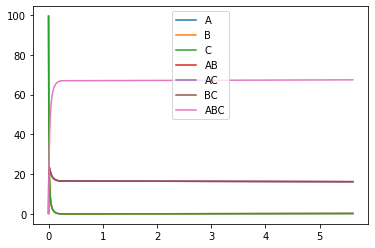

In [18]:
nodes_list = ['A','B','C','ABC','AB','BC','AC']
#nodes_list = ['AB','BMS','ABS','AMS','ABMS','AM','BM','MS']
optim.plot_observable(0,nodes_list)


**After 750 optimization iterations**


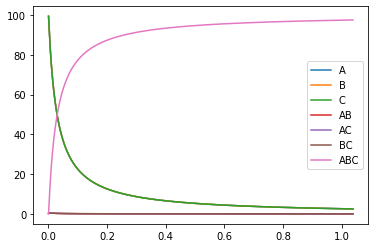

In [19]:

optim.plot_observable(-1,nodes_list)


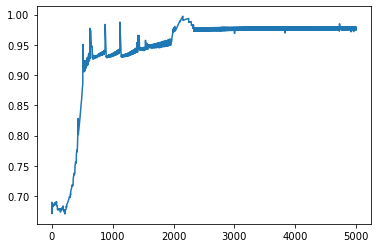

In [20]:
optim.plot_yield()

It seems like we've found a stable solution that produces greater yield than equilibrium. This should be thermodynamically
impossible. Let's try to find an explanation. We'll run simulations using the learned optimal parameters at a few different
timescales.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Using CPU
Start of simulation: memory Used:  89.5
Next time:  tensor(1.0380, dtype=torch.float64, grad_fn=<AddBackward0>)
Using CPU
Start of simulation: memory Used:  89.5
Next time:  tensor(6.8676, dtype=torch.float64, grad_fn=<AddBackward0>)
Using CPU
Start of simulation: memory Used:  89.5


No handles with labels found to put in legend.


Next time:  tensor(10.7074, dtype=torch.float64, grad_fn=<AddBackward0>)


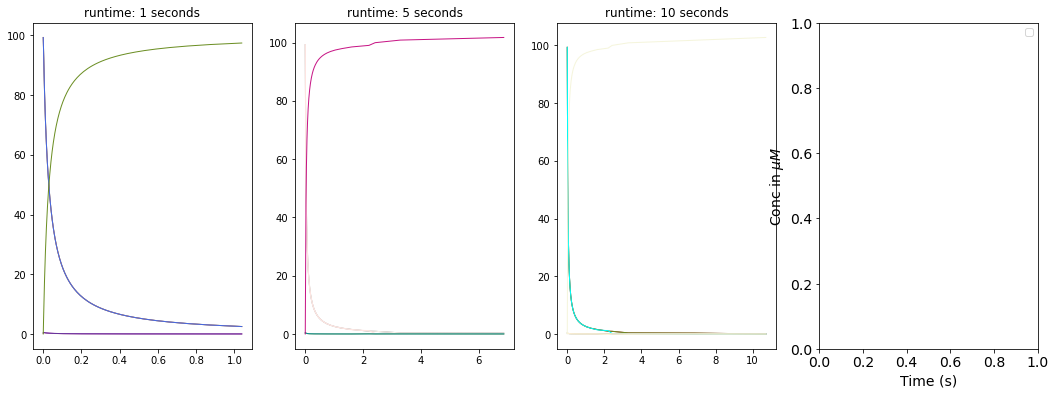

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 4)
optim_rn = optim.rn
for i, runtime in enumerate([1, 5, 10]):
    optim_rn.reset()
    sim = VecSim(optim_rn, runtime, device='cpu')
    y = sim.simulate()
    sim.plot_observable(nodes_list,ax=ax[i])
    ax[i].set_title("runtime: " + str(runtime) + " seconds")
fig.set_size_inches(18, 6)
plt.show()

In [22]:
def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|                                                                             |
Reaction:  A + B  ->  AB
Net flux:  tensor([0.0043], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(0.1123, dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.1114], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1.0, 'k_off': 0.002061153622438557, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
Reaction:  A + C  ->  AC
Net flux:  tensor([0.], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(0.1153, dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.1143], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1.0, 'k_off': 0.002061153622438557, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
Reaction:  A + B

In [23]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

ABC  :  tensor([-6624.2585], dtype=torch.float64, grad_fn=<AddBackward0>)
BC  :  tensor([2093.9522], dtype=torch.float64, grad_fn=<AddBackward0>)
A  :  tensor([2093.9565], dtype=torch.float64, grad_fn=<AddBackward0>)
AC  :  tensor([2141.5218], dtype=torch.float64, grad_fn=<AddBackward0>)
B  :  tensor([2141.5261], dtype=torch.float64, grad_fn=<AddBackward0>)
AB  :  tensor([2388.7802], dtype=torch.float64, grad_fn=<AddBackward0>)
C  :  tensor([2388.7845], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([0.0000e+00, 0.0000e+00, 3.5650e-05, 3.9020e-02, 0.0000e+00, 0.0000e+00,
        1.0275e+02], dtype=torch.float64, grad_fn=<MaxBackward2>)
Parameter containing:
tensor([ 0.1123,  0.1153,  0.1113, 21.2126, 23.6619, 20.7414],
       dtype=torch.float64, requires_grad=True)


In [24]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(init_val=vec_rn.copies_vec.detach().numpy().tolist())
#solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

NameError: name 'solution' is not defined

In [ ]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

Clearly, the equilibrium reached by the system still matches the equilibrium solution. We have however found a set of parameters that can increase available complete AP2 at some point before equilibrium to levels significantly higher than at equilibrium. We don't observe any trapping, but have uncovered an interesting effect. 

Now we'll move on to looking at ARP23. This is 7 subunits, which drastically increases the number of possible reactions. Expect longer runtimes. 